In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss
import os

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
save_name = f"assets/results/{dataset_name}/{model_name}/{ood}"
os.makedirs(os.path.dirname(save_name + "_blank.file"), exist_ok=True)
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data(shuffle_training_data=False)
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 vkur2fs8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

  0%|                                                                                                                              | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                      | 1/1870 [00:00<26:32,  1.17it/s]

  0%|▏                                                                                                                     | 2/1870 [00:01<14:03,  2.21it/s]

  0%|▏                                                                                                                     | 3/1870 [00:01<10:03,  3.09it/s]

  0%|▎                                                                                                                     | 4/1870 [00:01<08:10,  3.81it/s]

  0%|▎                                                                                                                     | 5/1870 [00:01<07:07,  4.36it/s]

  0%|▍                                                                                                                     | 6/1870 [00:01<06:29,  4.78it/s]

  0%|▍                                                                                                                     | 7/1870 [00:01<06:05,  5.09it/s]

  0%|▌                                                                                                                     | 8/1870 [00:02<05:50,  5.32it/s]

  0%|▌                                                                                                                     | 9/1870 [00:02<05:39,  5.48it/s]

  1%|▋                                                                                                                    | 10/1870 [00:02<05:32,  5.59it/s]

  1%|▋                                                                                                                    | 11/1870 [00:02<05:27,  5.68it/s]

  1%|▊                                                                                                                    | 12/1870 [00:02<05:23,  5.74it/s]

  1%|▊                                                                                                                    | 13/1870 [00:02<05:21,  5.78it/s]

  1%|▉                                                                                                                    | 14/1870 [00:03<05:19,  5.81it/s]

  1%|▉                                                                                                                    | 15/1870 [00:03<05:18,  5.83it/s]

  1%|█                                                                                                                    | 16/1870 [00:03<05:17,  5.84it/s]

  1%|█                                                                                                                    | 17/1870 [00:03<05:16,  5.85it/s]

  1%|█▏                                                                                                                   | 18/1870 [00:03<05:16,  5.86it/s]

  1%|█▏                                                                                                                   | 19/1870 [00:03<05:15,  5.86it/s]

  1%|█▎                                                                                                                   | 20/1870 [00:04<05:15,  5.87it/s]

  1%|█▎                                                                                                                   | 21/1870 [00:04<05:14,  5.87it/s]

  1%|█▍                                                                                                                   | 22/1870 [00:04<05:14,  5.88it/s]

  1%|█▍                                                                                                                   | 23/1870 [00:04<05:14,  5.87it/s]

  1%|█▌                                                                                                                   | 24/1870 [00:04<05:14,  5.87it/s]

  1%|█▌                                                                                                                   | 25/1870 [00:04<05:13,  5.88it/s]

  1%|█▋                                                                                                                   | 26/1870 [00:05<05:13,  5.88it/s]

  1%|█▋                                                                                                                   | 27/1870 [00:05<05:13,  5.88it/s]

  1%|█▊                                                                                                                   | 28/1870 [00:05<05:13,  5.88it/s]

  2%|█▊                                                                                                                   | 29/1870 [00:05<05:13,  5.88it/s]

  2%|█▉                                                                                                                   | 30/1870 [00:05<05:13,  5.87it/s]

  2%|█▉                                                                                                                   | 31/1870 [00:05<05:12,  5.88it/s]

  2%|██                                                                                                                   | 32/1870 [00:06<05:12,  5.88it/s]

  2%|██                                                                                                                   | 33/1870 [00:06<05:12,  5.88it/s]

  2%|██▏                                                                                                                  | 34/1870 [00:06<05:12,  5.88it/s]

  2%|██▏                                                                                                                  | 35/1870 [00:06<05:12,  5.88it/s]

  2%|██▎                                                                                                                  | 36/1870 [00:06<05:11,  5.88it/s]

  2%|██▎                                                                                                                  | 37/1870 [00:06<05:12,  5.87it/s]

  2%|██▍                                                                                                                  | 38/1870 [00:07<05:11,  5.87it/s]

  2%|██▍                                                                                                                  | 39/1870 [00:07<05:11,  5.88it/s]

  2%|██▌                                                                                                                  | 40/1870 [00:07<05:11,  5.88it/s]

  2%|██▌                                                                                                                  | 41/1870 [00:07<05:11,  5.88it/s]

  2%|██▋                                                                                                                  | 42/1870 [00:07<05:10,  5.88it/s]

  2%|██▋                                                                                                                  | 43/1870 [00:07<05:10,  5.88it/s]

  2%|██▊                                                                                                                  | 44/1870 [00:08<05:10,  5.87it/s]

  2%|██▊                                                                                                                  | 45/1870 [00:08<05:10,  5.87it/s]

  2%|██▉                                                                                                                  | 46/1870 [00:08<05:10,  5.88it/s]

  3%|██▉                                                                                                                  | 47/1870 [00:08<05:10,  5.88it/s]

  3%|███                                                                                                                  | 48/1870 [00:08<05:10,  5.88it/s]

  3%|███                                                                                                                  | 49/1870 [00:09<05:09,  5.88it/s]

  3%|███▏                                                                                                                 | 50/1870 [00:09<05:09,  5.88it/s]

  3%|███▏                                                                                                                 | 51/1870 [00:09<05:09,  5.88it/s]

  3%|███▎                                                                                                                 | 52/1870 [00:09<05:08,  5.89it/s]

  3%|███▎                                                                                                                 | 53/1870 [00:09<05:07,  5.90it/s]

  3%|███▍                                                                                                                 | 54/1870 [00:09<05:07,  5.91it/s]

  3%|███▍                                                                                                                 | 55/1870 [00:10<05:06,  5.91it/s]

  3%|███▌                                                                                                                 | 56/1870 [00:10<05:06,  5.92it/s]

  3%|███▌                                                                                                                 | 57/1870 [00:10<05:06,  5.92it/s]

  3%|███▋                                                                                                                 | 58/1870 [00:10<05:06,  5.91it/s]

  3%|███▋                                                                                                                 | 59/1870 [00:10<05:06,  5.90it/s]

  3%|███▊                                                                                                                 | 60/1870 [00:10<05:06,  5.90it/s]

  3%|███▊                                                                                                                 | 61/1870 [00:11<05:07,  5.89it/s]

  3%|███▉                                                                                                                 | 62/1870 [00:11<05:07,  5.89it/s]

  3%|███▉                                                                                                                 | 63/1870 [00:11<05:07,  5.89it/s]

  3%|████                                                                                                                 | 64/1870 [00:11<05:06,  5.88it/s]

  3%|████                                                                                                                 | 65/1870 [00:11<05:07,  5.87it/s]

  4%|████▏                                                                                                                | 66/1870 [00:11<05:06,  5.88it/s]

  4%|████▏                                                                                                                | 67/1870 [00:12<05:06,  5.88it/s]

  4%|████▎                                                                                                                | 68/1870 [00:12<05:06,  5.88it/s]

  4%|████▎                                                                                                                | 69/1870 [00:12<05:06,  5.88it/s]

  4%|████▍                                                                                                                | 70/1870 [00:12<05:06,  5.88it/s]

  4%|████▍                                                                                                                | 71/1870 [00:12<05:05,  5.88it/s]

  4%|████▌                                                                                                                | 72/1870 [00:12<05:06,  5.87it/s]

  4%|████▌                                                                                                                | 73/1870 [00:13<05:05,  5.88it/s]

  4%|████▋                                                                                                                | 74/1870 [00:13<05:05,  5.88it/s]

  4%|████▋                                                                                                                | 75/1870 [00:13<05:05,  5.88it/s]

  4%|████▊                                                                                                                | 76/1870 [00:13<05:05,  5.88it/s]

  4%|████▊                                                                                                                | 77/1870 [00:13<05:04,  5.88it/s]

  4%|████▉                                                                                                                | 78/1870 [00:13<05:04,  5.88it/s]

  4%|████▉                                                                                                                | 79/1870 [00:14<05:04,  5.87it/s]

  4%|█████                                                                                                                | 80/1870 [00:14<05:04,  5.87it/s]

  4%|█████                                                                                                                | 81/1870 [00:14<05:04,  5.88it/s]

  4%|█████▏                                                                                                               | 82/1870 [00:14<05:04,  5.88it/s]

  4%|█████▏                                                                                                               | 83/1870 [00:14<05:03,  5.88it/s]

  4%|█████▎                                                                                                               | 84/1870 [00:14<05:03,  5.88it/s]

  5%|█████▎                                                                                                               | 85/1870 [00:15<05:03,  5.88it/s]

  5%|█████▍                                                                                                               | 86/1870 [00:15<05:03,  5.87it/s]

  5%|█████▍                                                                                                               | 87/1870 [00:15<05:03,  5.88it/s]

  5%|█████▌                                                                                                               | 88/1870 [00:15<05:03,  5.88it/s]

  5%|█████▌                                                                                                               | 89/1870 [00:15<05:02,  5.88it/s]

  5%|█████▋                                                                                                               | 90/1870 [00:15<05:02,  5.88it/s]

  5%|█████▋                                                                                                               | 91/1870 [00:16<05:02,  5.88it/s]

  5%|█████▊                                                                                                               | 92/1870 [00:16<05:02,  5.88it/s]

  5%|█████▊                                                                                                               | 93/1870 [00:16<05:02,  5.87it/s]

  5%|█████▉                                                                                                               | 94/1870 [00:16<05:02,  5.88it/s]

  5%|█████▉                                                                                                               | 95/1870 [00:16<05:02,  5.88it/s]

  5%|██████                                                                                                               | 96/1870 [00:17<05:01,  5.88it/s]

  5%|██████                                                                                                               | 97/1870 [00:17<05:01,  5.88it/s]

  5%|██████▏                                                                                                              | 98/1870 [00:17<05:01,  5.88it/s]

  5%|██████▏                                                                                                              | 99/1870 [00:17<05:01,  5.88it/s]

  5%|██████▏                                                                                                             | 100/1870 [00:17<05:01,  5.87it/s]

  5%|██████▎                                                                                                             | 101/1870 [00:17<05:01,  5.88it/s]

  5%|██████▎                                                                                                             | 102/1870 [00:18<05:00,  5.88it/s]

  6%|██████▍                                                                                                             | 103/1870 [00:18<05:00,  5.88it/s]

  6%|██████▍                                                                                                             | 104/1870 [00:18<05:00,  5.88it/s]

  6%|██████▌                                                                                                             | 105/1870 [00:18<05:00,  5.88it/s]

  6%|██████▌                                                                                                             | 106/1870 [00:18<04:59,  5.88it/s]

  6%|██████▋                                                                                                             | 107/1870 [00:18<04:59,  5.88it/s]

  6%|██████▋                                                                                                             | 108/1870 [00:19<04:58,  5.90it/s]

  6%|██████▊                                                                                                             | 109/1870 [00:19<04:58,  5.91it/s]

  6%|██████▊                                                                                                             | 110/1870 [00:19<04:57,  5.91it/s]

  6%|██████▉                                                                                                             | 111/1870 [00:19<04:57,  5.92it/s]

  6%|██████▉                                                                                                             | 112/1870 [00:19<04:56,  5.92it/s]

  6%|███████                                                                                                             | 113/1870 [00:19<04:56,  5.92it/s]

  6%|███████                                                                                                             | 114/1870 [00:20<04:56,  5.92it/s]

  6%|███████▏                                                                                                            | 115/1870 [00:20<04:57,  5.90it/s]

  6%|███████▏                                                                                                            | 116/1870 [00:20<04:57,  5.90it/s]

  6%|███████▎                                                                                                            | 117/1870 [00:20<04:57,  5.89it/s]

  6%|███████▎                                                                                                            | 118/1870 [00:20<04:57,  5.89it/s]

  6%|███████▍                                                                                                            | 119/1870 [00:20<04:57,  5.89it/s]

  6%|███████▍                                                                                                            | 120/1870 [00:21<04:57,  5.89it/s]

  6%|███████▌                                                                                                            | 121/1870 [00:21<04:57,  5.88it/s]

  7%|███████▌                                                                                                            | 122/1870 [00:21<04:57,  5.88it/s]

  7%|███████▋                                                                                                            | 123/1870 [00:21<04:57,  5.88it/s]

  7%|███████▋                                                                                                            | 124/1870 [00:21<04:56,  5.88it/s]

  7%|███████▊                                                                                                            | 125/1870 [00:21<04:56,  5.88it/s]

  7%|███████▊                                                                                                            | 126/1870 [00:22<04:56,  5.88it/s]

  7%|███████▉                                                                                                            | 127/1870 [00:22<04:56,  5.88it/s]

  7%|███████▉                                                                                                            | 128/1870 [00:22<04:56,  5.88it/s]

  7%|████████                                                                                                            | 129/1870 [00:22<04:56,  5.88it/s]

  7%|████████                                                                                                            | 130/1870 [00:22<04:55,  5.88it/s]

  7%|████████▏                                                                                                           | 131/1870 [00:22<04:55,  5.88it/s]

  7%|████████▏                                                                                                           | 132/1870 [00:23<04:55,  5.88it/s]

  7%|████████▎                                                                                                           | 133/1870 [00:23<04:55,  5.88it/s]

  7%|████████▎                                                                                                           | 134/1870 [00:23<04:55,  5.88it/s]

  7%|████████▎                                                                                                           | 135/1870 [00:23<04:55,  5.88it/s]

  7%|████████▍                                                                                                           | 136/1870 [00:23<04:54,  5.88it/s]

  7%|████████▍                                                                                                           | 137/1870 [00:23<04:54,  5.88it/s]

  7%|████████▌                                                                                                           | 138/1870 [00:24<04:54,  5.88it/s]

  7%|████████▌                                                                                                           | 139/1870 [00:24<04:54,  5.88it/s]

  7%|████████▋                                                                                                           | 140/1870 [00:24<04:54,  5.88it/s]

  8%|████████▋                                                                                                           | 141/1870 [00:24<04:53,  5.88it/s]

  8%|████████▊                                                                                                           | 142/1870 [00:24<04:54,  5.88it/s]

  8%|████████▊                                                                                                           | 143/1870 [00:24<04:53,  5.88it/s]

  8%|████████▉                                                                                                           | 144/1870 [00:25<04:53,  5.88it/s]

  8%|████████▉                                                                                                           | 145/1870 [00:25<04:53,  5.88it/s]

  8%|█████████                                                                                                           | 146/1870 [00:25<04:53,  5.88it/s]

  8%|█████████                                                                                                           | 147/1870 [00:25<04:52,  5.88it/s]

  8%|█████████▏                                                                                                          | 148/1870 [00:25<04:52,  5.88it/s]

  8%|█████████▏                                                                                                          | 149/1870 [00:26<04:52,  5.87it/s]

  8%|█████████▎                                                                                                          | 150/1870 [00:26<04:52,  5.88it/s]

  8%|█████████▎                                                                                                          | 151/1870 [00:26<04:52,  5.88it/s]

  8%|█████████▍                                                                                                          | 152/1870 [00:26<04:52,  5.88it/s]

  8%|█████████▍                                                                                                          | 153/1870 [00:26<04:51,  5.88it/s]

  8%|█████████▌                                                                                                          | 154/1870 [00:26<04:51,  5.88it/s]

  8%|█████████▌                                                                                                          | 155/1870 [00:27<04:51,  5.88it/s]

  8%|█████████▋                                                                                                          | 156/1870 [00:27<04:51,  5.87it/s]

  8%|█████████▋                                                                                                          | 157/1870 [00:27<04:51,  5.88it/s]

  8%|█████████▊                                                                                                          | 158/1870 [00:27<04:51,  5.88it/s]

  9%|█████████▊                                                                                                          | 159/1870 [00:27<04:50,  5.88it/s]

  9%|█████████▉                                                                                                          | 160/1870 [00:27<04:50,  5.88it/s]

  9%|█████████▉                                                                                                          | 161/1870 [00:28<04:50,  5.88it/s]

  9%|██████████                                                                                                          | 162/1870 [00:28<04:50,  5.88it/s]

  9%|██████████                                                                                                          | 163/1870 [00:28<04:50,  5.88it/s]

  9%|██████████▏                                                                                                         | 164/1870 [00:28<04:49,  5.90it/s]

  9%|██████████▏                                                                                                         | 165/1870 [00:28<04:48,  5.91it/s]

  9%|██████████▎                                                                                                         | 166/1870 [00:28<04:48,  5.91it/s]

  9%|██████████▎                                                                                                         | 167/1870 [00:29<04:47,  5.92it/s]

  9%|██████████▍                                                                                                         | 168/1870 [00:29<04:47,  5.92it/s]

  9%|██████████▍                                                                                                         | 169/1870 [00:29<04:47,  5.92it/s]

  9%|██████████▌                                                                                                         | 170/1870 [00:29<04:47,  5.91it/s]

  9%|██████████▌                                                                                                         | 171/1870 [00:29<04:47,  5.91it/s]

  9%|██████████▋                                                                                                         | 172/1870 [00:29<04:47,  5.90it/s]

  9%|██████████▋                                                                                                         | 173/1870 [00:30<04:47,  5.89it/s]

  9%|██████████▊                                                                                                         | 174/1870 [00:30<04:47,  5.89it/s]

  9%|██████████▊                                                                                                         | 175/1870 [00:30<04:47,  5.89it/s]

  9%|██████████▉                                                                                                         | 176/1870 [00:30<04:47,  5.89it/s]

  9%|██████████▉                                                                                                         | 177/1870 [00:30<04:48,  5.88it/s]

 10%|███████████                                                                                                         | 178/1870 [00:30<04:47,  5.88it/s]

 10%|███████████                                                                                                         | 179/1870 [00:31<04:47,  5.88it/s]

 10%|███████████▏                                                                                                        | 180/1870 [00:31<04:47,  5.88it/s]

 10%|███████████▏                                                                                                        | 181/1870 [00:31<04:47,  5.88it/s]

 10%|███████████▎                                                                                                        | 182/1870 [00:31<04:47,  5.88it/s]

 10%|███████████▎                                                                                                        | 183/1870 [00:31<04:46,  5.88it/s]

 10%|███████████▍                                                                                                        | 184/1870 [00:31<04:47,  5.87it/s]

 10%|███████████▍                                                                                                        | 185/1870 [00:32<04:46,  5.88it/s]

 10%|███████████▌                                                                                                        | 186/1870 [00:32<04:46,  5.88it/s]

 10%|███████████▌                                                                                                        | 187/1870 [00:32<04:46,  5.88it/s]

 10%|███████████▋                                                                                                        | 188/1870 [00:32<04:45,  5.88it/s]

 10%|███████████▋                                                                                                        | 189/1870 [00:32<04:45,  5.88it/s]

 10%|███████████▊                                                                                                        | 190/1870 [00:32<04:45,  5.88it/s]

 10%|███████████▊                                                                                                        | 191/1870 [00:33<04:45,  5.88it/s]

 10%|███████████▉                                                                                                        | 192/1870 [00:33<04:45,  5.88it/s]

 10%|███████████▉                                                                                                        | 193/1870 [00:33<04:45,  5.88it/s]

 10%|████████████                                                                                                        | 194/1870 [00:33<04:44,  5.88it/s]

 10%|████████████                                                                                                        | 195/1870 [00:33<04:44,  5.88it/s]

 10%|████████████▏                                                                                                       | 196/1870 [00:33<04:44,  5.88it/s]

 11%|████████████▏                                                                                                       | 197/1870 [00:34<04:44,  5.88it/s]

 11%|████████████▎                                                                                                       | 198/1870 [00:34<04:44,  5.87it/s]

 11%|████████████▎                                                                                                       | 199/1870 [00:34<04:44,  5.88it/s]

 11%|████████████▍                                                                                                       | 200/1870 [00:34<04:44,  5.88it/s]

 11%|████████████▍                                                                                                       | 201/1870 [00:34<04:43,  5.88it/s]

 11%|████████████▌                                                                                                       | 202/1870 [00:35<04:43,  5.88it/s]

 11%|████████████▌                                                                                                       | 203/1870 [00:35<04:43,  5.89it/s]

 11%|████████████▋                                                                                                       | 204/1870 [00:35<04:43,  5.89it/s]

 11%|████████████▋                                                                                                       | 205/1870 [00:35<04:43,  5.88it/s]

 11%|████████████▊                                                                                                       | 206/1870 [00:35<04:42,  5.88it/s]

 11%|████████████▊                                                                                                       | 207/1870 [00:35<04:42,  5.88it/s]

 11%|████████████▉                                                                                                       | 208/1870 [00:36<04:42,  5.89it/s]

 11%|████████████▉                                                                                                       | 209/1870 [00:36<04:42,  5.89it/s]

 11%|█████████████                                                                                                       | 210/1870 [00:36<04:41,  5.89it/s]

 11%|█████████████                                                                                                       | 211/1870 [00:36<04:41,  5.89it/s]

 11%|█████████████▏                                                                                                      | 212/1870 [00:36<04:41,  5.88it/s]

 11%|█████████████▏                                                                                                      | 213/1870 [00:36<04:41,  5.88it/s]

 11%|█████████████▎                                                                                                      | 214/1870 [00:37<04:41,  5.89it/s]

 11%|█████████████▎                                                                                                      | 215/1870 [00:37<04:41,  5.89it/s]

 12%|█████████████▍                                                                                                      | 216/1870 [00:37<04:40,  5.89it/s]

 12%|█████████████▍                                                                                                      | 217/1870 [00:37<04:40,  5.89it/s]

 12%|█████████████▌                                                                                                      | 218/1870 [00:37<04:40,  5.89it/s]

 12%|█████████████▌                                                                                                      | 219/1870 [00:37<04:40,  5.89it/s]

 12%|█████████████▋                                                                                                      | 220/1870 [00:38<04:39,  5.90it/s]

 12%|█████████████▋                                                                                                      | 221/1870 [00:38<04:38,  5.91it/s]

 12%|█████████████▊                                                                                                      | 222/1870 [00:38<04:38,  5.92it/s]

 12%|█████████████▊                                                                                                      | 223/1870 [00:38<04:38,  5.92it/s]

 12%|█████████████▉                                                                                                      | 224/1870 [00:38<04:38,  5.91it/s]

 12%|█████████████▉                                                                                                      | 225/1870 [00:38<04:38,  5.91it/s]

 12%|██████████████                                                                                                      | 226/1870 [00:39<04:38,  5.90it/s]

 12%|██████████████                                                                                                      | 227/1870 [00:39<04:38,  5.89it/s]

 12%|██████████████▏                                                                                                     | 228/1870 [00:39<04:38,  5.89it/s]

 12%|██████████████▏                                                                                                     | 229/1870 [00:39<04:38,  5.89it/s]

 12%|██████████████▎                                                                                                     | 230/1870 [00:39<04:38,  5.90it/s]

 12%|██████████████▎                                                                                                     | 231/1870 [00:39<04:38,  5.89it/s]

 12%|██████████████▍                                                                                                     | 232/1870 [00:40<04:37,  5.89it/s]

 12%|██████████████▍                                                                                                     | 233/1870 [00:40<04:38,  5.89it/s]

 13%|██████████████▌                                                                                                     | 234/1870 [00:40<04:37,  5.89it/s]

 13%|██████████████▌                                                                                                     | 235/1870 [00:40<04:37,  5.89it/s]

 13%|██████████████▋                                                                                                     | 236/1870 [00:40<04:37,  5.89it/s]

 13%|██████████████▋                                                                                                     | 237/1870 [00:40<04:37,  5.89it/s]

 13%|██████████████▊                                                                                                     | 238/1870 [00:41<04:37,  5.89it/s]

 13%|██████████████▊                                                                                                     | 239/1870 [00:41<04:36,  5.89it/s]

 13%|██████████████▉                                                                                                     | 240/1870 [00:41<04:37,  5.88it/s]

 13%|██████████████▉                                                                                                     | 241/1870 [00:41<04:36,  5.89it/s]

 13%|███████████████                                                                                                     | 242/1870 [00:41<04:36,  5.89it/s]

 13%|███████████████                                                                                                     | 243/1870 [00:41<04:36,  5.89it/s]

 13%|███████████████▏                                                                                                    | 244/1870 [00:42<04:36,  5.89it/s]

 13%|███████████████▏                                                                                                    | 245/1870 [00:42<04:35,  5.89it/s]

 13%|███████████████▎                                                                                                    | 246/1870 [00:42<04:35,  5.89it/s]

 13%|███████████████▎                                                                                                    | 247/1870 [00:42<04:35,  5.88it/s]

 13%|███████████████▍                                                                                                    | 248/1870 [00:42<04:35,  5.88it/s]

 13%|███████████████▍                                                                                                    | 249/1870 [00:42<04:35,  5.88it/s]

 13%|███████████████▌                                                                                                    | 250/1870 [00:43<04:35,  5.88it/s]

 13%|███████████████▌                                                                                                    | 251/1870 [00:43<04:35,  5.88it/s]

 13%|███████████████▋                                                                                                    | 252/1870 [00:43<04:34,  5.89it/s]

 14%|███████████████▋                                                                                                    | 253/1870 [00:43<04:34,  5.89it/s]

 14%|███████████████▊                                                                                                    | 254/1870 [00:43<04:34,  5.89it/s]

 14%|███████████████▊                                                                                                    | 255/1870 [00:44<04:34,  5.89it/s]

 14%|███████████████▉                                                                                                    | 256/1870 [00:44<04:33,  5.90it/s]

 14%|███████████████▉                                                                                                    | 257/1870 [00:44<04:33,  5.89it/s]

 14%|████████████████                                                                                                    | 258/1870 [00:44<04:33,  5.89it/s]

 14%|████████████████                                                                                                    | 259/1870 [00:44<04:33,  5.89it/s]

 14%|████████████████▏                                                                                                   | 260/1870 [00:44<04:33,  5.89it/s]

 14%|████████████████▏                                                                                                   | 261/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▎                                                                                                   | 262/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▎                                                                                                   | 263/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▍                                                                                                   | 264/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▍                                                                                                   | 265/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▌                                                                                                   | 266/1870 [00:45<04:32,  5.89it/s]

 14%|████████████████▌                                                                                                   | 267/1870 [00:46<04:31,  5.89it/s]

 14%|████████████████▌                                                                                                   | 268/1870 [00:46<04:31,  5.89it/s]

 14%|████████████████▋                                                                                                   | 269/1870 [00:46<04:31,  5.89it/s]

 14%|████████████████▋                                                                                                   | 270/1870 [00:46<04:31,  5.89it/s]

 14%|████████████████▊                                                                                                   | 271/1870 [00:46<04:31,  5.89it/s]

 15%|████████████████▊                                                                                                   | 272/1870 [00:46<04:31,  5.89it/s]

 15%|████████████████▉                                                                                                   | 273/1870 [00:47<04:31,  5.89it/s]

 15%|████████████████▉                                                                                                   | 274/1870 [00:47<04:30,  5.89it/s]

 15%|█████████████████                                                                                                   | 275/1870 [00:47<04:30,  5.89it/s]

 15%|█████████████████                                                                                                   | 276/1870 [00:47<04:30,  5.89it/s]

 15%|█████████████████▏                                                                                                  | 277/1870 [00:47<04:30,  5.89it/s]

 15%|█████████████████▏                                                                                                  | 278/1870 [00:47<04:30,  5.89it/s]

 15%|█████████████████▎                                                                                                  | 279/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████▎                                                                                                  | 280/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████▍                                                                                                  | 281/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████▍                                                                                                  | 282/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████▌                                                                                                  | 283/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████▌                                                                                                  | 284/1870 [00:48<04:28,  5.90it/s]

 15%|█████████████████▋                                                                                                  | 285/1870 [00:49<04:28,  5.91it/s]

 15%|█████████████████▋                                                                                                  | 286/1870 [00:49<04:27,  5.92it/s]

 15%|█████████████████▊                                                                                                  | 287/1870 [00:49<04:27,  5.92it/s]

 15%|█████████████████▊                                                                                                  | 288/1870 [00:49<04:26,  5.93it/s]

 15%|█████████████████▉                                                                                                  | 289/1870 [00:49<04:26,  5.93it/s]

 16%|█████████████████▉                                                                                                  | 290/1870 [00:49<04:26,  5.92it/s]

 16%|██████████████████                                                                                                  | 291/1870 [00:50<04:27,  5.91it/s]

 16%|██████████████████                                                                                                  | 292/1870 [00:50<04:27,  5.91it/s]

 16%|██████████████████▏                                                                                                 | 293/1870 [00:50<04:27,  5.90it/s]

 16%|██████████████████▏                                                                                                 | 294/1870 [00:50<04:27,  5.89it/s]

 16%|██████████████████▎                                                                                                 | 295/1870 [00:50<04:27,  5.89it/s]

 16%|██████████████████▎                                                                                                 | 296/1870 [00:50<04:27,  5.89it/s]

 16%|██████████████████▍                                                                                                 | 297/1870 [00:51<04:27,  5.88it/s]

 16%|██████████████████▍                                                                                                 | 298/1870 [00:51<04:27,  5.88it/s]

 16%|██████████████████▌                                                                                                 | 299/1870 [00:51<04:27,  5.88it/s]

 16%|██████████████████▌                                                                                                 | 300/1870 [00:51<04:26,  5.88it/s]

 16%|██████████████████▋                                                                                                 | 301/1870 [00:51<04:26,  5.89it/s]

 16%|██████████████████▋                                                                                                 | 302/1870 [00:51<04:26,  5.88it/s]

 16%|██████████████████▊                                                                                                 | 303/1870 [00:52<04:26,  5.88it/s]

 16%|██████████████████▊                                                                                                 | 304/1870 [00:52<04:26,  5.87it/s]

 16%|██████████████████▉                                                                                                 | 305/1870 [00:52<04:26,  5.87it/s]

 16%|██████████████████▉                                                                                                 | 306/1870 [00:52<04:26,  5.87it/s]

 16%|███████████████████                                                                                                 | 307/1870 [00:52<04:26,  5.87it/s]

 16%|███████████████████                                                                                                 | 308/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▏                                                                                                | 309/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▏                                                                                                | 310/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▎                                                                                                | 311/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▎                                                                                                | 312/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▍                                                                                                | 313/1870 [00:53<04:25,  5.87it/s]

 17%|███████████████████▍                                                                                                | 314/1870 [00:54<04:24,  5.87it/s]

 17%|███████████████████▌                                                                                                | 315/1870 [00:54<04:24,  5.87it/s]

 17%|███████████████████▌                                                                                                | 316/1870 [00:54<04:24,  5.87it/s]

 17%|███████████████████▋                                                                                                | 317/1870 [00:54<04:24,  5.86it/s]

 17%|███████████████████▋                                                                                                | 318/1870 [00:54<04:24,  5.87it/s]

 17%|███████████████████▊                                                                                                | 319/1870 [00:54<04:24,  5.87it/s]

 17%|███████████████████▊                                                                                                | 320/1870 [00:55<04:24,  5.87it/s]

 17%|███████████████████▉                                                                                                | 321/1870 [00:55<04:23,  5.87it/s]

 17%|███████████████████▉                                                                                                | 322/1870 [00:55<04:23,  5.87it/s]

 17%|████████████████████                                                                                                | 323/1870 [00:55<04:23,  5.87it/s]

 17%|████████████████████                                                                                                | 324/1870 [00:55<04:23,  5.87it/s]

 17%|████████████████████▏                                                                                               | 325/1870 [00:55<04:23,  5.87it/s]

 17%|████████████████████▏                                                                                               | 326/1870 [00:56<04:22,  5.87it/s]

 17%|████████████████████▎                                                                                               | 327/1870 [00:56<04:22,  5.87it/s]

 18%|████████████████████▎                                                                                               | 328/1870 [00:56<04:22,  5.87it/s]

 18%|████████████████████▍                                                                                               | 329/1870 [00:56<04:22,  5.87it/s]

 18%|████████████████████▍                                                                                               | 330/1870 [00:56<04:22,  5.87it/s]

 18%|████████████████████▌                                                                                               | 331/1870 [00:56<04:22,  5.87it/s]

 18%|████████████████████▌                                                                                               | 332/1870 [00:57<04:22,  5.87it/s]

 18%|████████████████████▋                                                                                               | 333/1870 [00:57<04:21,  5.87it/s]

 18%|████████████████████▋                                                                                               | 334/1870 [00:57<04:21,  5.87it/s]

 18%|████████████████████▊                                                                                               | 335/1870 [00:57<04:21,  5.87it/s]

 18%|████████████████████▊                                                                                               | 336/1870 [00:57<04:21,  5.87it/s]

 18%|████████████████████▉                                                                                               | 337/1870 [00:57<04:20,  5.87it/s]

 18%|████████████████████▉                                                                                               | 338/1870 [00:58<04:20,  5.87it/s]

 18%|█████████████████████                                                                                               | 339/1870 [00:58<04:20,  5.89it/s]

 18%|█████████████████████                                                                                               | 340/1870 [00:58<04:19,  5.90it/s]

 18%|█████████████████████▏                                                                                              | 341/1870 [00:58<04:19,  5.90it/s]

 18%|█████████████████████▏                                                                                              | 342/1870 [00:58<04:18,  5.91it/s]

 18%|█████████████████████▎                                                                                              | 343/1870 [00:58<04:18,  5.91it/s]

 18%|█████████████████████▎                                                                                              | 344/1870 [00:59<04:17,  5.92it/s]

 18%|█████████████████████▍                                                                                              | 345/1870 [00:59<04:18,  5.91it/s]

 19%|█████████████████████▍                                                                                              | 346/1870 [00:59<04:18,  5.90it/s]

 19%|█████████████████████▌                                                                                              | 347/1870 [00:59<04:18,  5.89it/s]

 19%|█████████████████████▌                                                                                              | 348/1870 [00:59<04:18,  5.89it/s]

 19%|█████████████████████▋                                                                                              | 349/1870 [00:59<04:18,  5.88it/s]

 19%|█████████████████████▋                                                                                              | 350/1870 [01:00<04:18,  5.88it/s]

 19%|█████████████████████▊                                                                                              | 351/1870 [01:00<04:18,  5.88it/s]

 19%|█████████████████████▊                                                                                              | 352/1870 [01:00<04:18,  5.87it/s]

 19%|█████████████████████▉                                                                                              | 353/1870 [01:00<04:18,  5.87it/s]

 19%|█████████████████████▉                                                                                              | 354/1870 [01:00<04:18,  5.87it/s]

 19%|██████████████████████                                                                                              | 355/1870 [01:01<04:17,  5.87it/s]

 19%|██████████████████████                                                                                              | 356/1870 [01:01<04:17,  5.87it/s]

 19%|██████████████████████▏                                                                                             | 357/1870 [01:01<04:18,  5.86it/s]

 19%|██████████████████████▏                                                                                             | 358/1870 [01:01<04:17,  5.87it/s]

 19%|██████████████████████▎                                                                                             | 359/1870 [01:01<04:17,  5.87it/s]

 19%|██████████████████████▎                                                                                             | 360/1870 [01:01<04:17,  5.87it/s]

 19%|██████████████████████▍                                                                                             | 361/1870 [01:02<04:16,  5.87it/s]

 19%|██████████████████████▍                                                                                             | 362/1870 [01:02<04:16,  5.87it/s]

 19%|██████████████████████▌                                                                                             | 363/1870 [01:02<04:16,  5.87it/s]

 19%|██████████████████████▌                                                                                             | 364/1870 [01:02<04:16,  5.87it/s]

 20%|██████████████████████▋                                                                                             | 365/1870 [01:02<04:16,  5.87it/s]

 20%|██████████████████████▋                                                                                             | 366/1870 [01:02<04:16,  5.87it/s]

 20%|██████████████████████▊                                                                                             | 367/1870 [01:03<04:16,  5.87it/s]

 20%|██████████████████████▊                                                                                             | 368/1870 [01:03<04:15,  5.87it/s]

 20%|██████████████████████▉                                                                                             | 369/1870 [01:03<04:15,  5.87it/s]

 20%|██████████████████████▉                                                                                             | 370/1870 [01:03<04:15,  5.87it/s]

 20%|███████████████████████                                                                                             | 371/1870 [01:03<04:15,  5.87it/s]

 20%|███████████████████████                                                                                             | 372/1870 [01:03<04:15,  5.87it/s]

 20%|███████████████████████▏                                                                                            | 373/1870 [01:04<04:15,  5.87it/s]

 20%|███████████████████████▏                                                                                            | 374/1870 [01:04<04:14,  5.87it/s]

 20%|███████████████████████▎                                                                                            | 375/1870 [01:04<04:14,  5.87it/s]

 20%|███████████████████████▎                                                                                            | 376/1870 [01:04<04:14,  5.87it/s]

 20%|███████████████████████▍                                                                                            | 377/1870 [01:04<04:14,  5.87it/s]

 20%|███████████████████████▍                                                                                            | 378/1870 [01:04<04:14,  5.87it/s]

 20%|███████████████████████▌                                                                                            | 379/1870 [01:05<04:14,  5.87it/s]

 20%|███████████████████████▌                                                                                            | 380/1870 [01:05<04:13,  5.87it/s]

 20%|███████████████████████▋                                                                                            | 381/1870 [01:05<04:13,  5.87it/s]

 20%|███████████████████████▋                                                                                            | 382/1870 [01:05<04:13,  5.87it/s]

 20%|███████████████████████▊                                                                                            | 383/1870 [01:05<04:13,  5.87it/s]

 21%|███████████████████████▊                                                                                            | 384/1870 [01:05<04:13,  5.87it/s]

 21%|███████████████████████▉                                                                                            | 385/1870 [01:06<04:12,  5.87it/s]

 21%|███████████████████████▉                                                                                            | 386/1870 [01:06<04:12,  5.87it/s]

 21%|████████████████████████                                                                                            | 387/1870 [01:06<04:12,  5.87it/s]

 21%|████████████████████████                                                                                            | 388/1870 [01:06<04:12,  5.87it/s]

 21%|████████████████████████▏                                                                                           | 389/1870 [01:06<04:12,  5.87it/s]

 21%|████████████████████████▏                                                                                           | 390/1870 [01:06<04:12,  5.87it/s]

 21%|████████████████████████▎                                                                                           | 391/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▎                                                                                           | 392/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▍                                                                                           | 393/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▍                                                                                           | 394/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▌                                                                                           | 395/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▌                                                                                           | 396/1870 [01:07<04:11,  5.87it/s]

 21%|████████████████████████▋                                                                                           | 397/1870 [01:08<04:10,  5.87it/s]

 21%|████████████████████████▋                                                                                           | 398/1870 [01:08<04:10,  5.87it/s]

 21%|████████████████████████▊                                                                                           | 399/1870 [01:08<04:10,  5.87it/s]

 21%|████████████████████████▊                                                                                           | 400/1870 [01:08<04:10,  5.86it/s]

 21%|████████████████████████▊                                                                                           | 401/1870 [01:08<04:10,  5.87it/s]

 21%|████████████████████████▉                                                                                           | 402/1870 [01:09<04:10,  5.86it/s]

 22%|████████████████████████▉                                                                                           | 403/1870 [01:09<04:10,  5.87it/s]

 22%|█████████████████████████                                                                                           | 404/1870 [01:09<04:09,  5.87it/s]

 22%|█████████████████████████                                                                                           | 405/1870 [01:09<04:09,  5.86it/s]

 22%|█████████████████████████▏                                                                                          | 406/1870 [01:09<04:09,  5.87it/s]

 22%|█████████████████████████▏                                                                                          | 407/1870 [01:09<04:09,  5.87it/s]

 22%|█████████████████████████▎                                                                                          | 408/1870 [01:10<04:09,  5.87it/s]

 22%|█████████████████████████▎                                                                                          | 409/1870 [01:10<04:08,  5.87it/s]

 22%|█████████████████████████▍                                                                                          | 410/1870 [01:10<04:08,  5.87it/s]

 22%|█████████████████████████▍                                                                                          | 411/1870 [01:10<04:08,  5.87it/s]

 22%|█████████████████████████▌                                                                                          | 412/1870 [01:10<04:08,  5.86it/s]

 22%|█████████████████████████▌                                                                                          | 413/1870 [01:10<04:08,  5.87it/s]

 22%|█████████████████████████▋                                                                                          | 414/1870 [01:11<04:08,  5.87it/s]

 22%|█████████████████████████▋                                                                                          | 415/1870 [01:11<04:07,  5.87it/s]

 22%|█████████████████████████▊                                                                                          | 416/1870 [01:11<04:07,  5.87it/s]

 22%|█████████████████████████▊                                                                                          | 417/1870 [01:11<04:07,  5.87it/s]

 22%|█████████████████████████▉                                                                                          | 418/1870 [01:11<04:07,  5.87it/s]

 22%|█████████████████████████▉                                                                                          | 419/1870 [01:11<04:07,  5.86it/s]

 22%|██████████████████████████                                                                                          | 420/1870 [01:12<04:07,  5.87it/s]

 23%|██████████████████████████                                                                                          | 421/1870 [01:12<04:06,  5.87it/s]

 23%|██████████████████████████▏                                                                                         | 422/1870 [01:12<04:06,  5.87it/s]

 23%|██████████████████████████▏                                                                                         | 423/1870 [01:12<04:06,  5.87it/s]

 23%|██████████████████████████▎                                                                                         | 424/1870 [01:12<04:06,  5.87it/s]

 23%|██████████████████████████▎                                                                                         | 425/1870 [01:12<04:06,  5.87it/s]

 23%|██████████████████████████▍                                                                                         | 426/1870 [01:13<04:06,  5.86it/s]

 23%|██████████████████████████▍                                                                                         | 427/1870 [01:13<04:05,  5.87it/s]

 23%|██████████████████████████▌                                                                                         | 428/1870 [01:13<04:05,  5.87it/s]

 23%|██████████████████████████▌                                                                                         | 429/1870 [01:13<04:05,  5.87it/s]

 23%|██████████████████████████▋                                                                                         | 430/1870 [01:13<04:05,  5.87it/s]

 23%|██████████████████████████▋                                                                                         | 431/1870 [01:13<04:05,  5.87it/s]

 23%|██████████████████████████▊                                                                                         | 432/1870 [01:14<04:04,  5.87it/s]

 23%|██████████████████████████▊                                                                                         | 433/1870 [01:14<04:05,  5.86it/s]

 23%|██████████████████████████▉                                                                                         | 434/1870 [01:14<04:04,  5.87it/s]

 23%|██████████████████████████▉                                                                                         | 435/1870 [01:14<04:04,  5.87it/s]

 23%|███████████████████████████                                                                                         | 436/1870 [01:14<04:04,  5.87it/s]

 23%|███████████████████████████                                                                                         | 437/1870 [01:14<04:04,  5.87it/s]

 23%|███████████████████████████▏                                                                                        | 438/1870 [01:15<04:03,  5.87it/s]

 23%|███████████████████████████▏                                                                                        | 439/1870 [01:15<04:03,  5.87it/s]

 24%|███████████████████████████▎                                                                                        | 440/1870 [01:15<04:03,  5.86it/s]

 24%|███████████████████████████▎                                                                                        | 441/1870 [01:15<04:03,  5.87it/s]

 24%|███████████████████████████▍                                                                                        | 442/1870 [01:15<04:03,  5.87it/s]

 24%|███████████████████████████▍                                                                                        | 443/1870 [01:15<04:03,  5.87it/s]

 24%|███████████████████████████▌                                                                                        | 444/1870 [01:16<04:02,  5.87it/s]

 24%|███████████████████████████▌                                                                                        | 445/1870 [01:16<04:02,  5.87it/s]

 24%|███████████████████████████▋                                                                                        | 446/1870 [01:16<04:02,  5.87it/s]

 24%|███████████████████████████▋                                                                                        | 447/1870 [01:16<04:02,  5.87it/s]

 24%|███████████████████████████▊                                                                                        | 448/1870 [01:16<04:02,  5.87it/s]

 24%|███████████████████████████▊                                                                                        | 449/1870 [01:17<04:02,  5.87it/s]

 24%|███████████████████████████▉                                                                                        | 450/1870 [01:17<04:01,  5.87it/s]

 24%|███████████████████████████▉                                                                                        | 451/1870 [01:17<04:01,  5.87it/s]

 24%|████████████████████████████                                                                                        | 452/1870 [01:17<04:01,  5.87it/s]

 24%|████████████████████████████                                                                                        | 453/1870 [01:17<04:01,  5.86it/s]

 24%|████████████████████████████▏                                                                                       | 454/1870 [01:17<04:01,  5.87it/s]

 24%|████████████████████████████▏                                                                                       | 455/1870 [01:18<04:01,  5.87it/s]

 24%|████████████████████████████▎                                                                                       | 456/1870 [01:18<04:00,  5.87it/s]

 24%|████████████████████████████▎                                                                                       | 457/1870 [01:18<04:00,  5.87it/s]

 24%|████████████████████████████▍                                                                                       | 458/1870 [01:18<04:00,  5.87it/s]

 25%|████████████████████████████▍                                                                                       | 459/1870 [01:18<04:00,  5.87it/s]

 25%|████████████████████████████▌                                                                                       | 460/1870 [01:18<04:00,  5.87it/s]

 25%|████████████████████████████▌                                                                                       | 461/1870 [01:19<04:00,  5.87it/s]

 25%|████████████████████████████▋                                                                                       | 462/1870 [01:19<03:59,  5.87it/s]

 25%|████████████████████████████▋                                                                                       | 463/1870 [01:19<03:59,  5.87it/s]

 25%|████████████████████████████▊                                                                                       | 464/1870 [01:19<03:59,  5.87it/s]

 25%|████████████████████████████▊                                                                                       | 465/1870 [01:19<03:59,  5.87it/s]

 25%|████████████████████████████▉                                                                                       | 466/1870 [01:19<03:59,  5.87it/s]

 25%|████████████████████████████▉                                                                                       | 467/1870 [01:20<03:58,  5.87it/s]

 25%|█████████████████████████████                                                                                       | 468/1870 [01:20<03:59,  5.87it/s]

 25%|█████████████████████████████                                                                                       | 469/1870 [01:20<03:58,  5.87it/s]

 25%|█████████████████████████████▏                                                                                      | 470/1870 [01:20<03:58,  5.87it/s]

 25%|█████████████████████████████▏                                                                                      | 471/1870 [01:20<03:58,  5.87it/s]

 25%|█████████████████████████████▎                                                                                      | 472/1870 [01:20<03:58,  5.87it/s]

 25%|█████████████████████████████▎                                                                                      | 473/1870 [01:21<03:57,  5.87it/s]

 25%|█████████████████████████████▍                                                                                      | 474/1870 [01:21<03:57,  5.87it/s]

 25%|█████████████████████████████▍                                                                                      | 475/1870 [01:21<03:57,  5.87it/s]

 25%|█████████████████████████████▌                                                                                      | 476/1870 [01:21<03:57,  5.87it/s]

 26%|█████████████████████████████▌                                                                                      | 477/1870 [01:21<03:57,  5.87it/s]

 26%|█████████████████████████████▋                                                                                      | 478/1870 [01:21<03:57,  5.87it/s]

 26%|█████████████████████████████▋                                                                                      | 479/1870 [01:22<03:56,  5.87it/s]

 26%|█████████████████████████████▊                                                                                      | 480/1870 [01:22<03:57,  5.86it/s]

 26%|█████████████████████████████▊                                                                                      | 481/1870 [01:22<03:56,  5.86it/s]

 26%|█████████████████████████████▉                                                                                      | 482/1870 [01:22<03:56,  5.86it/s]

 26%|█████████████████████████████▉                                                                                      | 483/1870 [01:22<03:56,  5.86it/s]

 26%|██████████████████████████████                                                                                      | 484/1870 [01:22<03:56,  5.87it/s]

 26%|██████████████████████████████                                                                                      | 485/1870 [01:23<03:55,  5.87it/s]

 26%|██████████████████████████████▏                                                                                     | 486/1870 [01:23<03:55,  5.87it/s]

 26%|██████████████████████████████▏                                                                                     | 487/1870 [01:23<03:55,  5.87it/s]

 26%|██████████████████████████████▎                                                                                     | 488/1870 [01:23<03:55,  5.87it/s]

 26%|██████████████████████████████▎                                                                                     | 489/1870 [01:23<03:55,  5.86it/s]

 26%|██████████████████████████████▍                                                                                     | 490/1870 [01:24<03:55,  5.87it/s]

 26%|██████████████████████████████▍                                                                                     | 491/1870 [01:24<03:55,  5.86it/s]

 26%|██████████████████████████████▌                                                                                     | 492/1870 [01:24<03:55,  5.86it/s]

 26%|██████████████████████████████▌                                                                                     | 493/1870 [01:24<03:54,  5.87it/s]

 26%|██████████████████████████████▋                                                                                     | 494/1870 [01:24<03:54,  5.87it/s]

 26%|██████████████████████████████▋                                                                                     | 495/1870 [01:24<03:54,  5.87it/s]

 27%|██████████████████████████████▊                                                                                     | 496/1870 [01:25<03:54,  5.86it/s]

 27%|██████████████████████████████▊                                                                                     | 497/1870 [01:25<03:54,  5.87it/s]

 27%|██████████████████████████████▉                                                                                     | 498/1870 [01:25<03:53,  5.87it/s]

 27%|██████████████████████████████▉                                                                                     | 499/1870 [01:25<03:53,  5.87it/s]

 27%|███████████████████████████████                                                                                     | 500/1870 [01:25<03:53,  5.87it/s]

 27%|███████████████████████████████                                                                                     | 501/1870 [01:25<03:53,  5.87it/s]

 27%|███████████████████████████████▏                                                                                    | 502/1870 [01:26<03:53,  5.87it/s]

 27%|███████████████████████████████▏                                                                                    | 503/1870 [01:26<03:53,  5.86it/s]

 27%|███████████████████████████████▎                                                                                    | 504/1870 [01:26<03:52,  5.86it/s]

 27%|███████████████████████████████▎                                                                                    | 505/1870 [01:26<03:52,  5.87it/s]

 27%|███████████████████████████████▍                                                                                    | 506/1870 [01:26<03:52,  5.87it/s]

 27%|███████████████████████████████▍                                                                                    | 507/1870 [01:26<03:52,  5.87it/s]

 27%|███████████████████████████████▌                                                                                    | 508/1870 [01:27<03:52,  5.87it/s]

 27%|███████████████████████████████▌                                                                                    | 509/1870 [01:27<03:51,  5.87it/s]

 27%|███████████████████████████████▋                                                                                    | 510/1870 [01:27<03:52,  5.86it/s]

 27%|███████████████████████████████▋                                                                                    | 511/1870 [01:27<03:51,  5.86it/s]

 27%|███████████████████████████████▊                                                                                    | 512/1870 [01:27<03:51,  5.87it/s]

 27%|███████████████████████████████▊                                                                                    | 513/1870 [01:27<03:50,  5.88it/s]

 27%|███████████████████████████████▉                                                                                    | 514/1870 [01:28<03:50,  5.88it/s]

 28%|███████████████████████████████▉                                                                                    | 515/1870 [01:28<03:50,  5.88it/s]

 28%|████████████████████████████████                                                                                    | 516/1870 [01:28<03:50,  5.88it/s]

 28%|████████████████████████████████                                                                                    | 517/1870 [01:28<03:50,  5.88it/s]

 28%|████████████████████████████████▏                                                                                   | 518/1870 [01:28<03:50,  5.87it/s]

 28%|████████████████████████████████▏                                                                                   | 519/1870 [01:28<03:49,  5.87it/s]

 28%|████████████████████████████████▎                                                                                   | 520/1870 [01:29<03:49,  5.87it/s]

 28%|████████████████████████████████▎                                                                                   | 521/1870 [01:29<03:49,  5.87it/s]

 28%|████████████████████████████████▍                                                                                   | 522/1870 [01:29<03:49,  5.87it/s]

 28%|████████████████████████████████▍                                                                                   | 523/1870 [01:29<03:49,  5.87it/s]

 28%|████████████████████████████████▌                                                                                   | 524/1870 [01:29<03:49,  5.87it/s]

 28%|████████████████████████████████▌                                                                                   | 525/1870 [01:29<03:48,  5.87it/s]

 28%|████████████████████████████████▋                                                                                   | 526/1870 [01:30<03:48,  5.87it/s]

 28%|████████████████████████████████▋                                                                                   | 527/1870 [01:30<03:48,  5.87it/s]

 28%|████████████████████████████████▊                                                                                   | 528/1870 [01:30<03:48,  5.87it/s]

 28%|████████████████████████████████▊                                                                                   | 529/1870 [01:30<03:48,  5.87it/s]

 28%|████████████████████████████████▉                                                                                   | 530/1870 [01:30<03:48,  5.87it/s]

 28%|████████████████████████████████▉                                                                                   | 531/1870 [01:30<03:47,  5.87it/s]

 28%|█████████████████████████████████                                                                                   | 532/1870 [01:31<03:47,  5.87it/s]

 29%|█████████████████████████████████                                                                                   | 533/1870 [01:31<03:47,  5.87it/s]

 29%|█████████████████████████████████▏                                                                                  | 534/1870 [01:31<03:47,  5.87it/s]

 29%|█████████████████████████████████▏                                                                                  | 535/1870 [01:31<03:47,  5.87it/s]

 29%|█████████████████████████████████▏                                                                                  | 536/1870 [01:31<03:47,  5.87it/s]

 29%|█████████████████████████████████▎                                                                                  | 537/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████▎                                                                                  | 538/1870 [01:32<03:46,  5.87it/s]

 29%|█████████████████████████████████▍                                                                                  | 539/1870 [01:32<03:46,  5.87it/s]

 29%|█████████████████████████████████▍                                                                                  | 540/1870 [01:32<03:46,  5.87it/s]

 29%|█████████████████████████████████▌                                                                                  | 541/1870 [01:32<03:46,  5.87it/s]

 29%|█████████████████████████████████▌                                                                                  | 542/1870 [01:32<03:46,  5.87it/s]

 29%|█████████████████████████████████▋                                                                                  | 543/1870 [01:33<03:45,  5.87it/s]

 29%|█████████████████████████████████▋                                                                                  | 544/1870 [01:33<03:45,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                  | 545/1870 [01:33<03:45,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                  | 546/1870 [01:33<03:45,  5.87it/s]

 29%|█████████████████████████████████▉                                                                                  | 547/1870 [01:33<03:45,  5.87it/s]

 29%|█████████████████████████████████▉                                                                                  | 548/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████                                                                                  | 549/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████                                                                                  | 550/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████▏                                                                                 | 551/1870 [01:34<03:44,  5.88it/s]

 30%|██████████████████████████████████▏                                                                                 | 552/1870 [01:34<03:44,  5.87it/s]

 30%|██████████████████████████████████▎                                                                                 | 553/1870 [01:34<03:44,  5.88it/s]

 30%|██████████████████████████████████▎                                                                                 | 554/1870 [01:34<03:44,  5.87it/s]

 30%|██████████████████████████████████▍                                                                                 | 555/1870 [01:35<03:43,  5.87it/s]

 30%|██████████████████████████████████▍                                                                                 | 556/1870 [01:35<03:43,  5.87it/s]

 30%|██████████████████████████████████▌                                                                                 | 557/1870 [01:35<03:43,  5.87it/s]

 30%|██████████████████████████████████▌                                                                                 | 558/1870 [01:35<03:43,  5.87it/s]

 30%|██████████████████████████████████▋                                                                                 | 559/1870 [01:35<03:43,  5.87it/s]

 30%|██████████████████████████████████▋                                                                                 | 560/1870 [01:35<03:42,  5.88it/s]

 30%|██████████████████████████████████▊                                                                                 | 561/1870 [01:36<03:42,  5.88it/s]

 30%|██████████████████████████████████▊                                                                                 | 562/1870 [01:36<03:42,  5.88it/s]

 30%|██████████████████████████████████▉                                                                                 | 563/1870 [01:36<03:42,  5.88it/s]

 30%|██████████████████████████████████▉                                                                                 | 564/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████                                                                                 | 565/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████                                                                                 | 566/1870 [01:36<03:41,  5.87it/s]

 30%|███████████████████████████████████▏                                                                                | 567/1870 [01:37<03:41,  5.87it/s]

 30%|███████████████████████████████████▏                                                                                | 568/1870 [01:37<03:41,  5.87it/s]

 30%|███████████████████████████████████▎                                                                                | 569/1870 [01:37<03:41,  5.87it/s]

 30%|███████████████████████████████████▎                                                                                | 570/1870 [01:37<03:41,  5.87it/s]

 31%|███████████████████████████████████▍                                                                                | 571/1870 [01:37<03:41,  5.87it/s]

 31%|███████████████████████████████████▍                                                                                | 572/1870 [01:37<03:40,  5.87it/s]

 31%|███████████████████████████████████▌                                                                                | 573/1870 [01:38<03:40,  5.87it/s]

 31%|███████████████████████████████████▌                                                                                | 574/1870 [01:38<03:40,  5.87it/s]

 31%|███████████████████████████████████▋                                                                                | 575/1870 [01:38<03:40,  5.87it/s]

 31%|███████████████████████████████████▋                                                                                | 576/1870 [01:38<03:40,  5.87it/s]

 31%|███████████████████████████████████▊                                                                                | 577/1870 [01:38<03:40,  5.87it/s]

 31%|███████████████████████████████████▊                                                                                | 578/1870 [01:38<03:39,  5.88it/s]

 31%|███████████████████████████████████▉                                                                                | 579/1870 [01:39<03:39,  5.88it/s]

 31%|███████████████████████████████████▉                                                                                | 580/1870 [01:39<03:39,  5.88it/s]

 31%|████████████████████████████████████                                                                                | 581/1870 [01:39<03:39,  5.87it/s]

 31%|████████████████████████████████████                                                                                | 582/1870 [01:39<03:39,  5.87it/s]

 31%|████████████████████████████████████▏                                                                               | 583/1870 [01:39<03:39,  5.87it/s]

 31%|████████████████████████████████████▏                                                                               | 584/1870 [01:40<03:38,  5.87it/s]

 31%|████████████████████████████████████▎                                                                               | 585/1870 [01:40<03:38,  5.87it/s]

 31%|████████████████████████████████████▎                                                                               | 586/1870 [01:40<03:38,  5.88it/s]

 31%|████████████████████████████████████▍                                                                               | 587/1870 [01:40<03:38,  5.88it/s]

 31%|████████████████████████████████████▍                                                                               | 588/1870 [01:40<03:37,  5.88it/s]

 31%|████████████████████████████████████▌                                                                               | 589/1870 [01:40<03:37,  5.88it/s]

 32%|████████████████████████████████████▌                                                                               | 590/1870 [01:41<03:37,  5.88it/s]

 32%|████████████████████████████████████▋                                                                               | 591/1870 [01:41<03:37,  5.88it/s]

 32%|████████████████████████████████████▋                                                                               | 592/1870 [01:41<03:37,  5.88it/s]

 32%|████████████████████████████████████▊                                                                               | 593/1870 [01:41<03:37,  5.87it/s]

 32%|████████████████████████████████████▊                                                                               | 594/1870 [01:41<03:37,  5.87it/s]

 32%|████████████████████████████████████▉                                                                               | 595/1870 [01:41<03:37,  5.88it/s]

 32%|████████████████████████████████████▉                                                                               | 596/1870 [01:42<03:36,  5.88it/s]

 32%|█████████████████████████████████████                                                                               | 597/1870 [01:42<03:36,  5.88it/s]

 32%|█████████████████████████████████████                                                                               | 598/1870 [01:42<03:36,  5.88it/s]

 32%|█████████████████████████████████████▏                                                                              | 599/1870 [01:42<03:36,  5.88it/s]

 32%|█████████████████████████████████████▏                                                                              | 600/1870 [01:42<03:35,  5.88it/s]

 32%|█████████████████████████████████████▎                                                                              | 601/1870 [01:42<03:35,  5.88it/s]

 32%|█████████████████████████████████████▎                                                                              | 602/1870 [01:43<03:35,  5.88it/s]

 32%|█████████████████████████████████████▍                                                                              | 603/1870 [01:43<03:35,  5.88it/s]

 32%|█████████████████████████████████████▍                                                                              | 604/1870 [01:43<03:35,  5.88it/s]

 32%|█████████████████████████████████████▌                                                                              | 605/1870 [01:43<03:35,  5.88it/s]

 32%|█████████████████████████████████████▌                                                                              | 606/1870 [01:43<03:34,  5.88it/s]

 32%|█████████████████████████████████████▋                                                                              | 607/1870 [01:43<03:34,  5.88it/s]

 33%|█████████████████████████████████████▋                                                                              | 608/1870 [01:44<03:34,  5.88it/s]

 33%|█████████████████████████████████████▊                                                                              | 609/1870 [01:44<03:34,  5.88it/s]

 33%|█████████████████████████████████████▊                                                                              | 610/1870 [01:44<03:34,  5.88it/s]

 33%|█████████████████████████████████████▉                                                                              | 611/1870 [01:44<03:34,  5.88it/s]

 33%|█████████████████████████████████████▉                                                                              | 612/1870 [01:44<03:33,  5.88it/s]

 33%|██████████████████████████████████████                                                                              | 613/1870 [01:44<03:33,  5.88it/s]

 33%|██████████████████████████████████████                                                                              | 614/1870 [01:45<03:33,  5.88it/s]

 33%|██████████████████████████████████████▏                                                                             | 615/1870 [01:45<03:33,  5.88it/s]

 33%|██████████████████████████████████████▏                                                                             | 616/1870 [01:45<03:33,  5.88it/s]

 33%|██████████████████████████████████████▎                                                                             | 617/1870 [01:45<03:33,  5.88it/s]

 33%|██████████████████████████████████████▎                                                                             | 618/1870 [01:45<03:32,  5.88it/s]

 33%|██████████████████████████████████████▍                                                                             | 619/1870 [01:45<03:32,  5.88it/s]

 33%|██████████████████████████████████████▍                                                                             | 620/1870 [01:46<03:32,  5.88it/s]

 33%|██████████████████████████████████████▌                                                                             | 621/1870 [01:46<03:32,  5.88it/s]

 33%|██████████████████████████████████████▌                                                                             | 622/1870 [01:46<03:32,  5.88it/s]

 33%|██████████████████████████████████████▋                                                                             | 623/1870 [01:46<03:32,  5.88it/s]

 33%|██████████████████████████████████████▋                                                                             | 624/1870 [01:46<03:31,  5.88it/s]

 33%|██████████████████████████████████████▊                                                                             | 625/1870 [01:46<03:31,  5.88it/s]

 33%|██████████████████████████████████████▊                                                                             | 626/1870 [01:47<03:31,  5.88it/s]

 34%|██████████████████████████████████████▉                                                                             | 627/1870 [01:47<03:31,  5.88it/s]

 34%|██████████████████████████████████████▉                                                                             | 628/1870 [01:47<03:31,  5.88it/s]

 34%|███████████████████████████████████████                                                                             | 629/1870 [01:47<03:30,  5.88it/s]

 34%|███████████████████████████████████████                                                                             | 630/1870 [01:47<03:30,  5.88it/s]

 34%|███████████████████████████████████████▏                                                                            | 631/1870 [01:48<03:30,  5.88it/s]

 34%|███████████████████████████████████████▏                                                                            | 632/1870 [01:48<03:30,  5.88it/s]

 34%|███████████████████████████████████████▎                                                                            | 633/1870 [01:48<03:30,  5.88it/s]

 34%|███████████████████████████████████████▎                                                                            | 634/1870 [01:48<03:30,  5.88it/s]

 34%|███████████████████████████████████████▍                                                                            | 635/1870 [01:48<03:29,  5.88it/s]

 34%|███████████████████████████████████████▍                                                                            | 636/1870 [01:48<03:29,  5.88it/s]

 34%|███████████████████████████████████████▌                                                                            | 637/1870 [01:49<03:29,  5.88it/s]

 34%|███████████████████████████████████████▌                                                                            | 638/1870 [01:49<03:29,  5.88it/s]

 34%|███████████████████████████████████████▋                                                                            | 639/1870 [01:49<03:29,  5.88it/s]

 34%|███████████████████████████████████████▋                                                                            | 640/1870 [01:49<03:29,  5.88it/s]

 34%|███████████████████████████████████████▊                                                                            | 641/1870 [01:49<03:28,  5.88it/s]

 34%|███████████████████████████████████████▊                                                                            | 642/1870 [01:49<03:28,  5.88it/s]

 34%|███████████████████████████████████████▉                                                                            | 643/1870 [01:50<03:28,  5.88it/s]

 34%|███████████████████████████████████████▉                                                                            | 644/1870 [01:50<03:28,  5.88it/s]

 34%|████████████████████████████████████████                                                                            | 645/1870 [01:50<03:28,  5.88it/s]

 35%|████████████████████████████████████████                                                                            | 646/1870 [01:50<03:28,  5.86it/s]

 35%|████████████████████████████████████████▏                                                                           | 647/1870 [01:50<03:28,  5.87it/s]

 35%|████████████████████████████████████████▏                                                                           | 648/1870 [01:50<03:27,  5.88it/s]

 35%|████████████████████████████████████████▎                                                                           | 649/1870 [01:51<03:27,  5.88it/s]

 35%|████████████████████████████████████████▎                                                                           | 650/1870 [01:51<03:27,  5.88it/s]

 35%|████████████████████████████████████████▍                                                                           | 651/1870 [01:51<03:27,  5.89it/s]

 35%|████████████████████████████████████████▍                                                                           | 652/1870 [01:51<03:27,  5.88it/s]

 35%|████████████████████████████████████████▌                                                                           | 653/1870 [01:51<03:26,  5.88it/s]

 35%|████████████████████████████████████████▌                                                                           | 654/1870 [01:51<03:26,  5.88it/s]

 35%|████████████████████████████████████████▋                                                                           | 655/1870 [01:52<03:27,  5.87it/s]

 35%|████████████████████████████████████████▋                                                                           | 656/1870 [01:52<03:26,  5.87it/s]

 35%|████████████████████████████████████████▊                                                                           | 657/1870 [01:52<03:26,  5.88it/s]

 35%|████████████████████████████████████████▊                                                                           | 658/1870 [01:52<03:26,  5.88it/s]

 35%|████████████████████████████████████████▉                                                                           | 659/1870 [01:52<03:25,  5.88it/s]

 35%|████████████████████████████████████████▉                                                                           | 660/1870 [01:52<03:25,  5.88it/s]

 35%|█████████████████████████████████████████                                                                           | 661/1870 [01:53<03:25,  5.88it/s]

 35%|█████████████████████████████████████████                                                                           | 662/1870 [01:53<03:25,  5.88it/s]

 35%|█████████████████████████████████████████▏                                                                          | 663/1870 [01:53<03:25,  5.88it/s]

 36%|█████████████████████████████████████████▏                                                                          | 664/1870 [01:53<03:25,  5.88it/s]

 36%|█████████████████████████████████████████▎                                                                          | 665/1870 [01:53<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▎                                                                          | 666/1870 [01:53<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▍                                                                          | 667/1870 [01:54<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▍                                                                          | 668/1870 [01:54<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▍                                                                          | 669/1870 [01:54<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▌                                                                          | 670/1870 [01:54<03:24,  5.88it/s]

 36%|█████████████████████████████████████████▌                                                                          | 671/1870 [01:54<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▋                                                                          | 672/1870 [01:54<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▋                                                                          | 673/1870 [01:55<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▊                                                                          | 674/1870 [01:55<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▊                                                                          | 675/1870 [01:55<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▉                                                                          | 676/1870 [01:55<03:23,  5.88it/s]

 36%|█████████████████████████████████████████▉                                                                          | 677/1870 [01:55<03:22,  5.88it/s]

 36%|██████████████████████████████████████████                                                                          | 678/1870 [01:55<03:22,  5.88it/s]

 36%|██████████████████████████████████████████                                                                          | 679/1870 [01:56<03:22,  5.88it/s]

 36%|██████████████████████████████████████████▏                                                                         | 680/1870 [01:56<03:22,  5.88it/s]

 36%|██████████████████████████████████████████▏                                                                         | 681/1870 [01:56<03:22,  5.88it/s]

 36%|██████████████████████████████████████████▎                                                                         | 682/1870 [01:56<03:22,  5.88it/s]

 37%|██████████████████████████████████████████▎                                                                         | 683/1870 [01:56<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▍                                                                         | 684/1870 [01:57<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▍                                                                         | 685/1870 [01:57<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▌                                                                         | 686/1870 [01:57<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▌                                                                         | 687/1870 [01:57<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▋                                                                         | 688/1870 [01:57<03:21,  5.88it/s]

 37%|██████████████████████████████████████████▋                                                                         | 689/1870 [01:57<03:20,  5.88it/s]

 37%|██████████████████████████████████████████▊                                                                         | 690/1870 [01:58<03:20,  5.88it/s]

 37%|██████████████████████████████████████████▊                                                                         | 691/1870 [01:58<03:20,  5.88it/s]

 37%|██████████████████████████████████████████▉                                                                         | 692/1870 [01:58<03:20,  5.88it/s]

 37%|██████████████████████████████████████████▉                                                                         | 693/1870 [01:58<03:20,  5.88it/s]

 37%|███████████████████████████████████████████                                                                         | 694/1870 [01:58<03:20,  5.88it/s]

 37%|███████████████████████████████████████████                                                                         | 695/1870 [01:58<03:19,  5.88it/s]

 37%|███████████████████████████████████████████▏                                                                        | 696/1870 [01:59<03:19,  5.88it/s]

 37%|███████████████████████████████████████████▏                                                                        | 697/1870 [01:59<03:19,  5.88it/s]

 37%|███████████████████████████████████████████▎                                                                        | 698/1870 [01:59<03:19,  5.88it/s]

 37%|███████████████████████████████████████████▎                                                                        | 699/1870 [01:59<03:19,  5.88it/s]

 37%|███████████████████████████████████████████▍                                                                        | 700/1870 [01:59<03:18,  5.88it/s]

 37%|███████████████████████████████████████████▍                                                                        | 701/1870 [01:59<03:18,  5.88it/s]

 38%|███████████████████████████████████████████▌                                                                        | 702/1870 [02:00<03:18,  5.88it/s]

 38%|███████████████████████████████████████████▌                                                                        | 703/1870 [02:00<03:18,  5.88it/s]

 38%|███████████████████████████████████████████▋                                                                        | 704/1870 [02:00<03:18,  5.88it/s]

 38%|███████████████████████████████████████████▋                                                                        | 705/1870 [02:00<03:18,  5.88it/s]

 38%|███████████████████████████████████████████▊                                                                        | 706/1870 [02:00<03:17,  5.88it/s]

 38%|███████████████████████████████████████████▊                                                                        | 707/1870 [02:00<03:17,  5.88it/s]

 38%|███████████████████████████████████████████▉                                                                        | 708/1870 [02:01<03:17,  5.88it/s]

 38%|███████████████████████████████████████████▉                                                                        | 709/1870 [02:01<03:17,  5.88it/s]

 38%|████████████████████████████████████████████                                                                        | 710/1870 [02:01<03:17,  5.88it/s]

 38%|████████████████████████████████████████████                                                                        | 711/1870 [02:01<03:17,  5.88it/s]

 38%|████████████████████████████████████████████▏                                                                       | 712/1870 [02:01<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▏                                                                       | 713/1870 [02:01<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▎                                                                       | 714/1870 [02:02<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▎                                                                       | 715/1870 [02:02<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▍                                                                       | 716/1870 [02:02<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▍                                                                       | 717/1870 [02:02<03:16,  5.88it/s]

 38%|████████████████████████████████████████████▌                                                                       | 718/1870 [02:02<03:15,  5.88it/s]

 38%|████████████████████████████████████████████▌                                                                       | 719/1870 [02:02<03:15,  5.88it/s]

 39%|████████████████████████████████████████████▋                                                                       | 720/1870 [02:03<03:15,  5.89it/s]

 39%|████████████████████████████████████████████▋                                                                       | 721/1870 [02:03<03:15,  5.89it/s]

 39%|████████████████████████████████████████████▊                                                                       | 722/1870 [02:03<03:14,  5.89it/s]

 39%|████████████████████████████████████████████▊                                                                       | 723/1870 [02:03<03:14,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                       | 724/1870 [02:03<03:14,  5.89it/s]

 39%|████████████████████████████████████████████▉                                                                       | 725/1870 [02:03<03:14,  5.89it/s]

 39%|█████████████████████████████████████████████                                                                       | 726/1870 [02:04<03:14,  5.89it/s]

 39%|█████████████████████████████████████████████                                                                       | 727/1870 [02:04<03:14,  5.87it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 728/1870 [02:04<03:14,  5.88it/s]

 39%|█████████████████████████████████████████████▏                                                                      | 729/1870 [02:04<03:13,  5.89it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 730/1870 [02:04<03:13,  5.89it/s]

 39%|█████████████████████████████████████████████▎                                                                      | 731/1870 [02:05<03:13,  5.89it/s]

 39%|█████████████████████████████████████████████▍                                                                      | 732/1870 [02:05<03:13,  5.90it/s]

 39%|█████████████████████████████████████████████▍                                                                      | 733/1870 [02:05<03:12,  5.89it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 734/1870 [02:05<03:12,  5.89it/s]

 39%|█████████████████████████████████████████████▌                                                                      | 735/1870 [02:05<03:12,  5.89it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 736/1870 [02:05<03:12,  5.89it/s]

 39%|█████████████████████████████████████████████▋                                                                      | 737/1870 [02:06<03:12,  5.89it/s]

 39%|█████████████████████████████████████████████▊                                                                      | 738/1870 [02:06<03:12,  5.89it/s]

 40%|█████████████████████████████████████████████▊                                                                      | 739/1870 [02:06<03:12,  5.89it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 740/1870 [02:06<03:11,  5.89it/s]

 40%|█████████████████████████████████████████████▉                                                                      | 741/1870 [02:06<03:11,  5.89it/s]

 40%|██████████████████████████████████████████████                                                                      | 742/1870 [02:06<03:11,  5.89it/s]

 40%|██████████████████████████████████████████████                                                                      | 743/1870 [02:07<03:11,  5.89it/s]

 40%|██████████████████████████████████████████████▏                                                                     | 744/1870 [02:07<03:11,  5.89it/s]

 40%|██████████████████████████████████████████████▏                                                                     | 745/1870 [02:07<03:11,  5.89it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 746/1870 [02:07<03:10,  5.89it/s]

 40%|██████████████████████████████████████████████▎                                                                     | 747/1870 [02:07<03:10,  5.89it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 748/1870 [02:07<03:10,  5.89it/s]

 40%|██████████████████████████████████████████████▍                                                                     | 749/1870 [02:08<03:10,  5.89it/s]

 40%|██████████████████████████████████████████████▌                                                                     | 750/1870 [02:08<03:10,  5.89it/s]

 40%|██████████████████████████████████████████████▌                                                                     | 751/1870 [02:08<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 752/1870 [02:08<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▋                                                                     | 753/1870 [02:08<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▊                                                                     | 754/1870 [02:08<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▊                                                                     | 755/1870 [02:09<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 756/1870 [02:09<03:09,  5.89it/s]

 40%|██████████████████████████████████████████████▉                                                                     | 757/1870 [02:09<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████                                                                     | 758/1870 [02:09<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████                                                                     | 759/1870 [02:09<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 760/1870 [02:09<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████▏                                                                    | 761/1870 [02:10<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████▎                                                                    | 762/1870 [02:10<03:08,  5.89it/s]

 41%|███████████████████████████████████████████████▎                                                                    | 763/1870 [02:10<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 764/1870 [02:10<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▍                                                                    | 765/1870 [02:10<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 766/1870 [02:10<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▌                                                                    | 767/1870 [02:11<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▋                                                                    | 768/1870 [02:11<03:07,  5.89it/s]

 41%|███████████████████████████████████████████████▋                                                                    | 769/1870 [02:11<03:06,  5.89it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 770/1870 [02:11<03:06,  5.89it/s]

 41%|███████████████████████████████████████████████▊                                                                    | 771/1870 [02:11<03:06,  5.89it/s]

 41%|███████████████████████████████████████████████▉                                                                    | 772/1870 [02:11<03:06,  5.89it/s]

 41%|███████████████████████████████████████████████▉                                                                    | 773/1870 [02:12<03:06,  5.89it/s]

 41%|████████████████████████████████████████████████                                                                    | 774/1870 [02:12<03:06,  5.89it/s]

 41%|████████████████████████████████████████████████                                                                    | 775/1870 [02:12<03:05,  5.89it/s]

 41%|████████████████████████████████████████████████▏                                                                   | 776/1870 [02:12<03:05,  5.89it/s]

 42%|████████████████████████████████████████████████▏                                                                   | 777/1870 [02:12<03:05,  5.89it/s]

 42%|████████████████████████████████████████████████▎                                                                   | 778/1870 [02:12<03:05,  5.89it/s]

 42%|████████████████████████████████████████████████▎                                                                   | 779/1870 [02:13<03:05,  5.89it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 780/1870 [02:13<03:05,  5.89it/s]

 42%|████████████████████████████████████████████████▍                                                                   | 781/1870 [02:13<03:04,  5.89it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 782/1870 [02:13<03:04,  5.89it/s]

 42%|████████████████████████████████████████████████▌                                                                   | 783/1870 [02:13<03:04,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 784/1870 [02:14<03:04,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                   | 785/1870 [02:14<03:04,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 786/1870 [02:14<03:03,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                   | 787/1870 [02:14<03:03,  5.89it/s]

 42%|████████████████████████████████████████████████▉                                                                   | 788/1870 [02:14<03:03,  5.89it/s]

 42%|████████████████████████████████████████████████▉                                                                   | 789/1870 [02:14<03:03,  5.89it/s]

 42%|█████████████████████████████████████████████████                                                                   | 790/1870 [02:15<03:03,  5.89it/s]

 42%|█████████████████████████████████████████████████                                                                   | 791/1870 [02:15<03:03,  5.89it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 792/1870 [02:15<03:02,  5.89it/s]

 42%|█████████████████████████████████████████████████▏                                                                  | 793/1870 [02:15<03:02,  5.89it/s]

 42%|█████████████████████████████████████████████████▎                                                                  | 794/1870 [02:15<03:02,  5.89it/s]

 43%|█████████████████████████████████████████████████▎                                                                  | 795/1870 [02:15<03:02,  5.89it/s]

 43%|█████████████████████████████████████████████████▍                                                                  | 796/1870 [02:16<03:02,  5.89it/s]

 43%|█████████████████████████████████████████████████▍                                                                  | 797/1870 [02:16<03:02,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 798/1870 [02:16<03:01,  5.89it/s]

 43%|█████████████████████████████████████████████████▌                                                                  | 799/1870 [02:16<03:01,  5.88it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 800/1870 [02:16<03:01,  5.88it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 801/1870 [02:16<03:01,  5.88it/s]

 43%|█████████████████████████████████████████████████▋                                                                  | 802/1870 [02:17<03:01,  5.88it/s]

 43%|█████████████████████████████████████████████████▊                                                                  | 803/1870 [02:17<03:01,  5.88it/s]

 43%|█████████████████████████████████████████████████▊                                                                  | 804/1870 [02:17<03:00,  5.89it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 805/1870 [02:17<03:00,  5.90it/s]

 43%|█████████████████████████████████████████████████▉                                                                  | 806/1870 [02:17<03:00,  5.90it/s]

 43%|██████████████████████████████████████████████████                                                                  | 807/1870 [02:17<03:00,  5.90it/s]

 43%|██████████████████████████████████████████████████                                                                  | 808/1870 [02:18<02:59,  5.90it/s]

 43%|██████████████████████████████████████████████████▏                                                                 | 809/1870 [02:18<02:59,  5.90it/s]

 43%|██████████████████████████████████████████████████▏                                                                 | 810/1870 [02:18<02:59,  5.90it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 811/1870 [02:18<02:59,  5.90it/s]

 43%|██████████████████████████████████████████████████▎                                                                 | 812/1870 [02:18<02:59,  5.90it/s]

 43%|██████████████████████████████████████████████████▍                                                                 | 813/1870 [02:18<02:58,  5.91it/s]

 44%|██████████████████████████████████████████████████▍                                                                 | 814/1870 [02:19<02:58,  5.91it/s]

 44%|██████████████████████████████████████████████████▌                                                                 | 815/1870 [02:19<02:58,  5.91it/s]

 44%|██████████████████████████████████████████████████▌                                                                 | 816/1870 [02:19<02:58,  5.91it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 817/1870 [02:19<02:58,  5.91it/s]

 44%|██████████████████████████████████████████████████▋                                                                 | 818/1870 [02:19<02:58,  5.89it/s]

 44%|██████████████████████████████████████████████████▊                                                                 | 819/1870 [02:19<02:58,  5.90it/s]

 44%|██████████████████████████████████████████████████▊                                                                 | 820/1870 [02:20<02:57,  5.90it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 821/1870 [02:20<02:57,  5.91it/s]

 44%|██████████████████████████████████████████████████▉                                                                 | 822/1870 [02:20<02:57,  5.91it/s]

 44%|███████████████████████████████████████████████████                                                                 | 823/1870 [02:20<02:57,  5.91it/s]

 44%|███████████████████████████████████████████████████                                                                 | 824/1870 [02:20<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 825/1870 [02:20<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▏                                                                | 826/1870 [02:21<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 827/1870 [02:21<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▎                                                                | 828/1870 [02:21<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 829/1870 [02:21<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▍                                                                | 830/1870 [02:21<02:56,  5.91it/s]

 44%|███████████████████████████████████████████████████▌                                                                | 831/1870 [02:21<02:55,  5.91it/s]

 44%|███████████████████████████████████████████████████▌                                                                | 832/1870 [02:22<02:55,  5.91it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 833/1870 [02:22<02:55,  5.91it/s]

 45%|███████████████████████████████████████████████████▋                                                                | 834/1870 [02:22<02:55,  5.91it/s]

 45%|███████████████████████████████████████████████████▊                                                                | 835/1870 [02:22<02:55,  5.91it/s]

 45%|███████████████████████████████████████████████████▊                                                                | 836/1870 [02:22<02:55,  5.91it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 837/1870 [02:22<02:54,  5.91it/s]

 45%|███████████████████████████████████████████████████▉                                                                | 838/1870 [02:23<02:54,  5.91it/s]

 45%|████████████████████████████████████████████████████                                                                | 839/1870 [02:23<02:54,  5.91it/s]

 45%|████████████████████████████████████████████████████                                                                | 840/1870 [02:23<02:54,  5.91it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 841/1870 [02:23<02:54,  5.91it/s]

 45%|████████████████████████████████████████████████████▏                                                               | 842/1870 [02:23<02:54,  5.91it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 843/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▎                                                               | 844/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▍                                                               | 845/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▍                                                               | 846/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▌                                                               | 847/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▌                                                               | 848/1870 [02:24<02:53,  5.91it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 849/1870 [02:25<02:52,  5.91it/s]

 45%|████████████████████████████████████████████████████▋                                                               | 850/1870 [02:25<02:52,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                               | 851/1870 [02:25<02:52,  5.91it/s]

 46%|████████████████████████████████████████████████████▊                                                               | 852/1870 [02:25<02:52,  5.91it/s]

 46%|████████████████████████████████████████████████████▉                                                               | 853/1870 [02:25<02:52,  5.91it/s]

 46%|████████████████████████████████████████████████████▉                                                               | 854/1870 [02:25<02:52,  5.91it/s]

 46%|█████████████████████████████████████████████████████                                                               | 855/1870 [02:26<02:51,  5.91it/s]

 46%|█████████████████████████████████████████████████████                                                               | 856/1870 [02:26<02:51,  5.91it/s]

 46%|█████████████████████████████████████████████████████▏                                                              | 857/1870 [02:26<02:51,  5.91it/s]

 46%|█████████████████████████████████████████████████████▏                                                              | 858/1870 [02:26<02:51,  5.91it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 859/1870 [02:26<02:51,  5.91it/s]

 46%|█████████████████████████████████████████████████████▎                                                              | 860/1870 [02:26<02:50,  5.91it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 861/1870 [02:27<02:50,  5.91it/s]

 46%|█████████████████████████████████████████████████████▍                                                              | 862/1870 [02:27<02:50,  5.91it/s]

 46%|█████████████████████████████████████████████████████▌                                                              | 863/1870 [02:27<02:50,  5.90it/s]

 46%|█████████████████████████████████████████████████████▌                                                              | 864/1870 [02:27<02:50,  5.90it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 865/1870 [02:27<02:50,  5.90it/s]

 46%|█████████████████████████████████████████████████████▋                                                              | 866/1870 [02:27<02:50,  5.90it/s]

 46%|█████████████████████████████████████████████████████▊                                                              | 867/1870 [02:28<02:50,  5.90it/s]

 46%|█████████████████████████████████████████████████████▊                                                              | 868/1870 [02:28<02:49,  5.89it/s]

 46%|█████████████████████████████████████████████████████▉                                                              | 869/1870 [02:28<02:49,  5.89it/s]

 47%|█████████████████████████████████████████████████████▉                                                              | 870/1870 [02:28<02:49,  5.89it/s]

 47%|██████████████████████████████████████████████████████                                                              | 871/1870 [02:28<02:49,  5.89it/s]

 47%|██████████████████████████████████████████████████████                                                              | 872/1870 [02:28<02:49,  5.89it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 873/1870 [02:29<02:49,  5.89it/s]

 47%|██████████████████████████████████████████████████████▏                                                             | 874/1870 [02:29<02:49,  5.89it/s]

 47%|██████████████████████████████████████████████████████▎                                                             | 875/1870 [02:29<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▎                                                             | 876/1870 [02:29<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 877/1870 [02:29<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▍                                                             | 878/1870 [02:29<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 879/1870 [02:30<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▌                                                             | 880/1870 [02:30<02:48,  5.89it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 881/1870 [02:30<02:47,  5.89it/s]

 47%|██████████████████████████████████████████████████████▋                                                             | 882/1870 [02:30<02:47,  5.89it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 883/1870 [02:30<02:47,  5.89it/s]

 47%|██████████████████████████████████████████████████████▊                                                             | 884/1870 [02:30<02:47,  5.89it/s]

 47%|██████████████████████████████████████████████████████▉                                                             | 885/1870 [02:31<02:47,  5.89it/s]

 47%|██████████████████████████████████████████████████████▉                                                             | 886/1870 [02:31<02:47,  5.89it/s]

 47%|███████████████████████████████████████████████████████                                                             | 887/1870 [02:31<02:46,  5.89it/s]

 47%|███████████████████████████████████████████████████████                                                             | 888/1870 [02:31<02:46,  5.89it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 889/1870 [02:31<02:46,  5.89it/s]

 48%|███████████████████████████████████████████████████████▏                                                            | 890/1870 [02:31<02:46,  5.89it/s]

 48%|███████████████████████████████████████████████████████▎                                                            | 891/1870 [02:32<02:46,  5.89it/s]

 48%|███████████████████████████████████████████████████████▎                                                            | 892/1870 [02:32<02:45,  5.89it/s]

 48%|███████████████████████████████████████████████████████▍                                                            | 893/1870 [02:32<02:45,  5.89it/s]

 48%|███████████████████████████████████████████████████████▍                                                            | 894/1870 [02:32<02:45,  5.89it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 895/1870 [02:32<02:45,  5.89it/s]

 48%|███████████████████████████████████████████████████████▌                                                            | 896/1870 [02:32<02:45,  5.89it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 897/1870 [02:33<02:45,  5.90it/s]

 48%|███████████████████████████████████████████████████████▋                                                            | 898/1870 [02:33<02:44,  5.89it/s]

 48%|███████████████████████████████████████████████████████▊                                                            | 899/1870 [02:33<02:44,  5.89it/s]

 48%|███████████████████████████████████████████████████████▊                                                            | 900/1870 [02:33<02:44,  5.89it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 901/1870 [02:33<02:44,  5.89it/s]

 48%|███████████████████████████████████████████████████████▉                                                            | 902/1870 [02:34<02:44,  5.89it/s]

 48%|████████████████████████████████████████████████████████                                                            | 903/1870 [02:34<02:44,  5.89it/s]

 48%|████████████████████████████████████████████████████████                                                            | 904/1870 [02:34<02:44,  5.88it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 905/1870 [02:34<02:44,  5.88it/s]

 48%|████████████████████████████████████████████████████████▏                                                           | 906/1870 [02:34<02:43,  5.88it/s]

 49%|████████████████████████████████████████████████████████▎                                                           | 907/1870 [02:34<02:43,  5.89it/s]

 49%|████████████████████████████████████████████████████████▎                                                           | 908/1870 [02:35<02:43,  5.89it/s]

 49%|████████████████████████████████████████████████████████▍                                                           | 909/1870 [02:35<02:43,  5.88it/s]

 49%|████████████████████████████████████████████████████████▍                                                           | 910/1870 [02:35<02:43,  5.89it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 911/1870 [02:35<02:42,  5.88it/s]

 49%|████████████████████████████████████████████████████████▌                                                           | 912/1870 [02:35<02:42,  5.88it/s]

 49%|████████████████████████████████████████████████████████▋                                                           | 913/1870 [02:35<02:42,  5.89it/s]

 49%|████████████████████████████████████████████████████████▋                                                           | 914/1870 [02:36<02:42,  5.89it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 915/1870 [02:36<02:42,  5.89it/s]

 49%|████████████████████████████████████████████████████████▊                                                           | 916/1870 [02:36<02:41,  5.89it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 917/1870 [02:36<02:41,  5.89it/s]

 49%|████████████████████████████████████████████████████████▉                                                           | 918/1870 [02:36<02:41,  5.89it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 919/1870 [02:36<02:41,  5.89it/s]

 49%|█████████████████████████████████████████████████████████                                                           | 920/1870 [02:37<02:41,  5.89it/s]

 49%|█████████████████████████████████████████████████████████▏                                                          | 921/1870 [02:37<02:41,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▏                                                          | 922/1870 [02:37<02:41,  5.88it/s]

 49%|█████████████████████████████████████████████████████████▎                                                          | 923/1870 [02:37<02:40,  5.89it/s]

 49%|█████████████████████████████████████████████████████████▎                                                          | 924/1870 [02:37<02:40,  5.89it/s]

 49%|█████████████████████████████████████████████████████████▍                                                          | 925/1870 [02:37<02:40,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▍                                                          | 926/1870 [02:38<02:40,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▌                                                          | 927/1870 [02:38<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▌                                                          | 928/1870 [02:38<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▋                                                          | 929/1870 [02:38<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▋                                                          | 930/1870 [02:38<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 931/1870 [02:38<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▊                                                          | 932/1870 [02:39<02:39,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▉                                                          | 933/1870 [02:39<02:38,  5.90it/s]

 50%|█████████████████████████████████████████████████████████▉                                                          | 934/1870 [02:39<02:38,  5.90it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 935/1870 [02:39<02:38,  5.90it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 936/1870 [02:39<02:38,  5.90it/s]

 50%|██████████████████████████████████████████████████████████                                                          | 937/1870 [02:39<02:38,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 938/1870 [02:40<02:38,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▏                                                         | 939/1870 [02:40<02:37,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 940/1870 [02:40<02:37,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▎                                                         | 941/1870 [02:40<02:37,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▍                                                         | 942/1870 [02:40<02:37,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▍                                                         | 943/1870 [02:40<02:37,  5.90it/s]

 50%|██████████████████████████████████████████████████████████▌                                                         | 944/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▌                                                         | 945/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 946/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▋                                                         | 947/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▊                                                         | 948/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▊                                                         | 949/1870 [02:41<02:36,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 950/1870 [02:42<02:35,  5.90it/s]

 51%|██████████████████████████████████████████████████████████▉                                                         | 951/1870 [02:42<02:35,  5.90it/s]

 51%|███████████████████████████████████████████████████████████                                                         | 952/1870 [02:42<02:35,  5.90it/s]

 51%|███████████████████████████████████████████████████████████                                                         | 953/1870 [02:42<02:35,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 954/1870 [02:42<02:35,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▏                                                        | 955/1870 [02:43<02:35,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 956/1870 [02:43<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▎                                                        | 957/1870 [02:43<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 958/1870 [02:43<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▍                                                        | 959/1870 [02:43<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 960/1870 [02:43<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▌                                                        | 961/1870 [02:44<02:34,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▋                                                        | 962/1870 [02:44<02:33,  5.90it/s]

 51%|███████████████████████████████████████████████████████████▋                                                        | 963/1870 [02:44<02:33,  5.90it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 964/1870 [02:44<02:33,  5.90it/s]

 52%|███████████████████████████████████████████████████████████▊                                                        | 965/1870 [02:44<02:33,  5.90it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 966/1870 [02:44<02:33,  5.90it/s]

 52%|███████████████████████████████████████████████████████████▉                                                        | 967/1870 [02:45<02:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 968/1870 [02:45<02:33,  5.89it/s]

 52%|████████████████████████████████████████████████████████████                                                        | 969/1870 [02:45<02:32,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▏                                                       | 970/1870 [02:45<02:32,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▏                                                       | 971/1870 [02:45<02:32,  5.90it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 972/1870 [02:45<02:32,  5.90it/s]

 52%|████████████████████████████████████████████████████████████▎                                                       | 973/1870 [02:46<02:32,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 974/1870 [02:46<02:32,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▍                                                       | 975/1870 [02:46<02:31,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 976/1870 [02:46<02:31,  5.90it/s]

 52%|████████████████████████████████████████████████████████████▌                                                       | 977/1870 [02:46<02:31,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▋                                                       | 978/1870 [02:46<02:31,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▋                                                       | 979/1870 [02:47<02:31,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 980/1870 [02:47<02:30,  5.90it/s]

 52%|████████████████████████████████████████████████████████████▊                                                       | 981/1870 [02:47<02:30,  5.90it/s]

 53%|████████████████████████████████████████████████████████████▉                                                       | 982/1870 [02:47<02:30,  5.90it/s]

 53%|████████████████████████████████████████████████████████████▉                                                       | 983/1870 [02:47<02:30,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████                                                       | 984/1870 [02:47<02:30,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████                                                       | 985/1870 [02:48<02:30,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 986/1870 [02:48<02:29,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▏                                                      | 987/1870 [02:48<02:29,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                      | 988/1870 [02:48<02:29,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▎                                                      | 989/1870 [02:48<02:29,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 990/1870 [02:48<02:29,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                      | 991/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 992/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                      | 993/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                      | 994/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                      | 995/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 996/1870 [02:49<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                      | 997/1870 [02:50<02:28,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 998/1870 [02:50<02:27,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▉                                                      | 999/1870 [02:50<02:27,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▍                                                     | 1000/1870 [02:50<02:27,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1001/1870 [02:50<02:27,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▌                                                     | 1002/1870 [02:50<02:27,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1003/1870 [02:51<02:26,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▋                                                     | 1004/1870 [02:51<02:26,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1005/1870 [02:51<02:26,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▊                                                     | 1006/1870 [02:51<02:26,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1007/1870 [02:51<02:26,  5.90it/s]

 54%|█████████████████████████████████████████████████████████████▉                                                     | 1008/1870 [02:51<02:26,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1009/1870 [02:52<02:26,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████                                                     | 1010/1870 [02:52<02:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1011/1870 [02:52<02:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▏                                                    | 1012/1870 [02:52<02:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1013/1870 [02:52<02:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▎                                                    | 1014/1870 [02:53<02:25,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1015/1870 [02:53<02:25,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████▍                                                    | 1016/1870 [02:53<02:24,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1017/1870 [02:53<02:24,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████▌                                                    | 1018/1870 [02:53<02:24,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                    | 1019/1870 [02:53<02:24,  5.90it/s]

 55%|██████████████████████████████████████████████████████████████▋                                                    | 1020/1870 [02:54<02:24,  5.90it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1021/1870 [02:54<02:23,  5.90it/s]

 55%|██████████████████████████████████████████████████████████████▊                                                    | 1022/1870 [02:54<02:23,  5.90it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1023/1870 [02:54<02:23,  5.90it/s]

 55%|██████████████████████████████████████████████████████████████▉                                                    | 1024/1870 [02:54<02:23,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1025/1870 [02:54<02:23,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████                                                    | 1026/1870 [02:55<02:23,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1027/1870 [02:55<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▏                                                   | 1028/1870 [02:55<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1029/1870 [02:55<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▎                                                   | 1030/1870 [02:55<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1031/1870 [02:55<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▍                                                   | 1032/1870 [02:56<02:22,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1033/1870 [02:56<02:21,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▌                                                   | 1034/1870 [02:56<02:21,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1035/1870 [02:56<02:21,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▋                                                   | 1036/1870 [02:56<02:21,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                   | 1037/1870 [02:56<02:21,  5.87it/s]

 56%|███████████████████████████████████████████████████████████████▊                                                   | 1038/1870 [02:57<02:21,  5.89it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1039/1870 [02:57<02:20,  5.90it/s]

 56%|███████████████████████████████████████████████████████████████▉                                                   | 1040/1870 [02:57<02:20,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1041/1870 [02:57<02:20,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████                                                   | 1042/1870 [02:57<02:20,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1043/1870 [02:57<02:20,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▏                                                  | 1044/1870 [02:58<02:20,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1045/1870 [02:58<02:19,  5.90it/s]

 56%|████████████████████████████████████████████████████████████████▎                                                  | 1046/1870 [02:58<02:19,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1047/1870 [02:58<02:19,  5.89it/s]

 56%|████████████████████████████████████████████████████████████████▍                                                  | 1048/1870 [02:58<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1049/1870 [02:58<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▌                                                  | 1050/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1051/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▋                                                  | 1052/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1053/1870 [02:59<02:18,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▊                                                  | 1054/1870 [02:59<02:18,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1055/1870 [02:59<02:18,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████▉                                                  | 1056/1870 [03:00<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1057/1870 [03:00<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████                                                  | 1058/1870 [03:00<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1059/1870 [03:00<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1060/1870 [03:00<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▏                                                 | 1061/1870 [03:00<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1062/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▎                                                 | 1063/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1064/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▍                                                 | 1065/1870 [03:01<02:16,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1066/1870 [03:01<02:16,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▌                                                 | 1067/1870 [03:02<02:16,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1068/1870 [03:02<02:16,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▋                                                 | 1069/1870 [03:02<02:16,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1070/1870 [03:02<02:16,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▊                                                 | 1071/1870 [03:02<02:15,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1072/1870 [03:02<02:15,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████▉                                                 | 1073/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1074/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████                                                 | 1075/1870 [03:03<02:15,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1076/1870 [03:03<02:15,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▏                                                | 1077/1870 [03:03<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1078/1870 [03:03<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▎                                                | 1079/1870 [03:04<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1080/1870 [03:04<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▍                                                | 1081/1870 [03:04<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1082/1870 [03:04<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▌                                                | 1083/1870 [03:04<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1084/1870 [03:04<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▋                                                | 1085/1870 [03:05<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1086/1870 [03:05<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▊                                                | 1087/1870 [03:05<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1088/1870 [03:05<02:13,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████▉                                                | 1089/1870 [03:05<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1090/1870 [03:05<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████                                                | 1091/1870 [03:06<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1092/1870 [03:06<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████▏                                               | 1093/1870 [03:06<02:12,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                               | 1094/1870 [03:06<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▎                                               | 1095/1870 [03:06<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1096/1870 [03:06<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▍                                               | 1097/1870 [03:07<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1098/1870 [03:07<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▌                                               | 1099/1870 [03:07<02:11,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1100/1870 [03:07<02:10,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▋                                               | 1101/1870 [03:07<02:10,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1102/1870 [03:07<02:10,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▊                                               | 1103/1870 [03:08<02:10,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1104/1870 [03:08<02:10,  5.88it/s]

 59%|███████████████████████████████████████████████████████████████████▉                                               | 1105/1870 [03:08<02:10,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1106/1870 [03:08<02:10,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████                                               | 1107/1870 [03:08<02:09,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1108/1870 [03:08<02:09,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▏                                              | 1109/1870 [03:09<02:09,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1110/1870 [03:09<02:09,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████▎                                              | 1111/1870 [03:09<02:09,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                              | 1112/1870 [03:09<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                              | 1113/1870 [03:09<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1114/1870 [03:09<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▌                                              | 1115/1870 [03:10<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1116/1870 [03:10<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▋                                              | 1117/1870 [03:10<02:08,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1118/1870 [03:10<02:07,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▊                                              | 1119/1870 [03:10<02:07,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1120/1870 [03:11<02:07,  5.88it/s]

 60%|████████████████████████████████████████████████████████████████████▉                                              | 1121/1870 [03:11<02:07,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1122/1870 [03:11<02:07,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1123/1870 [03:11<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████                                              | 1124/1870 [03:11<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1125/1870 [03:11<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▏                                             | 1126/1870 [03:12<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 1127/1870 [03:12<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▎                                             | 1128/1870 [03:12<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1129/1870 [03:12<02:06,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▍                                             | 1130/1870 [03:12<02:05,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████▌                                             | 1131/1870 [03:12<02:05,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▌                                             | 1132/1870 [03:13<02:05,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1133/1870 [03:13<02:05,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▋                                             | 1134/1870 [03:13<02:05,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1135/1870 [03:13<02:05,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▊                                             | 1136/1870 [03:13<02:04,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1137/1870 [03:13<02:04,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████▉                                             | 1138/1870 [03:14<02:04,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1139/1870 [03:14<02:04,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████                                             | 1140/1870 [03:14<02:04,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1141/1870 [03:14<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▏                                            | 1142/1870 [03:14<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1143/1870 [03:14<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▎                                            | 1144/1870 [03:15<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1145/1870 [03:15<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▍                                            | 1146/1870 [03:15<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1147/1870 [03:15<02:03,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▌                                            | 1148/1870 [03:15<02:02,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1149/1870 [03:15<02:02,  5.88it/s]

 61%|██████████████████████████████████████████████████████████████████████▋                                            | 1150/1870 [03:16<02:02,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1151/1870 [03:16<02:02,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████▊                                            | 1152/1870 [03:16<02:02,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1153/1870 [03:16<02:01,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████▉                                            | 1154/1870 [03:16<02:01,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1155/1870 [03:16<02:01,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████                                            | 1156/1870 [03:17<02:01,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1157/1870 [03:17<02:01,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▏                                           | 1158/1870 [03:17<02:01,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1159/1870 [03:17<02:00,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▎                                           | 1160/1870 [03:17<02:00,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1161/1870 [03:17<02:00,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▍                                           | 1162/1870 [03:18<02:00,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1163/1870 [03:18<02:00,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▌                                           | 1164/1870 [03:18<02:00,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1165/1870 [03:18<02:00,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████▋                                           | 1166/1870 [03:18<01:59,  5.87it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1167/1870 [03:19<02:00,  5.85it/s]

 62%|███████████████████████████████████████████████████████████████████████▊                                           | 1168/1870 [03:19<01:59,  5.86it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1169/1870 [03:19<01:59,  5.87it/s]

 63%|███████████████████████████████████████████████████████████████████████▉                                           | 1170/1870 [03:19<01:59,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1171/1870 [03:19<01:59,  5.87it/s]

 63%|████████████████████████████████████████████████████████████████████████                                           | 1172/1870 [03:19<01:58,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1173/1870 [03:20<01:58,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▏                                          | 1174/1870 [03:20<01:58,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1175/1870 [03:20<01:58,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▎                                          | 1176/1870 [03:20<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1177/1870 [03:20<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▍                                          | 1178/1870 [03:20<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1179/1870 [03:21<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▌                                          | 1180/1870 [03:21<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1181/1870 [03:21<01:57,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▋                                          | 1182/1870 [03:21<01:56,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1183/1870 [03:21<01:56,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1184/1870 [03:21<01:56,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▊                                          | 1185/1870 [03:22<01:56,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1186/1870 [03:22<01:56,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████▉                                          | 1187/1870 [03:22<01:56,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 1188/1870 [03:22<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████                                          | 1189/1870 [03:22<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1190/1870 [03:22<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▏                                         | 1191/1870 [03:23<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1192/1870 [03:23<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▎                                         | 1193/1870 [03:23<01:55,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1194/1870 [03:23<01:54,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▍                                         | 1195/1870 [03:23<01:54,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1196/1870 [03:23<01:55,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████▌                                         | 1197/1870 [03:24<01:54,  5.86it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1198/1870 [03:24<01:54,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████▋                                         | 1199/1870 [03:24<01:54,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1200/1870 [03:24<01:54,  5.87it/s]

 64%|█████████████████████████████████████████████████████████████████████████▊                                         | 1201/1870 [03:24<01:53,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1202/1870 [03:24<01:53,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████▉                                         | 1203/1870 [03:25<01:53,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1204/1870 [03:25<01:53,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████                                         | 1205/1870 [03:25<01:53,  5.88it/s]

 64%|██████████████████████████████████████████████████████████████████████████▏                                        | 1206/1870 [03:25<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▏                                        | 1207/1870 [03:25<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1208/1870 [03:25<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▎                                        | 1209/1870 [03:26<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1210/1870 [03:26<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▍                                        | 1211/1870 [03:26<01:52,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1212/1870 [03:26<01:51,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▌                                        | 1213/1870 [03:26<01:51,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1214/1870 [03:27<01:51,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▋                                        | 1215/1870 [03:27<01:51,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1216/1870 [03:27<01:51,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▊                                        | 1217/1870 [03:27<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1218/1870 [03:27<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████▉                                        | 1219/1870 [03:27<01:50,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1220/1870 [03:28<01:50,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████                                        | 1221/1870 [03:28<01:50,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 1222/1870 [03:28<01:50,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████▏                                       | 1223/1870 [03:28<01:49,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████▎                                       | 1224/1870 [03:28<01:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▎                                       | 1225/1870 [03:28<01:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1226/1870 [03:29<01:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▍                                       | 1227/1870 [03:29<01:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1228/1870 [03:29<01:49,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▌                                       | 1229/1870 [03:29<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1230/1870 [03:29<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▋                                       | 1231/1870 [03:29<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1232/1870 [03:30<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▊                                       | 1233/1870 [03:30<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1234/1870 [03:30<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████▉                                       | 1235/1870 [03:30<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1236/1870 [03:30<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████                                       | 1237/1870 [03:30<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1238/1870 [03:31<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▏                                      | 1239/1870 [03:31<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1240/1870 [03:31<01:47,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▎                                      | 1241/1870 [03:31<01:49,  5.74it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1242/1870 [03:31<01:48,  5.78it/s]

 66%|████████████████████████████████████████████████████████████████████████████▍                                      | 1243/1870 [03:31<01:47,  5.81it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1244/1870 [03:32<01:47,  5.83it/s]

 67%|████████████████████████████████████████████████████████████████████████████▌                                      | 1245/1870 [03:32<01:46,  5.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1246/1870 [03:32<01:46,  5.86it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1247/1870 [03:32<01:46,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████▋                                      | 1248/1870 [03:32<01:45,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1249/1870 [03:32<01:45,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████▊                                      | 1250/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1251/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████▉                                      | 1252/1870 [03:33<01:45,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1253/1870 [03:33<01:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████                                      | 1254/1870 [03:33<01:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1255/1870 [03:33<01:44,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▏                                     | 1256/1870 [03:34<01:44,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1257/1870 [03:34<01:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▎                                     | 1258/1870 [03:34<01:44,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1259/1870 [03:34<01:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▍                                     | 1260/1870 [03:34<01:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1261/1870 [03:35<01:43,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▌                                     | 1262/1870 [03:35<01:43,  5.89it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1263/1870 [03:35<01:43,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▋                                     | 1264/1870 [03:35<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1265/1870 [03:35<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▊                                     | 1266/1870 [03:35<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1267/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████▉                                     | 1268/1870 [03:36<01:42,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1269/1870 [03:36<01:42,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████                                     | 1270/1870 [03:36<01:42,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1271/1870 [03:36<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▏                                    | 1272/1870 [03:36<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1273/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▎                                    | 1274/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 1275/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▍                                    | 1276/1870 [03:37<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 1277/1870 [03:37<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▌                                    | 1278/1870 [03:37<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 1279/1870 [03:38<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████▋                                    | 1280/1870 [03:38<01:40,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 1281/1870 [03:38<01:40,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▊                                    | 1282/1870 [03:38<01:39,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                    | 1283/1870 [03:38<01:39,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████▉                                    | 1284/1870 [03:38<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 1285/1870 [03:39<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████                                    | 1286/1870 [03:39<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 1287/1870 [03:39<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▏                                   | 1288/1870 [03:39<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 1289/1870 [03:39<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▎                                   | 1290/1870 [03:39<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 1291/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▍                                   | 1292/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 1293/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▌                                   | 1294/1870 [03:40<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 1295/1870 [03:40<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▋                                   | 1296/1870 [03:40<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 1297/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▊                                   | 1298/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████▉                                   | 1299/1870 [03:41<01:37,  5.88it/s]

 70%|███████████████████████████████████████████████████████████████████████████████▉                                   | 1300/1870 [03:41<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 1301/1870 [03:41<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████                                   | 1302/1870 [03:41<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 1303/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▏                                  | 1304/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 1305/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▎                                  | 1306/1870 [03:42<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 1307/1870 [03:42<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▍                                  | 1308/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 1309/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 1310/1870 [03:43<01:35,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 1311/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 1312/1870 [03:43<01:34,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▋                                  | 1313/1870 [03:43<01:35,  5.85it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 1314/1870 [03:44<01:34,  5.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▊                                  | 1315/1870 [03:44<01:34,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 1316/1870 [03:44<01:34,  5.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████████▉                                  | 1317/1870 [03:44<01:34,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████                                  | 1318/1870 [03:44<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████                                  | 1319/1870 [03:44<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 1320/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▏                                 | 1321/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 1322/1870 [03:45<01:33,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▎                                 | 1323/1870 [03:45<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 1324/1870 [03:45<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▍                                 | 1325/1870 [03:45<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 1326/1870 [03:46<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▌                                 | 1327/1870 [03:46<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 1328/1870 [03:46<01:32,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▋                                 | 1329/1870 [03:46<01:31,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 1330/1870 [03:46<01:31,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▊                                 | 1331/1870 [03:46<01:31,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 1332/1870 [03:47<01:31,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████▉                                 | 1333/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 1334/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████                                 | 1335/1870 [03:47<01:30,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 1336/1870 [03:47<01:30,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▏                                | 1337/1870 [03:47<01:30,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 1338/1870 [03:48<01:30,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▎                                | 1339/1870 [03:48<01:30,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 1340/1870 [03:48<01:30,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▍                                | 1341/1870 [03:48<01:29,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 1342/1870 [03:48<01:29,  5.89it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▌                                | 1343/1870 [03:48<01:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 1344/1870 [03:49<01:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▋                                | 1345/1870 [03:49<01:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 1346/1870 [03:49<01:29,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▊                                | 1347/1870 [03:49<01:28,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 1348/1870 [03:49<01:28,  5.88it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████▉                                | 1349/1870 [03:49<01:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 1350/1870 [03:50<01:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████                                | 1351/1870 [03:50<01:28,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 1352/1870 [03:50<01:28,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▏                               | 1353/1870 [03:50<01:27,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 1354/1870 [03:50<01:27,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▎                               | 1355/1870 [03:50<01:27,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 1356/1870 [03:51<01:27,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▍                               | 1357/1870 [03:51<01:27,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 1358/1870 [03:51<01:27,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▌                               | 1359/1870 [03:51<01:26,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 1360/1870 [03:51<01:26,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▋                               | 1361/1870 [03:52<01:26,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 1362/1870 [03:52<01:26,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▊                               | 1363/1870 [03:52<01:26,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 1364/1870 [03:52<01:25,  5.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████▉                               | 1365/1870 [03:52<01:25,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 1366/1870 [03:52<01:25,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████                               | 1367/1870 [03:53<01:25,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 1368/1870 [03:53<01:25,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▏                              | 1369/1870 [03:53<01:25,  5.89it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 1370/1870 [03:53<01:24,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 1371/1870 [03:53<01:24,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▎                              | 1372/1870 [03:53<01:24,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 1373/1870 [03:54<01:24,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▍                              | 1374/1870 [03:54<01:24,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 1375/1870 [03:54<01:24,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▌                              | 1376/1870 [03:54<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 1377/1870 [03:54<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▋                              | 1378/1870 [03:54<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 1379/1870 [03:55<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▊                              | 1380/1870 [03:55<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 1381/1870 [03:55<01:23,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████▉                              | 1382/1870 [03:55<01:23,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 1383/1870 [03:55<01:22,  5.87it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████                              | 1384/1870 [03:55<01:22,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 1385/1870 [03:56<01:22,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▏                             | 1386/1870 [03:56<01:22,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 1387/1870 [03:56<01:22,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▎                             | 1388/1870 [03:56<01:21,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 1389/1870 [03:56<01:21,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▍                             | 1390/1870 [03:56<01:21,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 1391/1870 [03:57<01:21,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▌                             | 1392/1870 [03:57<01:21,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 1393/1870 [03:57<01:21,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▋                             | 1394/1870 [03:57<01:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 1395/1870 [03:57<01:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▊                             | 1396/1870 [03:57<01:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 1397/1870 [03:58<01:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████▉                             | 1398/1870 [03:58<01:20,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 1399/1870 [03:58<01:20,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████                             | 1400/1870 [03:58<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 1401/1870 [03:58<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▏                            | 1402/1870 [03:58<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 1403/1870 [03:59<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▎                            | 1404/1870 [03:59<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 1405/1870 [03:59<01:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▍                            | 1406/1870 [03:59<01:18,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 1407/1870 [03:59<01:18,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▌                            | 1408/1870 [04:00<01:18,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 1409/1870 [04:00<01:18,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▋                            | 1410/1870 [04:00<01:18,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 1411/1870 [04:00<01:18,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▊                            | 1412/1870 [04:00<01:17,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 1413/1870 [04:00<01:17,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████▉                            | 1414/1870 [04:01<01:17,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 1415/1870 [04:01<01:17,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████                            | 1416/1870 [04:01<01:17,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 1417/1870 [04:01<01:17,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▏                           | 1418/1870 [04:01<01:17,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 1419/1870 [04:01<01:16,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▎                           | 1420/1870 [04:02<01:16,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 1421/1870 [04:02<01:16,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▍                           | 1422/1870 [04:02<01:16,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 1423/1870 [04:02<01:16,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▌                           | 1424/1870 [04:02<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 1425/1870 [04:02<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▋                           | 1426/1870 [04:03<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 1427/1870 [04:03<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▊                           | 1428/1870 [04:03<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 1429/1870 [04:03<01:15,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████▉                           | 1430/1870 [04:03<01:14,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 1431/1870 [04:03<01:14,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████                           | 1432/1870 [04:04<01:14,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 1433/1870 [04:04<01:14,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 1434/1870 [04:04<01:14,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▏                          | 1435/1870 [04:04<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 1436/1870 [04:04<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▎                          | 1437/1870 [04:04<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 1438/1870 [04:05<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▍                          | 1439/1870 [04:05<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 1440/1870 [04:05<01:13,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▌                          | 1441/1870 [04:05<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 1442/1870 [04:05<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▋                          | 1443/1870 [04:05<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 1444/1870 [04:06<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▊                          | 1445/1870 [04:06<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 1446/1870 [04:06<01:12,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████▉                          | 1447/1870 [04:06<01:11,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 1448/1870 [04:06<01:11,  5.88it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████                          | 1449/1870 [04:06<01:11,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 1450/1870 [04:07<01:11,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▏                         | 1451/1870 [04:07<01:11,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 1452/1870 [04:07<01:11,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▎                         | 1453/1870 [04:07<01:10,  5.88it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 1454/1870 [04:07<01:10,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▍                         | 1455/1870 [04:08<01:10,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 1456/1870 [04:08<01:10,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▌                         | 1457/1870 [04:08<01:10,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 1458/1870 [04:08<01:10,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▋                         | 1459/1870 [04:08<01:10,  5.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 1460/1870 [04:08<01:09,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▊                         | 1461/1870 [04:09<01:09,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 1462/1870 [04:09<01:09,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████▉                         | 1463/1870 [04:09<01:09,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 1464/1870 [04:09<01:09,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████                         | 1465/1870 [04:09<01:08,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 1466/1870 [04:09<01:08,  5.88it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▏                        | 1467/1870 [04:10<01:08,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 1468/1870 [04:10<01:08,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▎                        | 1469/1870 [04:10<01:08,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 1470/1870 [04:10<01:08,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▍                        | 1471/1870 [04:10<01:07,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 1472/1870 [04:10<01:07,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▌                        | 1473/1870 [04:11<01:07,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 1474/1870 [04:11<01:07,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▋                        | 1475/1870 [04:11<01:07,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 1476/1870 [04:11<01:07,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▊                        | 1477/1870 [04:11<01:06,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 1478/1870 [04:11<01:07,  5.84it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████▉                        | 1479/1870 [04:12<01:06,  5.85it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 1480/1870 [04:12<01:06,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████                        | 1481/1870 [04:12<01:06,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 1482/1870 [04:12<01:06,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▏                       | 1483/1870 [04:12<01:05,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 1484/1870 [04:12<01:05,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▎                       | 1485/1870 [04:13<01:05,  5.88it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 1486/1870 [04:13<01:05,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▍                       | 1487/1870 [04:13<01:05,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 1488/1870 [04:13<01:04,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▌                       | 1489/1870 [04:13<01:04,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 1490/1870 [04:13<01:04,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▋                       | 1491/1870 [04:14<01:04,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 1492/1870 [04:14<01:04,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▊                       | 1493/1870 [04:14<01:04,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 1494/1870 [04:14<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▉                       | 1495/1870 [04:14<01:03,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 1496/1870 [04:14<01:03,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 1497/1870 [04:15<01:03,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 1498/1870 [04:15<01:03,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1499/1870 [04:15<01:03,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1500/1870 [04:15<01:02,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1501/1870 [04:15<01:02,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1502/1870 [04:16<01:02,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1503/1870 [04:16<01:02,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1504/1870 [04:16<01:02,  5.88it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1505/1870 [04:16<01:02,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1506/1870 [04:16<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1507/1870 [04:16<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1508/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1509/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1510/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1511/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1512/1870 [04:17<01:00,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 1513/1870 [04:17<01:00,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████                      | 1514/1870 [04:18<01:00,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1515/1870 [04:18<01:00,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1516/1870 [04:18<01:00,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1517/1870 [04:18<01:00,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1518/1870 [04:18<00:59,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1519/1870 [04:18<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1520/1870 [04:19<00:59,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1521/1870 [04:19<00:59,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1522/1870 [04:19<00:59,  5.87it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1523/1870 [04:19<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1524/1870 [04:19<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1525/1870 [04:19<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1526/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1527/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1528/1870 [04:20<00:58,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 1529/1870 [04:20<00:58,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████                     | 1530/1870 [04:20<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1531/1870 [04:20<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1532/1870 [04:21<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1533/1870 [04:21<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1534/1870 [04:21<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1535/1870 [04:21<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1536/1870 [04:21<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1537/1870 [04:21<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1538/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1539/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1540/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1541/1870 [04:22<00:55,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1542/1870 [04:22<00:55,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1543/1870 [04:22<00:55,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1544/1870 [04:23<00:55,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 1545/1870 [04:23<00:55,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████                    | 1546/1870 [04:23<00:55,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1547/1870 [04:23<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1548/1870 [04:23<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1549/1870 [04:23<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1550/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1551/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1552/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1553/1870 [04:24<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1554/1870 [04:24<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1555/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1556/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1557/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1558/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1559/1870 [04:25<00:52,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1560/1870 [04:25<00:52,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1561/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 1562/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████                   | 1563/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1564/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1565/1870 [04:26<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1566/1870 [04:26<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1567/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1568/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1569/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1570/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1571/1870 [04:27<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1572/1870 [04:27<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1573/1870 [04:28<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1574/1870 [04:28<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1575/1870 [04:28<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1576/1870 [04:28<00:50,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1577/1870 [04:28<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 1578/1870 [04:28<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████                  | 1579/1870 [04:29<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1580/1870 [04:29<00:49,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1581/1870 [04:29<00:49,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1582/1870 [04:29<00:48,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1583/1870 [04:29<00:48,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1584/1870 [04:29<00:48,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1585/1870 [04:30<00:48,  5.89it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1586/1870 [04:30<00:48,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1587/1870 [04:30<00:47,  5.90it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1588/1870 [04:30<00:47,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1589/1870 [04:30<00:47,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1590/1870 [04:30<00:47,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1591/1870 [04:31<00:47,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1592/1870 [04:31<00:47,  5.91it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1593/1870 [04:31<00:46,  5.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 1594/1870 [04:31<00:46,  5.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████                 | 1595/1870 [04:31<00:46,  5.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1596/1870 [04:31<00:46,  5.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1597/1870 [04:32<00:46,  5.91it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1598/1870 [04:32<00:46,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1599/1870 [04:32<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1600/1870 [04:32<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1601/1870 [04:32<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1602/1870 [04:32<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1603/1870 [04:33<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1604/1870 [04:33<00:45,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1605/1870 [04:33<00:44,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1606/1870 [04:33<00:44,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1607/1870 [04:33<00:44,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1608/1870 [04:34<00:44,  5.90it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1609/1870 [04:34<00:44,  5.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 1610/1870 [04:34<00:44,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████                | 1611/1870 [04:34<00:43,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1612/1870 [04:34<00:43,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1613/1870 [04:34<00:43,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1614/1870 [04:35<00:43,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1615/1870 [04:35<00:43,  5.91it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1616/1870 [04:35<00:43,  5.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1617/1870 [04:35<00:42,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1618/1870 [04:35<00:42,  5.90it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1619/1870 [04:35<00:42,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1620/1870 [04:36<00:42,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1621/1870 [04:36<00:42,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1622/1870 [04:36<00:41,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1623/1870 [04:36<00:41,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1624/1870 [04:36<00:41,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1625/1870 [04:36<00:41,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1626/1870 [04:37<00:41,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 1627/1870 [04:37<00:41,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████               | 1628/1870 [04:37<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1629/1870 [04:37<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1630/1870 [04:37<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1631/1870 [04:37<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1632/1870 [04:38<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1633/1870 [04:38<00:40,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1634/1870 [04:38<00:39,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1635/1870 [04:38<00:39,  5.91it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1636/1870 [04:38<00:39,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1637/1870 [04:38<00:39,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1638/1870 [04:39<00:39,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1639/1870 [04:39<00:39,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1640/1870 [04:39<00:38,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1641/1870 [04:39<00:38,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1642/1870 [04:39<00:38,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 1643/1870 [04:39<00:38,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████              | 1644/1870 [04:40<00:38,  5.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1645/1870 [04:40<00:38,  5.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1646/1870 [04:40<00:37,  5.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1647/1870 [04:40<00:37,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1648/1870 [04:40<00:37,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1649/1870 [04:40<00:37,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1650/1870 [04:41<00:37,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1651/1870 [04:41<00:37,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1652/1870 [04:41<00:36,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1653/1870 [04:41<00:36,  5.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1654/1870 [04:41<00:36,  5.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1655/1870 [04:41<00:36,  5.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1656/1870 [04:42<00:36,  5.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1657/1870 [04:42<00:36,  5.91it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1658/1870 [04:42<00:35,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 1659/1870 [04:42<00:35,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████             | 1660/1870 [04:42<00:35,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1661/1870 [04:42<00:35,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1662/1870 [04:43<00:35,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1663/1870 [04:43<00:35,  5.87it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1664/1870 [04:43<00:34,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1665/1870 [04:43<00:34,  5.89it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1666/1870 [04:43<00:34,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1667/1870 [04:44<00:34,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1668/1870 [04:44<00:34,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1669/1870 [04:44<00:34,  5.90it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1670/1870 [04:44<00:33,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1671/1870 [04:44<00:33,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1672/1870 [04:44<00:33,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1673/1870 [04:45<00:33,  5.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1674/1870 [04:45<00:33,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 1675/1870 [04:45<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████            | 1676/1870 [04:45<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1677/1870 [04:45<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1678/1870 [04:45<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1679/1870 [04:46<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1680/1870 [04:46<00:32,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1681/1870 [04:46<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1682/1870 [04:46<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1683/1870 [04:46<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1684/1870 [04:46<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1685/1870 [04:47<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1686/1870 [04:47<00:31,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1687/1870 [04:47<00:30,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1688/1870 [04:47<00:30,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1689/1870 [04:47<00:30,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1690/1870 [04:47<00:30,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1691/1870 [04:48<00:30,  5.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1692/1870 [04:48<00:30,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1693/1870 [04:48<00:29,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1694/1870 [04:48<00:29,  5.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1695/1870 [04:48<00:29,  5.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1696/1870 [04:48<00:29,  5.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1697/1870 [04:49<00:29,  5.90it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1698/1870 [04:49<00:29,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1699/1870 [04:49<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1700/1870 [04:49<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1701/1870 [04:49<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1702/1870 [04:49<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1703/1870 [04:50<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1704/1870 [04:50<00:28,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1705/1870 [04:50<00:27,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1706/1870 [04:50<00:27,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1707/1870 [04:50<00:27,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1708/1870 [04:50<00:27,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1709/1870 [04:51<00:27,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1710/1870 [04:51<00:27,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1711/1870 [04:51<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1712/1870 [04:51<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1713/1870 [04:51<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1714/1870 [04:51<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1715/1870 [04:52<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1716/1870 [04:52<00:26,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1717/1870 [04:52<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1718/1870 [04:52<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1719/1870 [04:52<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1720/1870 [04:52<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1721/1870 [04:53<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1722/1870 [04:53<00:25,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1723/1870 [04:53<00:24,  5.90it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1724/1870 [04:53<00:24,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1725/1870 [04:53<00:24,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1726/1870 [04:53<00:24,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1727/1870 [04:54<00:24,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1728/1870 [04:54<00:24,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1729/1870 [04:54<00:23,  5.91it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1730/1870 [04:54<00:23,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1731/1870 [04:54<00:23,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1732/1870 [04:55<00:23,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1733/1870 [04:55<00:23,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1734/1870 [04:55<00:23,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1735/1870 [04:55<00:22,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1736/1870 [04:55<00:22,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1737/1870 [04:55<00:22,  5.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1738/1870 [04:56<00:22,  5.91it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1739/1870 [04:56<00:22,  5.90it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1740/1870 [04:56<00:22,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1741/1870 [04:56<00:21,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1742/1870 [04:56<00:21,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1743/1870 [04:56<00:21,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1744/1870 [04:57<00:21,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1745/1870 [04:57<00:21,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1746/1870 [04:57<00:20,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1747/1870 [04:57<00:20,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1748/1870 [04:57<00:20,  5.91it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1749/1870 [04:57<00:20,  5.90it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1750/1870 [04:58<00:20,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1751/1870 [04:58<00:20,  5.89it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1752/1870 [04:58<00:20,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1753/1870 [04:58<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1754/1870 [04:58<00:19,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1755/1870 [04:58<00:19,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1756/1870 [04:59<00:19,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1757/1870 [04:59<00:19,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1758/1870 [04:59<00:19,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1759/1870 [04:59<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1760/1870 [04:59<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1761/1870 [04:59<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1762/1870 [05:00<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1763/1870 [05:00<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1764/1870 [05:00<00:18,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1765/1870 [05:00<00:17,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1766/1870 [05:00<00:17,  5.87it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1767/1870 [05:00<00:17,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1768/1870 [05:01<00:17,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1769/1870 [05:01<00:17,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1770/1870 [05:01<00:17,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1771/1870 [05:01<00:16,  5.87it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1772/1870 [05:01<00:16,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1773/1870 [05:01<00:16,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1774/1870 [05:02<00:16,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1775/1870 [05:02<00:16,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1776/1870 [05:02<00:16,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1777/1870 [05:02<00:15,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1778/1870 [05:02<00:15,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1779/1870 [05:02<00:15,  5.87it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1780/1870 [05:03<00:15,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1781/1870 [05:03<00:15,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1782/1870 [05:03<00:15,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1783/1870 [05:03<00:14,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1784/1870 [05:03<00:14,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1785/1870 [05:04<00:14,  5.87it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1786/1870 [05:04<00:14,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1787/1870 [05:04<00:14,  5.86it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1788/1870 [05:04<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1789/1870 [05:04<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1790/1870 [05:04<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1791/1870 [05:05<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1792/1870 [05:05<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1793/1870 [05:05<00:13,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1794/1870 [05:05<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1795/1870 [05:05<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1796/1870 [05:05<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1797/1870 [05:06<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1798/1870 [05:06<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1799/1870 [05:06<00:12,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1800/1870 [05:06<00:11,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1801/1870 [05:06<00:11,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1802/1870 [05:06<00:11,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1803/1870 [05:07<00:11,  5.87it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1804/1870 [05:07<00:11,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1805/1870 [05:07<00:11,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1806/1870 [05:07<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1807/1870 [05:07<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1808/1870 [05:07<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1809/1870 [05:08<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1810/1870 [05:08<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1811/1870 [05:08<00:10,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1812/1870 [05:08<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1813/1870 [05:08<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1814/1870 [05:08<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1815/1870 [05:09<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1816/1870 [05:09<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1817/1870 [05:09<00:09,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1818/1870 [05:09<00:08,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1819/1870 [05:09<00:08,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1820/1870 [05:09<00:08,  5.87it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1821/1870 [05:10<00:08,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1822/1870 [05:10<00:08,  5.87it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1823/1870 [05:10<00:08,  5.87it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1824/1870 [05:10<00:07,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1825/1870 [05:10<00:07,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1826/1870 [05:11<00:07,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1827/1870 [05:11<00:07,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1828/1870 [05:11<00:07,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1829/1870 [05:11<00:06,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1830/1870 [05:11<00:06,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1831/1870 [05:11<00:06,  5.86it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1832/1870 [05:12<00:06,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1833/1870 [05:12<00:06,  5.84it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1834/1870 [05:12<00:06,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1835/1870 [05:12<00:05,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1836/1870 [05:12<00:05,  5.85it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1837/1870 [05:12<00:05,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1838/1870 [05:13<00:05,  5.85it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1839/1870 [05:13<00:05,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1840/1870 [05:13<00:05,  5.86it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1841/1870 [05:13<00:04,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1842/1870 [05:13<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1843/1870 [05:13<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1844/1870 [05:14<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1845/1870 [05:14<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1846/1870 [05:14<00:04,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1847/1870 [05:14<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1848/1870 [05:14<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1849/1870 [05:14<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1850/1870 [05:15<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1851/1870 [05:15<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1852/1870 [05:15<00:03,  5.87it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1853/1870 [05:15<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1854/1870 [05:15<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1855/1870 [05:15<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1856/1870 [05:16<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1857/1870 [05:16<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1858/1870 [05:16<00:02,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1859/1870 [05:16<00:01,  5.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1860/1870 [05:16<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1861/1870 [05:16<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1862/1870 [05:17<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1863/1870 [05:17<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1864/1870 [05:17<00:01,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1865/1870 [05:17<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1866/1870 [05:17<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1867/1870 [05:18<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1868/1870 [05:18<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1869/1870 [05:18<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:18<00:00,  6.05it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:18<00:00,  5.87it/s]

train - OK


  0%|                                                                                                                               | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                      | 1/468 [00:00<04:07,  1.89it/s]

  0%|▌                                                                                                                      | 2/468 [00:00<02:28,  3.14it/s]

  1%|▊                                                                                                                      | 3/468 [00:00<01:56,  3.99it/s]

  1%|█                                                                                                                      | 4/468 [00:01<01:41,  4.57it/s]

  1%|█▎                                                                                                                     | 5/468 [00:01<01:33,  4.97it/s]

  1%|█▌                                                                                                                     | 6/468 [00:01<01:28,  5.24it/s]

  1%|█▊                                                                                                                     | 7/468 [00:01<01:24,  5.43it/s]

  2%|██                                                                                                                     | 8/468 [00:01<01:22,  5.57it/s]

  2%|██▎                                                                                                                    | 9/468 [00:01<01:21,  5.66it/s]

  2%|██▌                                                                                                                   | 10/468 [00:02<01:19,  5.73it/s]

  2%|██▊                                                                                                                   | 11/468 [00:02<01:19,  5.77it/s]

  3%|███                                                                                                                   | 12/468 [00:02<01:18,  5.80it/s]

  3%|███▎                                                                                                                  | 13/468 [00:02<01:18,  5.82it/s]

  3%|███▌                                                                                                                  | 14/468 [00:02<01:17,  5.84it/s]

  3%|███▊                                                                                                                  | 15/468 [00:02<01:17,  5.85it/s]

  3%|████                                                                                                                  | 16/468 [00:03<01:17,  5.86it/s]

  4%|████▎                                                                                                                 | 17/468 [00:03<01:16,  5.87it/s]

  4%|████▌                                                                                                                 | 18/468 [00:03<01:16,  5.87it/s]

  4%|████▊                                                                                                                 | 19/468 [00:03<01:16,  5.87it/s]

  4%|█████                                                                                                                 | 20/468 [00:03<01:16,  5.86it/s]

  4%|█████▎                                                                                                                | 21/468 [00:03<01:16,  5.87it/s]

  5%|█████▌                                                                                                                | 22/468 [00:04<01:15,  5.87it/s]

  5%|█████▊                                                                                                                | 23/468 [00:04<01:15,  5.87it/s]

  5%|██████                                                                                                                | 24/468 [00:04<01:15,  5.88it/s]

  5%|██████▎                                                                                                               | 25/468 [00:04<01:15,  5.88it/s]

  6%|██████▌                                                                                                               | 26/468 [00:04<01:15,  5.88it/s]

  6%|██████▊                                                                                                               | 27/468 [00:04<01:15,  5.88it/s]

  6%|███████                                                                                                               | 28/468 [00:05<01:14,  5.88it/s]

  6%|███████▎                                                                                                              | 29/468 [00:05<01:14,  5.88it/s]

  6%|███████▌                                                                                                              | 30/468 [00:05<01:14,  5.88it/s]

  7%|███████▊                                                                                                              | 31/468 [00:05<01:14,  5.88it/s]

  7%|████████                                                                                                              | 32/468 [00:05<01:14,  5.87it/s]

  7%|████████▎                                                                                                             | 33/468 [00:05<01:14,  5.88it/s]

  7%|████████▌                                                                                                             | 34/468 [00:06<01:13,  5.88it/s]

  7%|████████▊                                                                                                             | 35/468 [00:06<01:13,  5.87it/s]

  8%|█████████                                                                                                             | 36/468 [00:06<01:13,  5.88it/s]

  8%|█████████▎                                                                                                            | 37/468 [00:06<01:13,  5.87it/s]

  8%|█████████▌                                                                                                            | 38/468 [00:06<01:13,  5.87it/s]

  8%|█████████▊                                                                                                            | 39/468 [00:06<01:13,  5.88it/s]

  9%|██████████                                                                                                            | 40/468 [00:07<01:12,  5.88it/s]

  9%|██████████▎                                                                                                           | 41/468 [00:07<01:12,  5.88it/s]

  9%|██████████▌                                                                                                           | 42/468 [00:07<01:12,  5.88it/s]

  9%|██████████▊                                                                                                           | 43/468 [00:07<01:12,  5.88it/s]

  9%|███████████                                                                                                           | 44/468 [00:07<01:12,  5.88it/s]

 10%|███████████▎                                                                                                          | 45/468 [00:08<01:11,  5.88it/s]

 10%|███████████▌                                                                                                          | 46/468 [00:08<01:11,  5.88it/s]

 10%|███████████▊                                                                                                          | 47/468 [00:08<01:11,  5.88it/s]

 10%|████████████                                                                                                          | 48/468 [00:08<01:11,  5.88it/s]

 10%|████████████▎                                                                                                         | 49/468 [00:08<01:11,  5.88it/s]

 11%|████████████▌                                                                                                         | 50/468 [00:08<01:11,  5.88it/s]

 11%|████████████▊                                                                                                         | 51/468 [00:09<01:10,  5.88it/s]

 11%|█████████████                                                                                                         | 52/468 [00:09<01:10,  5.88it/s]

 11%|█████████████▎                                                                                                        | 53/468 [00:09<01:10,  5.88it/s]

 12%|█████████████▌                                                                                                        | 54/468 [00:09<01:10,  5.88it/s]

 12%|█████████████▊                                                                                                        | 55/468 [00:09<01:10,  5.88it/s]

 12%|██████████████                                                                                                        | 56/468 [00:09<01:10,  5.88it/s]

 12%|██████████████▎                                                                                                       | 57/468 [00:10<01:09,  5.88it/s]

 12%|██████████████▌                                                                                                       | 58/468 [00:10<01:09,  5.88it/s]

 13%|██████████████▉                                                                                                       | 59/468 [00:10<01:09,  5.88it/s]

 13%|███████████████▏                                                                                                      | 60/468 [00:10<01:09,  5.88it/s]

 13%|███████████████▍                                                                                                      | 61/468 [00:10<01:09,  5.88it/s]

 13%|███████████████▋                                                                                                      | 62/468 [00:10<01:09,  5.88it/s]

 13%|███████████████▉                                                                                                      | 63/468 [00:11<01:08,  5.88it/s]

 14%|████████████████▏                                                                                                     | 64/468 [00:11<01:08,  5.88it/s]

 14%|████████████████▍                                                                                                     | 65/468 [00:11<01:08,  5.88it/s]

 14%|████████████████▋                                                                                                     | 66/468 [00:11<01:08,  5.88it/s]

 14%|████████████████▉                                                                                                     | 67/468 [00:11<01:08,  5.88it/s]

 15%|█████████████████▏                                                                                                    | 68/468 [00:11<01:08,  5.87it/s]

 15%|█████████████████▍                                                                                                    | 69/468 [00:12<01:07,  5.87it/s]

 15%|█████████████████▋                                                                                                    | 70/468 [00:12<01:07,  5.87it/s]

 15%|█████████████████▉                                                                                                    | 71/468 [00:12<01:07,  5.87it/s]

 15%|██████████████████▏                                                                                                   | 72/468 [00:12<01:07,  5.87it/s]

 16%|██████████████████▍                                                                                                   | 73/468 [00:12<01:07,  5.87it/s]

 16%|██████████████████▋                                                                                                   | 74/468 [00:12<01:07,  5.88it/s]

 16%|██████████████████▉                                                                                                   | 75/468 [00:13<01:06,  5.87it/s]

 16%|███████████████████▏                                                                                                  | 76/468 [00:13<01:06,  5.87it/s]

 16%|███████████████████▍                                                                                                  | 77/468 [00:13<01:06,  5.87it/s]

 17%|███████████████████▋                                                                                                  | 78/468 [00:13<01:06,  5.87it/s]

 17%|███████████████████▉                                                                                                  | 79/468 [00:13<01:06,  5.87it/s]

 17%|████████████████████▏                                                                                                 | 80/468 [00:13<01:06,  5.87it/s]

 17%|████████████████████▍                                                                                                 | 81/468 [00:14<01:05,  5.87it/s]

 18%|████████████████████▋                                                                                                 | 82/468 [00:14<01:05,  5.87it/s]

 18%|████████████████████▉                                                                                                 | 83/468 [00:14<01:05,  5.87it/s]

 18%|█████████████████████▏                                                                                                | 84/468 [00:14<01:05,  5.87it/s]

 18%|█████████████████████▍                                                                                                | 85/468 [00:14<01:05,  5.87it/s]

 18%|█████████████████████▋                                                                                                | 86/468 [00:14<01:05,  5.87it/s]

 19%|█████████████████████▉                                                                                                | 87/468 [00:15<01:04,  5.87it/s]

 19%|██████████████████████▏                                                                                               | 88/468 [00:15<01:04,  5.87it/s]

 19%|██████████████████████▍                                                                                               | 89/468 [00:15<01:04,  5.87it/s]

 19%|██████████████████████▋                                                                                               | 90/468 [00:15<01:04,  5.87it/s]

 19%|██████████████████████▉                                                                                               | 91/468 [00:15<01:04,  5.87it/s]

 20%|███████████████████████▏                                                                                              | 92/468 [00:16<01:04,  5.87it/s]

 20%|███████████████████████▍                                                                                              | 93/468 [00:16<01:03,  5.87it/s]

 20%|███████████████████████▋                                                                                              | 94/468 [00:16<01:03,  5.87it/s]

 20%|███████████████████████▉                                                                                              | 95/468 [00:16<01:03,  5.87it/s]

 21%|████████████████████████▏                                                                                             | 96/468 [00:16<01:03,  5.87it/s]

 21%|████████████████████████▍                                                                                             | 97/468 [00:16<01:03,  5.87it/s]

 21%|████████████████████████▋                                                                                             | 98/468 [00:17<01:03,  5.87it/s]

 21%|████████████████████████▉                                                                                             | 99/468 [00:17<01:02,  5.87it/s]

 21%|█████████████████████████                                                                                            | 100/468 [00:17<01:02,  5.87it/s]

 22%|█████████████████████████▎                                                                                           | 101/468 [00:17<01:02,  5.87it/s]

 22%|█████████████████████████▌                                                                                           | 102/468 [00:17<01:02,  5.87it/s]

 22%|█████████████████████████▊                                                                                           | 103/468 [00:17<01:02,  5.87it/s]

 22%|██████████████████████████                                                                                           | 104/468 [00:18<01:02,  5.87it/s]

 22%|██████████████████████████▎                                                                                          | 105/468 [00:18<01:01,  5.87it/s]

 23%|██████████████████████████▌                                                                                          | 106/468 [00:18<01:01,  5.87it/s]

 23%|██████████████████████████▊                                                                                          | 107/468 [00:18<01:01,  5.86it/s]

 23%|███████████████████████████                                                                                          | 108/468 [00:18<01:01,  5.87it/s]

 23%|███████████████████████████▎                                                                                         | 109/468 [00:18<01:01,  5.87it/s]

 24%|███████████████████████████▌                                                                                         | 110/468 [00:19<01:01,  5.86it/s]

 24%|███████████████████████████▊                                                                                         | 111/468 [00:19<01:00,  5.86it/s]

 24%|████████████████████████████                                                                                         | 112/468 [00:19<01:00,  5.86it/s]

 24%|████████████████████████████▎                                                                                        | 113/468 [00:19<01:00,  5.87it/s]

 24%|████████████████████████████▌                                                                                        | 114/468 [00:19<01:00,  5.87it/s]

 25%|████████████████████████████▊                                                                                        | 115/468 [00:19<01:00,  5.87it/s]

 25%|█████████████████████████████                                                                                        | 116/468 [00:20<00:59,  5.87it/s]

 25%|█████████████████████████████▎                                                                                       | 117/468 [00:20<00:59,  5.87it/s]

 25%|█████████████████████████████▌                                                                                       | 118/468 [00:20<00:59,  5.87it/s]

 25%|█████████████████████████████▊                                                                                       | 119/468 [00:20<00:59,  5.87it/s]

 26%|█████████████████████████████▉                                                                                       | 120/468 [00:20<00:59,  5.86it/s]

 26%|██████████████████████████████▎                                                                                      | 121/468 [00:20<00:59,  5.87it/s]

 26%|██████████████████████████████▌                                                                                      | 122/468 [00:21<00:58,  5.87it/s]

 26%|██████████████████████████████▊                                                                                      | 123/468 [00:21<00:58,  5.87it/s]

 26%|███████████████████████████████                                                                                      | 124/468 [00:21<00:58,  5.86it/s]

 27%|███████████████████████████████▎                                                                                     | 125/468 [00:21<00:58,  5.86it/s]

 27%|███████████████████████████████▌                                                                                     | 126/468 [00:21<00:58,  5.87it/s]

 27%|███████████████████████████████▋                                                                                     | 127/468 [00:21<00:58,  5.87it/s]

 27%|████████████████████████████████                                                                                     | 128/468 [00:22<00:57,  5.87it/s]

 28%|████████████████████████████████▎                                                                                    | 129/468 [00:22<00:57,  5.87it/s]

 28%|████████████████████████████████▌                                                                                    | 130/468 [00:22<00:57,  5.87it/s]

 28%|████████████████████████████████▊                                                                                    | 131/468 [00:22<00:57,  5.87it/s]

 28%|█████████████████████████████████                                                                                    | 132/468 [00:22<00:57,  5.87it/s]

 28%|█████████████████████████████████▎                                                                                   | 133/468 [00:23<00:57,  5.87it/s]

 29%|█████████████████████████████████▌                                                                                   | 134/468 [00:23<00:56,  5.87it/s]

 29%|█████████████████████████████████▊                                                                                   | 135/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████                                                                                   | 136/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████▎                                                                                  | 137/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████▌                                                                                  | 138/468 [00:23<00:56,  5.87it/s]

 30%|██████████████████████████████████▊                                                                                  | 139/468 [00:24<00:56,  5.87it/s]

 30%|███████████████████████████████████                                                                                  | 140/468 [00:24<00:55,  5.87it/s]

 30%|███████████████████████████████████▎                                                                                 | 141/468 [00:24<00:55,  5.87it/s]

 30%|███████████████████████████████████▌                                                                                 | 142/468 [00:24<00:55,  5.87it/s]

 31%|███████████████████████████████████▊                                                                                 | 143/468 [00:24<00:55,  5.87it/s]

 31%|████████████████████████████████████                                                                                 | 144/468 [00:24<00:55,  5.87it/s]

 31%|████████████████████████████████████▎                                                                                | 145/468 [00:25<00:55,  5.87it/s]

 31%|████████████████████████████████████▌                                                                                | 146/468 [00:25<00:54,  5.87it/s]

 31%|████████████████████████████████████▊                                                                                | 147/468 [00:25<00:54,  5.87it/s]

 32%|█████████████████████████████████████                                                                                | 148/468 [00:25<00:54,  5.87it/s]

 32%|█████████████████████████████████████▎                                                                               | 149/468 [00:25<00:54,  5.87it/s]

 32%|█████████████████████████████████████▌                                                                               | 150/468 [00:25<00:54,  5.87it/s]

 32%|█████████████████████████████████████▊                                                                               | 151/468 [00:26<00:54,  5.87it/s]

 32%|██████████████████████████████████████                                                                               | 152/468 [00:26<00:53,  5.87it/s]

 33%|██████████████████████████████████████▎                                                                              | 153/468 [00:26<00:53,  5.86it/s]

 33%|██████████████████████████████████████▌                                                                              | 154/468 [00:26<00:53,  5.86it/s]

 33%|██████████████████████████████████████▊                                                                              | 155/468 [00:26<00:53,  5.87it/s]

 33%|███████████████████████████████████████                                                                              | 156/468 [00:26<00:53,  5.87it/s]

 34%|███████████████████████████████████████▎                                                                             | 157/468 [00:27<00:52,  5.87it/s]

 34%|███████████████████████████████████████▌                                                                             | 158/468 [00:27<00:52,  5.87it/s]

 34%|███████████████████████████████████████▊                                                                             | 159/468 [00:27<00:52,  5.87it/s]

 34%|████████████████████████████████████████                                                                             | 160/468 [00:27<00:52,  5.88it/s]

 34%|████████████████████████████████████████▎                                                                            | 161/468 [00:27<00:52,  5.88it/s]

 35%|████████████████████████████████████████▌                                                                            | 162/468 [00:27<00:52,  5.88it/s]

 35%|████████████████████████████████████████▊                                                                            | 163/468 [00:28<00:51,  5.88it/s]

 35%|█████████████████████████████████████████                                                                            | 164/468 [00:28<00:51,  5.88it/s]

 35%|█████████████████████████████████████████▎                                                                           | 165/468 [00:28<00:51,  5.88it/s]

 35%|█████████████████████████████████████████▌                                                                           | 166/468 [00:28<00:51,  5.88it/s]

 36%|█████████████████████████████████████████▊                                                                           | 167/468 [00:28<00:51,  5.88it/s]

 36%|██████████████████████████████████████████                                                                           | 168/468 [00:28<00:50,  5.88it/s]

 36%|██████████████████████████████████████████▎                                                                          | 169/468 [00:29<00:50,  5.88it/s]

 36%|██████████████████████████████████████████▌                                                                          | 170/468 [00:29<00:50,  5.88it/s]

 37%|██████████████████████████████████████████▊                                                                          | 171/468 [00:29<00:50,  5.88it/s]

 37%|███████████████████████████████████████████                                                                          | 172/468 [00:29<00:50,  5.88it/s]

 37%|███████████████████████████████████████████▎                                                                         | 173/468 [00:29<00:50,  5.88it/s]

 37%|███████████████████████████████████████████▌                                                                         | 174/468 [00:29<00:50,  5.88it/s]

 37%|███████████████████████████████████████████▊                                                                         | 175/468 [00:30<00:49,  5.88it/s]

 38%|████████████████████████████████████████████                                                                         | 176/468 [00:30<00:49,  5.88it/s]

 38%|████████████████████████████████████████████▎                                                                        | 177/468 [00:30<00:49,  5.88it/s]

 38%|████████████████████████████████████████████▌                                                                        | 178/468 [00:30<00:49,  5.88it/s]

 38%|████████████████████████████████████████████▊                                                                        | 179/468 [00:30<00:49,  5.88it/s]

 38%|█████████████████████████████████████████████                                                                        | 180/468 [00:31<00:48,  5.88it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 181/468 [00:31<00:48,  5.88it/s]

 39%|█████████████████████████████████████████████▌                                                                       | 182/468 [00:31<00:48,  5.88it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 183/468 [00:31<00:48,  5.88it/s]

 39%|██████████████████████████████████████████████                                                                       | 184/468 [00:31<00:48,  5.88it/s]

 40%|██████████████████████████████████████████████▎                                                                      | 185/468 [00:31<00:48,  5.88it/s]

 40%|██████████████████████████████████████████████▌                                                                      | 186/468 [00:32<00:47,  5.88it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 187/468 [00:32<00:47,  5.88it/s]

 40%|███████████████████████████████████████████████                                                                      | 188/468 [00:32<00:47,  5.88it/s]

 40%|███████████████████████████████████████████████▎                                                                     | 189/468 [00:32<00:47,  5.88it/s]

 41%|███████████████████████████████████████████████▌                                                                     | 190/468 [00:32<00:47,  5.86it/s]

 41%|███████████████████████████████████████████████▊                                                                     | 191/468 [00:32<00:47,  5.87it/s]

 41%|████████████████████████████████████████████████                                                                     | 192/468 [00:33<00:46,  5.88it/s]

 41%|████████████████████████████████████████████████▎                                                                    | 193/468 [00:33<00:46,  5.87it/s]

 41%|████████████████████████████████████████████████▌                                                                    | 194/468 [00:33<00:46,  5.87it/s]

 42%|████████████████████████████████████████████████▊                                                                    | 195/468 [00:33<00:46,  5.88it/s]

 42%|█████████████████████████████████████████████████                                                                    | 196/468 [00:33<00:46,  5.87it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 197/468 [00:33<00:46,  5.88it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 198/468 [00:34<00:45,  5.88it/s]

 43%|█████████████████████████████████████████████████▊                                                                   | 199/468 [00:34<00:45,  5.88it/s]

 43%|██████████████████████████████████████████████████                                                                   | 200/468 [00:34<00:45,  5.88it/s]

 43%|██████████████████████████████████████████████████▎                                                                  | 201/468 [00:34<00:45,  5.88it/s]

 43%|██████████████████████████████████████████████████▌                                                                  | 202/468 [00:34<00:45,  5.89it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 203/468 [00:34<00:44,  5.89it/s]

 44%|███████████████████████████████████████████████████                                                                  | 204/468 [00:35<00:44,  5.90it/s]

 44%|███████████████████████████████████████████████████▎                                                                 | 205/468 [00:35<00:44,  5.90it/s]

 44%|███████████████████████████████████████████████████▌                                                                 | 206/468 [00:35<00:44,  5.90it/s]

 44%|███████████████████████████████████████████████████▊                                                                 | 207/468 [00:35<00:44,  5.90it/s]

 44%|████████████████████████████████████████████████████                                                                 | 208/468 [00:35<00:44,  5.90it/s]

 45%|████████████████████████████████████████████████████▎                                                                | 209/468 [00:35<00:43,  5.90it/s]

 45%|████████████████████████████████████████████████████▌                                                                | 210/468 [00:36<00:43,  5.90it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 211/468 [00:36<00:43,  5.90it/s]

 45%|█████████████████████████████████████████████████████                                                                | 212/468 [00:36<00:43,  5.90it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 213/468 [00:36<00:43,  5.90it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 214/468 [00:36<00:43,  5.91it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 215/468 [00:36<00:42,  5.90it/s]

 46%|██████████████████████████████████████████████████████                                                               | 216/468 [00:37<00:42,  5.90it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 217/468 [00:37<00:42,  5.90it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 218/468 [00:37<00:42,  5.90it/s]

 47%|██████████████████████████████████████████████████████▊                                                              | 219/468 [00:37<00:42,  5.89it/s]

 47%|███████████████████████████████████████████████████████                                                              | 220/468 [00:37<00:42,  5.89it/s]

 47%|███████████████████████████████████████████████████████▎                                                             | 221/468 [00:37<00:41,  5.88it/s]

 47%|███████████████████████████████████████████████████████▌                                                             | 222/468 [00:38<00:41,  5.88it/s]

 48%|███████████████████████████████████████████████████████▊                                                             | 223/468 [00:38<00:41,  5.88it/s]

 48%|████████████████████████████████████████████████████████                                                             | 224/468 [00:38<00:41,  5.88it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 225/468 [00:38<00:41,  5.88it/s]

 48%|████████████████████████████████████████████████████████▌                                                            | 226/468 [00:38<00:41,  5.88it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 227/468 [00:38<00:40,  5.89it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 228/468 [00:39<00:40,  5.88it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 229/468 [00:39<00:40,  5.88it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 230/468 [00:39<00:40,  5.88it/s]

 49%|█████████████████████████████████████████████████████████▊                                                           | 231/468 [00:39<00:40,  5.88it/s]

 50%|██████████████████████████████████████████████████████████                                                           | 232/468 [00:39<00:40,  5.88it/s]

 50%|██████████████████████████████████████████████████████████▎                                                          | 233/468 [00:40<00:39,  5.88it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 234/468 [00:40<00:39,  5.88it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 235/468 [00:40<00:39,  5.88it/s]

 50%|███████████████████████████████████████████████████████████                                                          | 236/468 [00:40<00:39,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▎                                                         | 237/468 [00:40<00:39,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▌                                                         | 238/468 [00:40<00:39,  5.88it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 239/468 [00:41<00:38,  5.89it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 240/468 [00:41<00:38,  5.89it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 241/468 [00:41<00:38,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▌                                                        | 242/468 [00:41<00:38,  5.89it/s]

 52%|████████████████████████████████████████████████████████████▊                                                        | 243/468 [00:41<00:38,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 244/468 [00:41<00:37,  5.89it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 245/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 246/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 247/468 [00:42<00:37,  5.90it/s]

 53%|██████████████████████████████████████████████████████████████                                                       | 248/468 [00:42<00:37,  5.90it/s]

 53%|██████████████████████████████████████████████████████████████▎                                                      | 249/468 [00:42<00:37,  5.89it/s]

 53%|██████████████████████████████████████████████████████████████▌                                                      | 250/468 [00:42<00:37,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                      | 251/468 [00:43<00:36,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████                                                      | 252/468 [00:43<00:36,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 253/468 [00:43<00:36,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 254/468 [00:43<00:36,  5.89it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 255/468 [00:43<00:36,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 256/468 [00:43<00:35,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                    | 257/468 [00:44<00:35,  5.88it/s]

 55%|████████████████████████████████████████████████████████████████▌                                                    | 258/468 [00:44<00:35,  5.89it/s]

 55%|████████████████████████████████████████████████████████████████▊                                                    | 259/468 [00:44<00:35,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████                                                    | 260/468 [00:44<00:35,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▎                                                   | 261/468 [00:44<00:35,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 262/468 [00:44<00:34,  5.89it/s]

 56%|█████████████████████████████████████████████████████████████████▊                                                   | 263/468 [00:45<00:34,  5.88it/s]

 56%|██████████████████████████████████████████████████████████████████                                                   | 264/468 [00:45<00:34,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 265/468 [00:45<00:34,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 266/468 [00:45<00:34,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 267/468 [00:45<00:34,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 268/468 [00:45<00:34,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████▎                                                 | 269/468 [00:46<00:33,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                 | 270/468 [00:46<00:33,  5.87it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 271/468 [00:46<00:33,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████                                                 | 272/468 [00:46<00:33,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 273/468 [00:46<00:33,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                                | 274/468 [00:46<00:33,  5.87it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 275/468 [00:47<00:32,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████                                                | 276/468 [00:47<00:32,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 277/468 [00:47<00:32,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 278/468 [00:47<00:32,  5.86it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                               | 279/468 [00:47<00:32,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████                                               | 280/468 [00:47<00:32,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 281/468 [00:48<00:31,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 282/468 [00:48<00:31,  5.86it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                              | 283/468 [00:48<00:31,  5.86it/s]

 61%|███████████████████████████████████████████████████████████████████████                                              | 284/468 [00:48<00:31,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 285/468 [00:48<00:31,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 286/468 [00:49<00:31,  5.87it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                             | 287/468 [00:49<00:30,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████                                             | 288/468 [00:49<00:30,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 289/468 [00:49<00:30,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 290/468 [00:49<00:30,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████▊                                            | 291/468 [00:49<00:30,  5.87it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                            | 292/468 [00:50<00:29,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 293/468 [00:50<00:29,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                           | 294/468 [00:50<00:29,  5.87it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 295/468 [00:50<00:29,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 296/468 [00:50<00:29,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████▎                                          | 297/468 [00:50<00:29,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 298/468 [00:51<00:28,  5.87it/s]

 64%|██████████████████████████████████████████████████████████████████████████▊                                          | 299/468 [00:51<00:28,  5.87it/s]

 64%|███████████████████████████████████████████████████████████████████████████                                          | 300/468 [00:51<00:28,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 301/468 [00:51<00:28,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▌                                         | 302/468 [00:51<00:28,  5.87it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 303/468 [00:51<00:28,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 304/468 [00:52<00:27,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 305/468 [00:52<00:27,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 306/468 [00:52<00:27,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▊                                        | 307/468 [00:52<00:27,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                        | 308/468 [00:52<00:27,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 309/468 [00:52<00:27,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▌                                       | 310/468 [00:53<00:26,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 311/468 [00:53<00:26,  5.87it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 312/468 [00:53<00:26,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▎                                      | 313/468 [00:53<00:26,  5.85it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 314/468 [00:53<00:26,  5.86it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 315/468 [00:53<00:26,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 316/468 [00:54<00:25,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 317/468 [00:54<00:25,  5.86it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 318/468 [00:54<00:25,  5.87it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 319/468 [00:54<00:25,  5.87it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 320/468 [00:54<00:25,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 321/468 [00:54<00:25,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 322/468 [00:55<00:24,  5.87it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 323/468 [00:55<00:24,  5.87it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 324/468 [00:55<00:24,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 325/468 [00:55<00:24,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 326/468 [00:55<00:24,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                   | 327/468 [00:56<00:23,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 328/468 [00:56<00:23,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▎                                  | 329/468 [00:56<00:23,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 330/468 [00:56<00:23,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 331/468 [00:56<00:23,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 332/468 [00:56<00:23,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 333/468 [00:57<00:22,  5.87it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 334/468 [00:57<00:22,  5.87it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 335/468 [00:57<00:22,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 336/468 [00:57<00:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▎                                | 337/468 [00:57<00:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 338/468 [00:57<00:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▊                                | 339/468 [00:58<00:21,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████                                | 340/468 [00:58<00:21,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 341/468 [00:58<00:21,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 342/468 [00:58<00:21,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▊                               | 343/468 [00:58<00:21,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 344/468 [00:58<00:21,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 345/468 [00:59<00:20,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 346/468 [00:59<00:20,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 347/468 [00:59<00:20,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 348/468 [00:59<00:20,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 349/468 [00:59<00:20,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 350/468 [00:59<00:20,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 351/468 [01:00<00:19,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 352/468 [01:00<00:19,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 353/468 [01:00<00:19,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 354/468 [01:00<00:19,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▊                            | 355/468 [01:00<00:19,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████                            | 356/468 [01:00<00:19,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 357/468 [01:01<00:18,  5.86it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 358/468 [01:01<00:18,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▊                           | 359/468 [01:01<00:18,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 360/468 [01:01<00:18,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                          | 361/468 [01:01<00:18,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 362/468 [01:01<00:18,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 363/468 [01:02<00:17,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 364/468 [01:02<00:17,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 365/468 [01:02<00:17,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 366/468 [01:02<00:17,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▊                         | 367/468 [01:02<00:17,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 368/468 [01:02<00:17,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 369/468 [01:03<00:16,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▌                        | 370/468 [01:03<00:16,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 371/468 [01:03<00:16,  5.87it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 372/468 [01:03<00:16,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 373/468 [01:03<00:16,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 374/468 [01:04<00:16,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 375/468 [01:04<00:15,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 376/468 [01:04<00:15,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 377/468 [01:04<00:15,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 378/468 [01:04<00:15,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 379/468 [01:04<00:15,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 380/468 [01:05<00:14,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 381/468 [01:05<00:14,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 382/468 [01:05<00:14,  5.88it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 383/468 [01:05<00:14,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 384/468 [01:05<00:14,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 385/468 [01:05<00:14,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 386/468 [01:06<00:13,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 387/468 [01:06<00:13,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 388/468 [01:06<00:13,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 389/468 [01:06<00:13,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 390/468 [01:06<00:13,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 391/468 [01:06<00:13,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 392/468 [01:07<00:12,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 393/468 [01:07<00:12,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 394/468 [01:07<00:12,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 395/468 [01:07<00:12,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 396/468 [01:07<00:12,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 397/468 [01:07<00:12,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 398/468 [01:08<00:11,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 399/468 [01:08<00:11,  5.89it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 400/468 [01:08<00:11,  5.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 401/468 [01:08<00:11,  5.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 402/468 [01:08<00:11,  5.89it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 403/468 [01:08<00:11,  5.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 404/468 [01:09<00:10,  5.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 405/468 [01:09<00:10,  5.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 406/468 [01:09<00:10,  5.90it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 407/468 [01:09<00:10,  5.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 408/468 [01:09<00:10,  5.90it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 409/468 [01:09<00:09,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 410/468 [01:10<00:09,  5.90it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 411/468 [01:10<00:09,  5.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████              | 412/468 [01:10<00:09,  5.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 413/468 [01:10<00:09,  5.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 414/468 [01:10<00:09,  5.90it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 415/468 [01:10<00:08,  5.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████             | 416/468 [01:11<00:08,  5.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 417/468 [01:11<00:08,  5.90it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 418/468 [01:11<00:08,  5.90it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 419/468 [01:11<00:08,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 420/468 [01:11<00:08,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 421/468 [01:11<00:07,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 422/468 [01:12<00:07,  5.90it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 423/468 [01:12<00:07,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████           | 424/468 [01:12<00:07,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 425/468 [01:12<00:07,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 426/468 [01:12<00:07,  5.90it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 427/468 [01:13<00:06,  5.90it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 428/468 [01:13<00:06,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 429/468 [01:13<00:06,  5.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 430/468 [01:13<00:06,  5.90it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 431/468 [01:13<00:06,  5.90it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 432/468 [01:13<00:06,  5.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 433/468 [01:14<00:05,  5.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 434/468 [01:14<00:05,  5.90it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 435/468 [01:14<00:05,  5.91it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 436/468 [01:14<00:05,  5.90it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 437/468 [01:14<00:05,  5.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 438/468 [01:14<00:05,  5.90it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 439/468 [01:15<00:04,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 440/468 [01:15<00:04,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 441/468 [01:15<00:04,  5.87it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 442/468 [01:15<00:04,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 443/468 [01:15<00:04,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 444/468 [01:15<00:04,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 445/468 [01:16<00:03,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 446/468 [01:16<00:03,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 447/468 [01:16<00:03,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 448/468 [01:16<00:03,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 449/468 [01:16<00:03,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 450/468 [01:16<00:03,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 451/468 [01:17<00:02,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 452/468 [01:17<00:02,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 453/468 [01:17<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 454/468 [01:17<00:02,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 455/468 [01:17<00:02,  5.86it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 456/468 [01:17<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 457/468 [01:18<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 458/468 [01:18<00:01,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 459/468 [01:18<00:01,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 460/468 [01:18<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 461/468 [01:18<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 462/468 [01:18<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 463/468 [01:19<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 464/468 [01:19<00:00,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 465/468 [01:19<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 466/468 [01:19<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 467/468 [01:19<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  6.41it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:20<00:00,  5.84it/s]

val - OK


  0%|                                                                                                                               | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                      | 1/764 [00:00<07:24,  1.72it/s]

  0%|▎                                                                                                                      | 2/764 [00:00<04:19,  2.94it/s]

  0%|▍                                                                                                                      | 3/764 [00:00<03:19,  3.81it/s]

  1%|▌                                                                                                                      | 4/764 [00:01<02:51,  4.42it/s]

  1%|▊                                                                                                                      | 5/764 [00:01<02:36,  4.85it/s]

  1%|▉                                                                                                                      | 6/764 [00:01<02:27,  5.16it/s]

  1%|█                                                                                                                      | 7/764 [00:01<02:20,  5.37it/s]

  1%|█▏                                                                                                                     | 8/764 [00:01<02:16,  5.52it/s]

  1%|█▍                                                                                                                     | 9/764 [00:01<02:14,  5.63it/s]

  1%|█▌                                                                                                                    | 10/764 [00:02<02:12,  5.70it/s]

  1%|█▋                                                                                                                    | 11/764 [00:02<02:10,  5.75it/s]

  2%|█▊                                                                                                                    | 12/764 [00:02<02:10,  5.78it/s]

  2%|██                                                                                                                    | 13/764 [00:02<02:09,  5.81it/s]

  2%|██▏                                                                                                                   | 14/764 [00:02<02:08,  5.83it/s]

  2%|██▎                                                                                                                   | 15/764 [00:02<02:08,  5.84it/s]

  2%|██▍                                                                                                                   | 16/764 [00:03<02:07,  5.85it/s]

  2%|██▋                                                                                                                   | 17/764 [00:03<02:07,  5.86it/s]

  2%|██▊                                                                                                                   | 18/764 [00:03<02:07,  5.86it/s]

  2%|██▉                                                                                                                   | 19/764 [00:03<02:06,  5.87it/s]

  3%|███                                                                                                                   | 20/764 [00:03<02:06,  5.87it/s]

  3%|███▏                                                                                                                  | 21/764 [00:03<02:06,  5.87it/s]

  3%|███▍                                                                                                                  | 22/764 [00:04<02:06,  5.87it/s]

  3%|███▌                                                                                                                  | 23/764 [00:04<02:06,  5.87it/s]

  3%|███▋                                                                                                                  | 24/764 [00:04<02:06,  5.87it/s]

  3%|███▊                                                                                                                  | 25/764 [00:04<02:05,  5.87it/s]

  3%|████                                                                                                                  | 26/764 [00:04<02:05,  5.87it/s]

  4%|████▏                                                                                                                 | 27/764 [00:05<02:05,  5.87it/s]

  4%|████▎                                                                                                                 | 28/764 [00:05<02:05,  5.87it/s]

  4%|████▍                                                                                                                 | 29/764 [00:05<02:05,  5.87it/s]

  4%|████▋                                                                                                                 | 30/764 [00:05<02:05,  5.87it/s]

  4%|████▊                                                                                                                 | 31/764 [00:05<02:04,  5.87it/s]

  4%|████▉                                                                                                                 | 32/764 [00:05<02:04,  5.87it/s]

  4%|█████                                                                                                                 | 33/764 [00:06<02:04,  5.87it/s]

  4%|█████▎                                                                                                                | 34/764 [00:06<02:04,  5.87it/s]

  5%|█████▍                                                                                                                | 35/764 [00:06<02:04,  5.87it/s]

  5%|█████▌                                                                                                                | 36/764 [00:06<02:04,  5.87it/s]

  5%|█████▋                                                                                                                | 37/764 [00:06<02:03,  5.87it/s]

  5%|█████▊                                                                                                                | 38/764 [00:06<02:03,  5.87it/s]

  5%|██████                                                                                                                | 39/764 [00:07<02:03,  5.87it/s]

  5%|██████▏                                                                                                               | 40/764 [00:07<02:03,  5.87it/s]

  5%|██████▎                                                                                                               | 41/764 [00:07<02:03,  5.87it/s]

  5%|██████▍                                                                                                               | 42/764 [00:07<02:02,  5.87it/s]

  6%|██████▋                                                                                                               | 43/764 [00:07<02:02,  5.87it/s]

  6%|██████▊                                                                                                               | 44/764 [00:07<02:02,  5.86it/s]

  6%|██████▉                                                                                                               | 45/764 [00:08<02:02,  5.86it/s]

  6%|███████                                                                                                               | 46/764 [00:08<02:02,  5.87it/s]

  6%|███████▎                                                                                                              | 47/764 [00:08<02:02,  5.87it/s]

  6%|███████▍                                                                                                              | 48/764 [00:08<02:01,  5.87it/s]

  6%|███████▌                                                                                                              | 49/764 [00:08<02:01,  5.87it/s]

  7%|███████▋                                                                                                              | 50/764 [00:08<02:01,  5.87it/s]

  7%|███████▉                                                                                                              | 51/764 [00:09<02:01,  5.87it/s]

  7%|████████                                                                                                              | 52/764 [00:09<02:01,  5.86it/s]

  7%|████████▏                                                                                                             | 53/764 [00:09<02:01,  5.86it/s]

  7%|████████▎                                                                                                             | 54/764 [00:09<02:01,  5.87it/s]

  7%|████████▍                                                                                                             | 55/764 [00:09<02:00,  5.87it/s]

  7%|████████▋                                                                                                             | 56/764 [00:09<02:00,  5.87it/s]

  7%|████████▊                                                                                                             | 57/764 [00:10<02:00,  5.87it/s]

  8%|████████▉                                                                                                             | 58/764 [00:10<02:00,  5.87it/s]

  8%|█████████                                                                                                             | 59/764 [00:10<02:00,  5.87it/s]

  8%|█████████▎                                                                                                            | 60/764 [00:10<01:59,  5.87it/s]

  8%|█████████▍                                                                                                            | 61/764 [00:10<01:59,  5.87it/s]

  8%|█████████▌                                                                                                            | 62/764 [00:10<01:59,  5.87it/s]

  8%|█████████▋                                                                                                            | 63/764 [00:11<01:59,  5.87it/s]

  8%|█████████▉                                                                                                            | 64/764 [00:11<01:59,  5.86it/s]

  9%|██████████                                                                                                            | 65/764 [00:11<01:59,  5.86it/s]

  9%|██████████▏                                                                                                           | 66/764 [00:11<01:58,  5.87it/s]

  9%|██████████▎                                                                                                           | 67/764 [00:11<01:58,  5.87it/s]

  9%|██████████▌                                                                                                           | 68/764 [00:11<01:58,  5.87it/s]

  9%|██████████▋                                                                                                           | 69/764 [00:12<01:58,  5.87it/s]

  9%|██████████▊                                                                                                           | 70/764 [00:12<01:58,  5.87it/s]

  9%|██████████▉                                                                                                           | 71/764 [00:12<01:58,  5.87it/s]

  9%|███████████                                                                                                           | 72/764 [00:12<01:57,  5.87it/s]

 10%|███████████▎                                                                                                          | 73/764 [00:12<01:57,  5.86it/s]

 10%|███████████▍                                                                                                          | 74/764 [00:13<01:57,  5.87it/s]

 10%|███████████▌                                                                                                          | 75/764 [00:13<01:57,  5.87it/s]

 10%|███████████▋                                                                                                          | 76/764 [00:13<01:57,  5.87it/s]

 10%|███████████▉                                                                                                          | 77/764 [00:13<01:57,  5.87it/s]

 10%|████████████                                                                                                          | 78/764 [00:13<01:56,  5.87it/s]

 10%|████████████▏                                                                                                         | 79/764 [00:13<01:56,  5.87it/s]

 10%|████████████▎                                                                                                         | 80/764 [00:14<01:56,  5.87it/s]

 11%|████████████▌                                                                                                         | 81/764 [00:14<01:56,  5.87it/s]

 11%|████████████▋                                                                                                         | 82/764 [00:14<01:56,  5.87it/s]

 11%|████████████▊                                                                                                         | 83/764 [00:14<01:56,  5.87it/s]

 11%|████████████▉                                                                                                         | 84/764 [00:14<01:55,  5.87it/s]

 11%|█████████████▏                                                                                                        | 85/764 [00:14<01:55,  5.87it/s]

 11%|█████████████▎                                                                                                        | 86/764 [00:15<01:55,  5.87it/s]

 11%|█████████████▍                                                                                                        | 87/764 [00:15<01:55,  5.87it/s]

 12%|█████████████▌                                                                                                        | 88/764 [00:15<01:55,  5.87it/s]

 12%|█████████████▋                                                                                                        | 89/764 [00:15<01:54,  5.87it/s]

 12%|█████████████▉                                                                                                        | 90/764 [00:15<01:54,  5.87it/s]

 12%|██████████████                                                                                                        | 91/764 [00:15<01:54,  5.87it/s]

 12%|██████████████▏                                                                                                       | 92/764 [00:16<01:54,  5.87it/s]

 12%|██████████████▎                                                                                                       | 93/764 [00:16<01:54,  5.87it/s]

 12%|██████████████▌                                                                                                       | 94/764 [00:16<01:54,  5.87it/s]

 12%|██████████████▋                                                                                                       | 95/764 [00:16<01:54,  5.87it/s]

 13%|██████████████▊                                                                                                       | 96/764 [00:16<01:53,  5.87it/s]

 13%|██████████████▉                                                                                                       | 97/764 [00:16<01:53,  5.87it/s]

 13%|███████████████▏                                                                                                      | 98/764 [00:17<01:53,  5.87it/s]

 13%|███████████████▎                                                                                                      | 99/764 [00:17<01:53,  5.87it/s]

 13%|███████████████▎                                                                                                     | 100/764 [00:17<01:53,  5.87it/s]

 13%|███████████████▍                                                                                                     | 101/764 [00:17<01:52,  5.87it/s]

 13%|███████████████▌                                                                                                     | 102/764 [00:17<01:52,  5.87it/s]

 13%|███████████████▊                                                                                                     | 103/764 [00:17<01:52,  5.87it/s]

 14%|███████████████▉                                                                                                     | 104/764 [00:18<01:52,  5.87it/s]

 14%|████████████████                                                                                                     | 105/764 [00:18<01:52,  5.86it/s]

 14%|████████████████▏                                                                                                    | 106/764 [00:18<01:52,  5.86it/s]

 14%|████████████████▍                                                                                                    | 107/764 [00:18<01:52,  5.86it/s]

 14%|████████████████▌                                                                                                    | 108/764 [00:18<01:52,  5.85it/s]

 14%|████████████████▋                                                                                                    | 109/764 [00:18<01:51,  5.86it/s]

 14%|████████████████▊                                                                                                    | 110/764 [00:19<01:51,  5.86it/s]

 15%|████████████████▉                                                                                                    | 111/764 [00:19<01:51,  5.86it/s]

 15%|█████████████████▏                                                                                                   | 112/764 [00:19<01:51,  5.86it/s]

 15%|█████████████████▎                                                                                                   | 113/764 [00:19<01:51,  5.86it/s]

 15%|█████████████████▍                                                                                                   | 114/764 [00:19<01:50,  5.87it/s]

 15%|█████████████████▌                                                                                                   | 115/764 [00:20<01:50,  5.87it/s]

 15%|█████████████████▊                                                                                                   | 116/764 [00:20<01:50,  5.87it/s]

 15%|█████████████████▉                                                                                                   | 117/764 [00:20<01:50,  5.87it/s]

 15%|██████████████████                                                                                                   | 118/764 [00:20<01:50,  5.87it/s]

 16%|██████████████████▏                                                                                                  | 119/764 [00:20<01:49,  5.87it/s]

 16%|██████████████████▍                                                                                                  | 120/764 [00:20<01:49,  5.87it/s]

 16%|██████████████████▌                                                                                                  | 121/764 [00:21<01:49,  5.87it/s]

 16%|██████████████████▋                                                                                                  | 122/764 [00:21<01:49,  5.87it/s]

 16%|██████████████████▊                                                                                                  | 123/764 [00:21<01:49,  5.87it/s]

 16%|██████████████████▉                                                                                                  | 124/764 [00:21<01:49,  5.87it/s]

 16%|███████████████████▏                                                                                                 | 125/764 [00:21<01:48,  5.87it/s]

 16%|███████████████████▎                                                                                                 | 126/764 [00:21<01:48,  5.87it/s]

 17%|███████████████████▍                                                                                                 | 127/764 [00:22<01:48,  5.87it/s]

 17%|███████████████████▌                                                                                                 | 128/764 [00:22<01:48,  5.87it/s]

 17%|███████████████████▊                                                                                                 | 129/764 [00:22<01:48,  5.87it/s]

 17%|███████████████████▉                                                                                                 | 130/764 [00:22<01:48,  5.87it/s]

 17%|████████████████████                                                                                                 | 131/764 [00:22<01:47,  5.87it/s]

 17%|████████████████████▏                                                                                                | 132/764 [00:22<01:47,  5.87it/s]

 17%|████████████████████▎                                                                                                | 133/764 [00:23<01:47,  5.87it/s]

 18%|████████████████████▌                                                                                                | 134/764 [00:23<01:47,  5.87it/s]

 18%|████████████████████▋                                                                                                | 135/764 [00:23<01:47,  5.87it/s]

 18%|████████████████████▊                                                                                                | 136/764 [00:23<01:47,  5.87it/s]

 18%|████████████████████▉                                                                                                | 137/764 [00:23<01:46,  5.87it/s]

 18%|█████████████████████▏                                                                                               | 138/764 [00:23<01:46,  5.87it/s]

 18%|█████████████████████▎                                                                                               | 139/764 [00:24<01:46,  5.87it/s]

 18%|█████████████████████▍                                                                                               | 140/764 [00:24<01:46,  5.87it/s]

 18%|█████████████████████▌                                                                                               | 141/764 [00:24<01:46,  5.87it/s]

 19%|█████████████████████▋                                                                                               | 142/764 [00:24<01:45,  5.87it/s]

 19%|█████████████████████▉                                                                                               | 143/764 [00:24<01:45,  5.87it/s]

 19%|██████████████████████                                                                                               | 144/764 [00:24<01:45,  5.87it/s]

 19%|██████████████████████▏                                                                                              | 145/764 [00:25<01:45,  5.87it/s]

 19%|██████████████████████▎                                                                                              | 146/764 [00:25<01:45,  5.87it/s]

 19%|██████████████████████▌                                                                                              | 147/764 [00:25<01:45,  5.87it/s]

 19%|██████████████████████▋                                                                                              | 148/764 [00:25<01:44,  5.87it/s]

 20%|██████████████████████▊                                                                                              | 149/764 [00:25<01:44,  5.87it/s]

 20%|██████████████████████▉                                                                                              | 150/764 [00:25<01:44,  5.87it/s]

 20%|███████████████████████                                                                                              | 151/764 [00:26<01:44,  5.87it/s]

 20%|███████████████████████▎                                                                                             | 152/764 [00:26<01:44,  5.87it/s]

 20%|███████████████████████▍                                                                                             | 153/764 [00:26<01:44,  5.87it/s]

 20%|███████████████████████▌                                                                                             | 154/764 [00:26<01:43,  5.87it/s]

 20%|███████████████████████▋                                                                                             | 155/764 [00:26<01:43,  5.87it/s]

 20%|███████████████████████▉                                                                                             | 156/764 [00:26<01:43,  5.87it/s]

 21%|████████████████████████                                                                                             | 157/764 [00:27<01:43,  5.87it/s]

 21%|████████████████████████▏                                                                                            | 158/764 [00:27<01:43,  5.87it/s]

 21%|████████████████████████▎                                                                                            | 159/764 [00:27<01:43,  5.87it/s]

 21%|████████████████████████▌                                                                                            | 160/764 [00:27<01:42,  5.87it/s]

 21%|████████████████████████▋                                                                                            | 161/764 [00:27<01:42,  5.87it/s]

 21%|████████████████████████▊                                                                                            | 162/764 [00:28<01:42,  5.87it/s]

 21%|████████████████████████▉                                                                                            | 163/764 [00:28<01:42,  5.87it/s]

 21%|█████████████████████████                                                                                            | 164/764 [00:28<01:42,  5.87it/s]

 22%|█████████████████████████▎                                                                                           | 165/764 [00:28<01:42,  5.87it/s]

 22%|█████████████████████████▍                                                                                           | 166/764 [00:28<01:41,  5.87it/s]

 22%|█████████████████████████▌                                                                                           | 167/764 [00:28<01:41,  5.87it/s]

 22%|█████████████████████████▋                                                                                           | 168/764 [00:29<01:41,  5.87it/s]

 22%|█████████████████████████▉                                                                                           | 169/764 [00:29<01:41,  5.87it/s]

 22%|██████████████████████████                                                                                           | 170/764 [00:29<01:41,  5.87it/s]

 22%|██████████████████████████▏                                                                                          | 171/764 [00:29<01:41,  5.87it/s]

 23%|██████████████████████████▎                                                                                          | 172/764 [00:29<01:40,  5.87it/s]

 23%|██████████████████████████▍                                                                                          | 173/764 [00:29<01:40,  5.87it/s]

 23%|██████████████████████████▋                                                                                          | 174/764 [00:30<01:40,  5.87it/s]

 23%|██████████████████████████▊                                                                                          | 175/764 [00:30<01:40,  5.87it/s]

 23%|██████████████████████████▉                                                                                          | 176/764 [00:30<01:40,  5.87it/s]

 23%|███████████████████████████                                                                                          | 177/764 [00:30<01:40,  5.87it/s]

 23%|███████████████████████████▎                                                                                         | 178/764 [00:30<01:39,  5.87it/s]

 23%|███████████████████████████▍                                                                                         | 179/764 [00:30<01:39,  5.87it/s]

 24%|███████████████████████████▌                                                                                         | 180/764 [00:31<01:39,  5.87it/s]

 24%|███████████████████████████▋                                                                                         | 181/764 [00:31<01:39,  5.87it/s]

 24%|███████████████████████████▊                                                                                         | 182/764 [00:31<01:39,  5.87it/s]

 24%|████████████████████████████                                                                                         | 183/764 [00:31<01:38,  5.87it/s]

 24%|████████████████████████████▏                                                                                        | 184/764 [00:31<01:39,  5.85it/s]

 24%|████████████████████████████▎                                                                                        | 185/764 [00:31<01:38,  5.86it/s]

 24%|████████████████████████████▍                                                                                        | 186/764 [00:32<01:38,  5.86it/s]

 24%|████████████████████████████▋                                                                                        | 187/764 [00:32<01:38,  5.86it/s]

 25%|████████████████████████████▊                                                                                        | 188/764 [00:32<01:38,  5.86it/s]

 25%|████████████████████████████▉                                                                                        | 189/764 [00:32<01:38,  5.86it/s]

 25%|█████████████████████████████                                                                                        | 190/764 [00:32<01:37,  5.87it/s]

 25%|█████████████████████████████▎                                                                                       | 191/764 [00:32<01:37,  5.87it/s]

 25%|█████████████████████████████▍                                                                                       | 192/764 [00:33<01:37,  5.87it/s]

 25%|█████████████████████████████▌                                                                                       | 193/764 [00:33<01:37,  5.87it/s]

 25%|█████████████████████████████▋                                                                                       | 194/764 [00:33<01:37,  5.87it/s]

 26%|█████████████████████████████▊                                                                                       | 195/764 [00:33<01:36,  5.87it/s]

 26%|██████████████████████████████                                                                                       | 196/764 [00:33<01:36,  5.87it/s]

 26%|██████████████████████████████▏                                                                                      | 197/764 [00:33<01:36,  5.87it/s]

 26%|██████████████████████████████▎                                                                                      | 198/764 [00:34<01:36,  5.87it/s]

 26%|██████████████████████████████▍                                                                                      | 199/764 [00:34<01:36,  5.87it/s]

 26%|██████████████████████████████▋                                                                                      | 200/764 [00:34<01:36,  5.87it/s]

 26%|██████████████████████████████▊                                                                                      | 201/764 [00:34<01:35,  5.87it/s]

 26%|██████████████████████████████▉                                                                                      | 202/764 [00:34<01:35,  5.87it/s]

 27%|███████████████████████████████                                                                                      | 203/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████▏                                                                                     | 204/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████▍                                                                                     | 205/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████▌                                                                                     | 206/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████▋                                                                                     | 207/764 [00:35<01:34,  5.87it/s]

 27%|███████████████████████████████▊                                                                                     | 208/764 [00:35<01:34,  5.87it/s]

 27%|████████████████████████████████                                                                                     | 209/764 [00:36<01:34,  5.87it/s]

 27%|████████████████████████████████▏                                                                                    | 210/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████▎                                                                                    | 211/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████▍                                                                                    | 212/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████▌                                                                                    | 213/764 [00:36<01:33,  5.87it/s]

 28%|████████████████████████████████▊                                                                                    | 214/764 [00:36<01:33,  5.87it/s]

 28%|████████████████████████████████▉                                                                                    | 215/764 [00:37<01:33,  5.87it/s]

 28%|█████████████████████████████████                                                                                    | 216/764 [00:37<01:33,  5.87it/s]

 28%|█████████████████████████████████▏                                                                                   | 217/764 [00:37<01:33,  5.87it/s]

 29%|█████████████████████████████████▍                                                                                   | 218/764 [00:37<01:32,  5.87it/s]

 29%|█████████████████████████████████▌                                                                                   | 219/764 [00:37<01:32,  5.88it/s]

 29%|█████████████████████████████████▋                                                                                   | 220/764 [00:37<01:32,  5.88it/s]

 29%|█████████████████████████████████▊                                                                                   | 221/764 [00:38<01:32,  5.89it/s]

 29%|█████████████████████████████████▉                                                                                   | 222/764 [00:38<01:32,  5.89it/s]

 29%|██████████████████████████████████▏                                                                                  | 223/764 [00:38<01:31,  5.89it/s]

 29%|██████████████████████████████████▎                                                                                  | 224/764 [00:38<01:31,  5.89it/s]

 29%|██████████████████████████████████▍                                                                                  | 225/764 [00:38<01:31,  5.89it/s]

 30%|██████████████████████████████████▌                                                                                  | 226/764 [00:38<01:31,  5.89it/s]

 30%|██████████████████████████████████▊                                                                                  | 227/764 [00:39<01:31,  5.89it/s]

 30%|██████████████████████████████████▉                                                                                  | 228/764 [00:39<01:30,  5.89it/s]

 30%|███████████████████████████████████                                                                                  | 229/764 [00:39<01:30,  5.90it/s]

 30%|███████████████████████████████████▏                                                                                 | 230/764 [00:39<01:30,  5.90it/s]

 30%|███████████████████████████████████▍                                                                                 | 231/764 [00:39<01:30,  5.90it/s]

 30%|███████████████████████████████████▌                                                                                 | 232/764 [00:39<01:30,  5.90it/s]

 30%|███████████████████████████████████▋                                                                                 | 233/764 [00:40<01:30,  5.90it/s]

 31%|███████████████████████████████████▊                                                                                 | 234/764 [00:40<01:29,  5.90it/s]

 31%|███████████████████████████████████▉                                                                                 | 235/764 [00:40<01:29,  5.90it/s]

 31%|████████████████████████████████████▏                                                                                | 236/764 [00:40<01:29,  5.90it/s]

 31%|████████████████████████████████████▎                                                                                | 237/764 [00:40<01:29,  5.90it/s]

 31%|████████████████████████████████████▍                                                                                | 238/764 [00:40<01:29,  5.90it/s]

 31%|████████████████████████████████████▌                                                                                | 239/764 [00:41<01:29,  5.90it/s]

 31%|████████████████████████████████████▊                                                                                | 240/764 [00:41<01:28,  5.90it/s]

 32%|████████████████████████████████████▉                                                                                | 241/764 [00:41<01:28,  5.90it/s]

 32%|█████████████████████████████████████                                                                                | 242/764 [00:41<01:28,  5.90it/s]

 32%|█████████████████████████████████████▏                                                                               | 243/764 [00:41<01:28,  5.90it/s]

 32%|█████████████████████████████████████▎                                                                               | 244/764 [00:41<01:28,  5.90it/s]

 32%|█████████████████████████████████████▌                                                                               | 245/764 [00:42<01:28,  5.90it/s]

 32%|█████████████████████████████████████▋                                                                               | 246/764 [00:42<01:27,  5.90it/s]

 32%|█████████████████████████████████████▊                                                                               | 247/764 [00:42<01:27,  5.90it/s]

 32%|█████████████████████████████████████▉                                                                               | 248/764 [00:42<01:27,  5.90it/s]

 33%|██████████████████████████████████████▏                                                                              | 249/764 [00:42<01:27,  5.89it/s]

 33%|██████████████████████████████████████▎                                                                              | 250/764 [00:42<01:27,  5.89it/s]

 33%|██████████████████████████████████████▍                                                                              | 251/764 [00:43<01:27,  5.89it/s]

 33%|██████████████████████████████████████▌                                                                              | 252/764 [00:43<01:26,  5.89it/s]

 33%|██████████████████████████████████████▋                                                                              | 253/764 [00:43<01:26,  5.89it/s]

 33%|██████████████████████████████████████▉                                                                              | 254/764 [00:43<01:26,  5.90it/s]

 33%|███████████████████████████████████████                                                                              | 255/764 [00:43<01:26,  5.90it/s]

 34%|███████████████████████████████████████▏                                                                             | 256/764 [00:44<01:26,  5.90it/s]

 34%|███████████████████████████████████████▎                                                                             | 257/764 [00:44<01:26,  5.89it/s]

 34%|███████████████████████████████████████▌                                                                             | 258/764 [00:44<01:25,  5.89it/s]

 34%|███████████████████████████████████████▋                                                                             | 259/764 [00:44<01:25,  5.90it/s]

 34%|███████████████████████████████████████▊                                                                             | 260/764 [00:44<01:25,  5.90it/s]

 34%|███████████████████████████████████████▉                                                                             | 261/764 [00:44<01:25,  5.90it/s]

 34%|████████████████████████████████████████                                                                             | 262/764 [00:45<01:25,  5.90it/s]

 34%|████████████████████████████████████████▎                                                                            | 263/764 [00:45<01:24,  5.90it/s]

 35%|████████████████████████████████████████▍                                                                            | 264/764 [00:45<01:24,  5.90it/s]

 35%|████████████████████████████████████████▌                                                                            | 265/764 [00:45<01:24,  5.91it/s]

 35%|████████████████████████████████████████▋                                                                            | 266/764 [00:45<01:24,  5.92it/s]

 35%|████████████████████████████████████████▉                                                                            | 267/764 [00:45<01:23,  5.93it/s]

 35%|█████████████████████████████████████████                                                                            | 268/764 [00:46<01:23,  5.93it/s]

 35%|█████████████████████████████████████████▏                                                                           | 269/764 [00:46<01:23,  5.94it/s]

 35%|█████████████████████████████████████████▎                                                                           | 270/764 [00:46<01:23,  5.94it/s]

 35%|█████████████████████████████████████████▌                                                                           | 271/764 [00:46<01:23,  5.93it/s]

 36%|█████████████████████████████████████████▋                                                                           | 272/764 [00:46<01:23,  5.92it/s]

 36%|█████████████████████████████████████████▊                                                                           | 273/764 [00:46<01:22,  5.92it/s]

 36%|█████████████████████████████████████████▉                                                                           | 274/764 [00:47<01:22,  5.91it/s]

 36%|██████████████████████████████████████████                                                                           | 275/764 [00:47<01:22,  5.91it/s]

 36%|██████████████████████████████████████████▎                                                                          | 276/764 [00:47<01:22,  5.90it/s]

 36%|██████████████████████████████████████████▍                                                                          | 277/764 [00:47<01:22,  5.90it/s]

 36%|██████████████████████████████████████████▌                                                                          | 278/764 [00:47<01:22,  5.89it/s]

 37%|██████████████████████████████████████████▋                                                                          | 279/764 [00:47<01:22,  5.90it/s]

 37%|██████████████████████████████████████████▉                                                                          | 280/764 [00:48<01:22,  5.90it/s]

 37%|███████████████████████████████████████████                                                                          | 281/764 [00:48<01:21,  5.89it/s]

 37%|███████████████████████████████████████████▏                                                                         | 282/764 [00:48<01:21,  5.90it/s]

 37%|███████████████████████████████████████████▎                                                                         | 283/764 [00:48<01:21,  5.90it/s]

 37%|███████████████████████████████████████████▍                                                                         | 284/764 [00:48<01:21,  5.90it/s]

 37%|███████████████████████████████████████████▋                                                                         | 285/764 [00:48<01:21,  5.90it/s]

 37%|███████████████████████████████████████████▊                                                                         | 286/764 [00:49<01:21,  5.90it/s]

 38%|███████████████████████████████████████████▉                                                                         | 287/764 [00:49<01:20,  5.90it/s]

 38%|████████████████████████████████████████████                                                                         | 288/764 [00:49<01:20,  5.90it/s]

 38%|████████████████████████████████████████████▎                                                                        | 289/764 [00:49<01:20,  5.90it/s]

 38%|████████████████████████████████████████████▍                                                                        | 290/764 [00:49<01:20,  5.90it/s]

 38%|████████████████████████████████████████████▌                                                                        | 291/764 [00:49<01:20,  5.90it/s]

 38%|████████████████████████████████████████████▋                                                                        | 292/764 [00:50<01:20,  5.90it/s]

 38%|████████████████████████████████████████████▊                                                                        | 293/764 [00:50<01:19,  5.90it/s]

 38%|█████████████████████████████████████████████                                                                        | 294/764 [00:50<01:19,  5.90it/s]

 39%|█████████████████████████████████████████████▏                                                                       | 295/764 [00:50<01:19,  5.90it/s]

 39%|█████████████████████████████████████████████▎                                                                       | 296/764 [00:50<01:19,  5.90it/s]

 39%|█████████████████████████████████████████████▍                                                                       | 297/764 [00:50<01:19,  5.90it/s]

 39%|█████████████████████████████████████████████▋                                                                       | 298/764 [00:51<01:18,  5.90it/s]

 39%|█████████████████████████████████████████████▊                                                                       | 299/764 [00:51<01:18,  5.90it/s]

 39%|█████████████████████████████████████████████▉                                                                       | 300/764 [00:51<01:18,  5.90it/s]

 39%|██████████████████████████████████████████████                                                                       | 301/764 [00:51<01:18,  5.90it/s]

 40%|██████████████████████████████████████████████▏                                                                      | 302/764 [00:51<01:18,  5.90it/s]

 40%|██████████████████████████████████████████████▍                                                                      | 303/764 [00:51<01:18,  5.90it/s]

 40%|██████████████████████████████████████████████▌                                                                      | 304/764 [00:52<01:17,  5.90it/s]

 40%|██████████████████████████████████████████████▋                                                                      | 305/764 [00:52<01:17,  5.90it/s]

 40%|██████████████████████████████████████████████▊                                                                      | 306/764 [00:52<01:17,  5.90it/s]

 40%|███████████████████████████████████████████████                                                                      | 307/764 [00:52<01:17,  5.90it/s]

 40%|███████████████████████████████████████████████▏                                                                     | 308/764 [00:52<01:17,  5.90it/s]

 40%|███████████████████████████████████████████████▎                                                                     | 309/764 [00:52<01:17,  5.90it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 310/764 [00:53<01:16,  5.90it/s]

 41%|███████████████████████████████████████████████▋                                                                     | 311/764 [00:53<01:16,  5.90it/s]

 41%|███████████████████████████████████████████████▊                                                                     | 312/764 [00:53<01:16,  5.90it/s]

 41%|███████████████████████████████████████████████▉                                                                     | 313/764 [00:53<01:16,  5.90it/s]

 41%|████████████████████████████████████████████████                                                                     | 314/764 [00:53<01:16,  5.90it/s]

 41%|████████████████████████████████████████████████▏                                                                    | 315/764 [00:53<01:16,  5.90it/s]

 41%|████████████████████████████████████████████████▍                                                                    | 316/764 [00:54<01:15,  5.90it/s]

 41%|████████████████████████████████████████████████▌                                                                    | 317/764 [00:54<01:15,  5.89it/s]

 42%|████████████████████████████████████████████████▋                                                                    | 318/764 [00:54<01:15,  5.89it/s]

 42%|████████████████████████████████████████████████▊                                                                    | 319/764 [00:54<01:15,  5.89it/s]

 42%|█████████████████████████████████████████████████                                                                    | 320/764 [00:54<01:15,  5.89it/s]

 42%|█████████████████████████████████████████████████▏                                                                   | 321/764 [00:55<01:15,  5.90it/s]

 42%|█████████████████████████████████████████████████▎                                                                   | 322/764 [00:55<01:14,  5.90it/s]

 42%|█████████████████████████████████████████████████▍                                                                   | 323/764 [00:55<01:14,  5.90it/s]

 42%|█████████████████████████████████████████████████▌                                                                   | 324/764 [00:55<01:14,  5.90it/s]

 43%|█████████████████████████████████████████████████▊                                                                   | 325/764 [00:55<01:14,  5.90it/s]

 43%|█████████████████████████████████████████████████▉                                                                   | 326/764 [00:55<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████                                                                   | 327/764 [00:56<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████▏                                                                  | 328/764 [00:56<01:14,  5.89it/s]

 43%|██████████████████████████████████████████████████▍                                                                  | 329/764 [00:56<01:13,  5.88it/s]

 43%|██████████████████████████████████████████████████▌                                                                  | 330/764 [00:56<01:13,  5.88it/s]

 43%|██████████████████████████████████████████████████▋                                                                  | 331/764 [00:56<01:13,  5.88it/s]

 43%|██████████████████████████████████████████████████▊                                                                  | 332/764 [00:56<01:13,  5.87it/s]

 44%|██████████████████████████████████████████████████▉                                                                  | 333/764 [00:57<01:13,  5.87it/s]

 44%|███████████████████████████████████████████████████▏                                                                 | 334/764 [00:57<01:13,  5.87it/s]

 44%|███████████████████████████████████████████████████▎                                                                 | 335/764 [00:57<01:13,  5.87it/s]

 44%|███████████████████████████████████████████████████▍                                                                 | 336/764 [00:57<01:12,  5.87it/s]

 44%|███████████████████████████████████████████████████▌                                                                 | 337/764 [00:57<01:12,  5.87it/s]

 44%|███████████████████████████████████████████████████▊                                                                 | 338/764 [00:57<01:12,  5.87it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 339/764 [00:58<01:12,  5.87it/s]

 45%|████████████████████████████████████████████████████                                                                 | 340/764 [00:58<01:12,  5.87it/s]

 45%|████████████████████████████████████████████████████▏                                                                | 341/764 [00:58<01:12,  5.87it/s]

 45%|████████████████████████████████████████████████████▎                                                                | 342/764 [00:58<01:11,  5.87it/s]

 45%|████████████████████████████████████████████████████▌                                                                | 343/764 [00:58<01:11,  5.87it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 344/764 [00:58<01:11,  5.87it/s]

 45%|████████████████████████████████████████████████████▊                                                                | 345/764 [00:59<01:11,  5.87it/s]

 45%|████████████████████████████████████████████████████▉                                                                | 346/764 [00:59<01:11,  5.87it/s]

 45%|█████████████████████████████████████████████████████▏                                                               | 347/764 [00:59<01:11,  5.87it/s]

 46%|█████████████████████████████████████████████████████▎                                                               | 348/764 [00:59<01:10,  5.87it/s]

 46%|█████████████████████████████████████████████████████▍                                                               | 349/764 [00:59<01:10,  5.87it/s]

 46%|█████████████████████████████████████████████████████▌                                                               | 350/764 [00:59<01:10,  5.87it/s]

 46%|█████████████████████████████████████████████████████▊                                                               | 351/764 [01:00<01:10,  5.87it/s]

 46%|█████████████████████████████████████████████████████▉                                                               | 352/764 [01:00<01:10,  5.87it/s]

 46%|██████████████████████████████████████████████████████                                                               | 353/764 [01:00<01:10,  5.87it/s]

 46%|██████████████████████████████████████████████████████▏                                                              | 354/764 [01:00<01:09,  5.87it/s]

 46%|██████████████████████████████████████████████████████▎                                                              | 355/764 [01:00<01:09,  5.87it/s]

 47%|██████████████████████████████████████████████████████▌                                                              | 356/764 [01:00<01:09,  5.87it/s]

 47%|██████████████████████████████████████████████████████▋                                                              | 357/764 [01:01<01:09,  5.86it/s]

 47%|██████████████████████████████████████████████████████▊                                                              | 358/764 [01:01<01:09,  5.87it/s]

 47%|██████████████████████████████████████████████████████▉                                                              | 359/764 [01:01<01:09,  5.87it/s]

 47%|███████████████████████████████████████████████████████▏                                                             | 360/764 [01:01<01:08,  5.86it/s]

 47%|███████████████████████████████████████████████████████▎                                                             | 361/764 [01:01<01:08,  5.86it/s]

 47%|███████████████████████████████████████████████████████▍                                                             | 362/764 [01:02<01:08,  5.86it/s]

 48%|███████████████████████████████████████████████████████▌                                                             | 363/764 [01:02<01:08,  5.86it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 364/764 [01:02<01:08,  5.86it/s]

 48%|███████████████████████████████████████████████████████▉                                                             | 365/764 [01:02<01:08,  5.86it/s]

 48%|████████████████████████████████████████████████████████                                                             | 366/764 [01:02<01:07,  5.86it/s]

 48%|████████████████████████████████████████████████████████▏                                                            | 367/764 [01:02<01:07,  5.87it/s]

 48%|████████████████████████████████████████████████████████▎                                                            | 368/764 [01:03<01:07,  5.87it/s]

 48%|████████████████████████████████████████████████████████▌                                                            | 369/764 [01:03<01:07,  5.86it/s]

 48%|████████████████████████████████████████████████████████▋                                                            | 370/764 [01:03<01:07,  5.86it/s]

 49%|████████████████████████████████████████████████████████▊                                                            | 371/764 [01:03<01:07,  5.87it/s]

 49%|████████████████████████████████████████████████████████▉                                                            | 372/764 [01:03<01:06,  5.87it/s]

 49%|█████████████████████████████████████████████████████████                                                            | 373/764 [01:03<01:06,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▎                                                           | 374/764 [01:04<01:06,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▍                                                           | 375/764 [01:04<01:06,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▌                                                           | 376/764 [01:04<01:06,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▋                                                           | 377/764 [01:04<01:05,  5.87it/s]

 49%|█████████████████████████████████████████████████████████▉                                                           | 378/764 [01:04<01:05,  5.87it/s]

 50%|██████████████████████████████████████████████████████████                                                           | 379/764 [01:04<01:05,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▏                                                          | 380/764 [01:05<01:05,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▎                                                          | 381/764 [01:05<01:05,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▌                                                          | 382/764 [01:05<01:05,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▋                                                          | 383/764 [01:05<01:04,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▊                                                          | 384/764 [01:05<01:04,  5.87it/s]

 50%|██████████████████████████████████████████████████████████▉                                                          | 385/764 [01:05<01:04,  5.87it/s]

 51%|███████████████████████████████████████████████████████████                                                          | 386/764 [01:06<01:04,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▎                                                         | 387/764 [01:06<01:04,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 388/764 [01:06<01:04,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▌                                                         | 389/764 [01:06<01:03,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▋                                                         | 390/764 [01:06<01:03,  5.87it/s]

 51%|███████████████████████████████████████████████████████████▉                                                         | 391/764 [01:06<01:03,  5.87it/s]

 51%|████████████████████████████████████████████████████████████                                                         | 392/764 [01:07<01:03,  5.87it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 393/764 [01:07<01:03,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▎                                                        | 394/764 [01:07<01:03,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▍                                                        | 395/764 [01:07<01:02,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▋                                                        | 396/764 [01:07<01:02,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▊                                                        | 397/764 [01:07<01:02,  5.87it/s]

 52%|████████████████████████████████████████████████████████████▉                                                        | 398/764 [01:08<01:02,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████                                                        | 399/764 [01:08<01:02,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                       | 400/764 [01:08<01:02,  5.87it/s]

 52%|█████████████████████████████████████████████████████████████▍                                                       | 401/764 [01:08<01:01,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▌                                                       | 402/764 [01:08<01:01,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                       | 403/764 [01:08<01:01,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████▊                                                       | 404/764 [01:09<01:01,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████                                                       | 405/764 [01:09<01:01,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████▏                                                      | 406/764 [01:09<01:01,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████▎                                                      | 407/764 [01:09<01:00,  5.87it/s]

 53%|██████████████████████████████████████████████████████████████▍                                                      | 408/764 [01:09<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▋                                                      | 409/764 [01:10<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▊                                                      | 410/764 [01:10<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████▉                                                      | 411/764 [01:10<01:00,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████                                                      | 412/764 [01:10<00:59,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 413/764 [01:10<00:59,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████▍                                                     | 414/764 [01:10<00:59,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████▌                                                     | 415/764 [01:11<00:59,  5.83it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                     | 416/764 [01:11<00:59,  5.84it/s]

 55%|███████████████████████████████████████████████████████████████▊                                                     | 417/764 [01:11<00:59,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████                                                     | 418/764 [01:11<00:59,  5.85it/s]

 55%|████████████████████████████████████████████████████████████████▏                                                    | 419/764 [01:11<00:58,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▎                                                    | 420/764 [01:11<00:58,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▍                                                    | 421/764 [01:12<00:58,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▋                                                    | 422/764 [01:12<00:58,  5.86it/s]

 55%|████████████████████████████████████████████████████████████████▊                                                    | 423/764 [01:12<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████▉                                                    | 424/764 [01:12<00:58,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████                                                    | 425/764 [01:12<00:57,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████▏                                                   | 426/764 [01:12<00:57,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 427/764 [01:13<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▌                                                   | 428/764 [01:13<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████▋                                                   | 429/764 [01:13<00:57,  5.86it/s]

 56%|█████████████████████████████████████████████████████████████████▊                                                   | 430/764 [01:13<00:56,  5.86it/s]

 56%|██████████████████████████████████████████████████████████████████                                                   | 431/764 [01:13<00:56,  5.86it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 432/764 [01:13<00:56,  5.86it/s]

 57%|██████████████████████████████████████████████████████████████████▎                                                  | 433/764 [01:14<00:56,  5.86it/s]

 57%|██████████████████████████████████████████████████████████████████▍                                                  | 434/764 [01:14<00:56,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▌                                                  | 435/764 [01:14<00:56,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▊                                                  | 436/764 [01:14<00:55,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 437/764 [01:14<00:55,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████                                                  | 438/764 [01:14<00:55,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████▏                                                 | 439/764 [01:15<00:55,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▍                                                 | 440/764 [01:15<00:55,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▌                                                 | 441/764 [01:15<00:54,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 442/764 [01:15<00:54,  5.89it/s]

 58%|███████████████████████████████████████████████████████████████████▊                                                 | 443/764 [01:15<00:54,  5.90it/s]

 58%|███████████████████████████████████████████████████████████████████▉                                                 | 444/764 [01:15<00:54,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████▏                                                | 445/764 [01:16<00:54,  5.90it/s]

 58%|████████████████████████████████████████████████████████████████████▎                                                | 446/764 [01:16<00:53,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▍                                                | 447/764 [01:16<00:53,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▌                                                | 448/764 [01:16<00:53,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▊                                                | 449/764 [01:16<00:53,  5.90it/s]

 59%|████████████████████████████████████████████████████████████████████▉                                                | 450/764 [01:16<00:53,  5.90it/s]

 59%|█████████████████████████████████████████████████████████████████████                                                | 451/764 [01:17<00:53,  5.90it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 452/764 [01:17<00:52,  5.90it/s]

 59%|█████████████████████████████████████████████████████████████████████▎                                               | 453/764 [01:17<00:52,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████▌                                               | 454/764 [01:17<00:52,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▋                                               | 455/764 [01:17<00:52,  5.89it/s]

 60%|█████████████████████████████████████████████████████████████████████▊                                               | 456/764 [01:18<00:52,  5.90it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                               | 457/764 [01:18<00:52,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▏                                              | 458/764 [01:18<00:51,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▎                                              | 459/764 [01:18<00:51,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▍                                              | 460/764 [01:18<00:51,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▌                                              | 461/764 [01:18<00:51,  5.90it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                              | 462/764 [01:19<00:51,  5.90it/s]

 61%|██████████████████████████████████████████████████████████████████████▉                                              | 463/764 [01:19<00:51,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████                                              | 464/764 [01:19<00:50,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▏                                             | 465/764 [01:19<00:50,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▎                                             | 466/764 [01:19<00:50,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▌                                             | 467/764 [01:19<00:50,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▋                                             | 468/764 [01:20<00:50,  5.90it/s]

 61%|███████████████████████████████████████████████████████████████████████▊                                             | 469/764 [01:20<00:50,  5.90it/s]

 62%|███████████████████████████████████████████████████████████████████████▉                                             | 470/764 [01:20<00:49,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                            | 471/764 [01:20<00:49,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████▎                                            | 472/764 [01:20<00:49,  5.90it/s]

 62%|████████████████████████████████████████████████████████████████████████▍                                            | 473/764 [01:20<00:49,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████▌                                            | 474/764 [01:21<00:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████▋                                            | 475/764 [01:21<00:49,  5.89it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 476/764 [01:21<00:48,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████                                            | 477/764 [01:21<00:48,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▏                                           | 478/764 [01:21<00:48,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▎                                           | 479/764 [01:21<00:48,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▌                                           | 480/764 [01:22<00:48,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 481/764 [01:22<00:48,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▊                                           | 482/764 [01:22<00:47,  5.89it/s]

 63%|█████████████████████████████████████████████████████████████████████████▉                                           | 483/764 [01:22<00:47,  5.89it/s]

 63%|██████████████████████████████████████████████████████████████████████████                                           | 484/764 [01:22<00:47,  5.90it/s]

 63%|██████████████████████████████████████████████████████████████████████████▎                                          | 485/764 [01:22<00:47,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 486/764 [01:23<00:47,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▌                                          | 487/764 [01:23<00:47,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▋                                          | 488/764 [01:23<00:46,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████▉                                          | 489/764 [01:23<00:46,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████                                          | 490/764 [01:23<00:46,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 491/764 [01:23<00:46,  5.89it/s]

 64%|███████████████████████████████████████████████████████████████████████████▎                                         | 492/764 [01:24<00:46,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▍                                         | 493/764 [01:24<00:46,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▋                                         | 494/764 [01:24<00:45,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▊                                         | 495/764 [01:24<00:45,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 496/764 [01:24<00:45,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████                                         | 497/764 [01:24<00:45,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████▎                                        | 498/764 [01:25<00:45,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████▍                                        | 499/764 [01:25<00:44,  5.89it/s]

 65%|████████████████████████████████████████████████████████████████████████████▌                                        | 500/764 [01:25<00:44,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████▋                                        | 501/764 [01:25<00:44,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████▉                                        | 502/764 [01:25<00:44,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████                                        | 503/764 [01:25<00:44,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▏                                       | 504/764 [01:26<00:44,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▎                                       | 505/764 [01:26<00:43,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 506/764 [01:26<00:43,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▋                                       | 507/764 [01:26<00:43,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▊                                       | 508/764 [01:26<00:43,  5.89it/s]

 67%|█████████████████████████████████████████████████████████████████████████████▉                                       | 509/764 [01:27<00:43,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 510/764 [01:27<00:43,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▎                                      | 511/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▍                                      | 512/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▌                                      | 513/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▋                                      | 514/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 515/764 [01:28<00:42,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████                                      | 516/764 [01:28<00:42,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▏                                     | 517/764 [01:28<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▎                                     | 518/764 [01:28<00:41,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▍                                     | 519/764 [01:28<00:41,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▋                                     | 520/764 [01:28<00:41,  5.90it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▊                                     | 521/764 [01:29<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▉                                     | 522/764 [01:29<00:41,  5.89it/s]

 68%|████████████████████████████████████████████████████████████████████████████████                                     | 523/764 [01:29<00:40,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▏                                    | 524/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▍                                    | 525/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▌                                    | 526/764 [01:29<00:40,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▋                                    | 527/764 [01:30<00:40,  5.90it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▊                                    | 528/764 [01:30<00:40,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 529/764 [01:30<00:39,  5.90it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████▏                                   | 530/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▎                                   | 531/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▍                                   | 532/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▌                                   | 533/764 [01:31<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                   | 534/764 [01:31<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▉                                   | 535/764 [01:31<00:38,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████                                   | 536/764 [01:31<00:38,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▏                                  | 537/764 [01:31<00:38,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▍                                  | 538/764 [01:31<00:38,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 539/764 [01:32<00:38,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▋                                  | 540/764 [01:32<00:38,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▊                                  | 541/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████                                  | 542/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▏                                 | 543/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 544/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▍                                 | 545/764 [01:33<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▌                                 | 546/764 [01:33<00:37,  5.89it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▊                                 | 547/764 [01:33<00:36,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████▉                                 | 548/764 [01:33<00:36,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 549/764 [01:33<00:36,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▏                                | 550/764 [01:33<00:36,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▍                                | 551/764 [01:34<00:36,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▌                                | 552/764 [01:34<00:36,  5.87it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▋                                | 553/764 [01:34<00:35,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                                | 554/764 [01:34<00:35,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▉                                | 555/764 [01:34<00:35,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▏                               | 556/764 [01:34<00:35,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▎                               | 557/764 [01:35<00:35,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▍                               | 558/764 [01:35<00:35,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 559/764 [01:35<00:34,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▊                               | 560/764 [01:35<00:34,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▉                               | 561/764 [01:35<00:34,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████                               | 562/764 [01:36<00:34,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▏                              | 563/764 [01:36<00:34,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 564/764 [01:36<00:34,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▌                              | 565/764 [01:36<00:33,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▋                              | 566/764 [01:36<00:33,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▊                              | 567/764 [01:36<00:33,  5.87it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▉                              | 568/764 [01:37<00:33,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▏                             | 569/764 [01:37<00:33,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▎                             | 570/764 [01:37<00:33,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▍                             | 571/764 [01:37<00:32,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▌                             | 572/764 [01:37<00:32,  5.86it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 573/764 [01:37<00:32,  5.87it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▉                             | 574/764 [01:38<00:32,  5.85it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████                             | 575/764 [01:38<00:32,  5.86it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▏                            | 576/764 [01:38<00:32,  5.86it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▎                            | 577/764 [01:38<00:31,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 578/764 [01:38<00:31,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▋                            | 579/764 [01:38<00:31,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▊                            | 580/764 [01:39<00:31,  5.87it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▉                            | 581/764 [01:39<00:31,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▏                           | 582/764 [01:39<00:31,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 583/764 [01:39<00:30,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▍                           | 584/764 [01:39<00:30,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▌                           | 585/764 [01:39<00:30,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▋                           | 586/764 [01:40<00:30,  5.87it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████▉                           | 587/764 [01:40<00:30,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 588/764 [01:40<00:29,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▏                          | 589/764 [01:40<00:29,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▎                          | 590/764 [01:40<00:29,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▌                          | 591/764 [01:40<00:29,  5.87it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████▋                          | 592/764 [01:41<00:29,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 593/764 [01:41<00:29,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▉                          | 594/764 [01:41<00:28,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████                          | 595/764 [01:41<00:28,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▎                         | 596/764 [01:41<00:28,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▍                         | 597/764 [01:41<00:28,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 598/764 [01:42<00:28,  5.87it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▋                         | 599/764 [01:42<00:28,  5.86it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████▉                         | 600/764 [01:42<00:27,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████                         | 601/764 [01:42<00:27,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▏                        | 602/764 [01:42<00:27,  5.86it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 603/764 [01:42<00:27,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▍                        | 604/764 [01:43<00:27,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▋                        | 605/764 [01:43<00:27,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▊                        | 606/764 [01:43<00:26,  5.87it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▉                        | 607/764 [01:43<00:26,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 608/764 [01:43<00:26,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▎                       | 609/764 [01:44<00:26,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▍                       | 610/764 [01:44<00:26,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▌                       | 611/764 [01:44<00:26,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▋                       | 612/764 [01:44<00:25,  5.87it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▉                       | 613/764 [01:44<00:25,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████                       | 614/764 [01:44<00:25,  5.87it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▏                      | 615/764 [01:45<00:25,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▎                      | 616/764 [01:45<00:25,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▍                      | 617/764 [01:45<00:25,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▋                      | 618/764 [01:45<00:24,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▊                      | 619/764 [01:45<00:24,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▉                      | 620/764 [01:45<00:24,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████                      | 621/764 [01:46<00:24,  5.87it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 622/764 [01:46<00:24,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▍                     | 623/764 [01:46<00:24,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▌                     | 624/764 [01:46<00:23,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▋                     | 625/764 [01:46<00:23,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████▊                     | 626/764 [01:46<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 627/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 628/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 629/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 630/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 631/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 632/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 633/764 [01:48<00:22,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████                    | 634/764 [01:48<00:22,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 635/764 [01:48<00:21,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 636/764 [01:48<00:21,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 637/764 [01:48<00:21,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 638/764 [01:48<00:21,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 639/764 [01:49<00:21,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████                   | 640/764 [01:49<00:21,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 641/764 [01:49<00:20,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 642/764 [01:49<00:20,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 643/764 [01:49<00:20,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 644/764 [01:49<00:20,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 645/764 [01:50<00:20,  5.87it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 646/764 [01:50<00:20,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 647/764 [01:50<00:19,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 648/764 [01:50<00:19,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 649/764 [01:50<00:19,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 650/764 [01:51<00:19,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 651/764 [01:51<00:19,  5.87it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 652/764 [01:51<00:19,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████                 | 653/764 [01:51<00:18,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 654/764 [01:51<00:18,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 655/764 [01:51<00:18,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 656/764 [01:52<00:18,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 657/764 [01:52<00:18,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 658/764 [01:52<00:18,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 659/764 [01:52<00:17,  5.89it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████                | 660/764 [01:52<00:17,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 661/764 [01:52<00:17,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 662/764 [01:53<00:17,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 663/764 [01:53<00:17,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 664/764 [01:53<00:16,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 665/764 [01:53<00:16,  5.89it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 666/764 [01:53<00:16,  5.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 667/764 [01:53<00:16,  5.89it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 668/764 [01:54<00:16,  5.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 669/764 [01:54<00:16,  5.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 670/764 [01:54<00:15,  5.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 671/764 [01:54<00:15,  5.89it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 672/764 [01:54<00:15,  5.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████              | 673/764 [01:54<00:15,  5.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 674/764 [01:55<00:15,  5.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 675/764 [01:55<00:15,  5.89it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 676/764 [01:55<00:14,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 677/764 [01:55<00:14,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 678/764 [01:55<00:14,  5.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 679/764 [01:55<00:14,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 680/764 [01:56<00:14,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 681/764 [01:56<00:14,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 682/764 [01:56<00:13,  5.89it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 683/764 [01:56<00:13,  5.89it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 684/764 [01:56<00:13,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 685/764 [01:56<00:13,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 686/764 [01:57<00:13,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 687/764 [01:57<00:13,  5.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 688/764 [01:57<00:12,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 689/764 [01:57<00:12,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 690/764 [01:57<00:12,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 691/764 [01:57<00:12,  5.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 692/764 [01:58<00:12,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 693/764 [01:58<00:12,  5.89it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 694/764 [01:58<00:11,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 695/764 [01:58<00:11,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 696/764 [01:58<00:11,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 697/764 [01:58<00:11,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 698/764 [01:59<00:11,  5.89it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████          | 699/764 [01:59<00:11,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 700/764 [01:59<00:10,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 701/764 [01:59<00:10,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 702/764 [01:59<00:10,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 703/764 [02:00<00:10,  5.89it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 704/764 [02:00<00:10,  5.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 705/764 [02:00<00:10,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 706/764 [02:00<00:09,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 707/764 [02:00<00:09,  5.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 708/764 [02:00<00:09,  5.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 709/764 [02:01<00:09,  5.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 710/764 [02:01<00:09,  5.89it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 711/764 [02:01<00:09,  5.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 712/764 [02:01<00:08,  5.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 713/764 [02:01<00:08,  5.89it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 714/764 [02:01<00:08,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 715/764 [02:02<00:08,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 716/764 [02:02<00:08,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 717/764 [02:02<00:07,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 718/764 [02:02<00:07,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 719/764 [02:02<00:07,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 720/764 [02:02<00:07,  5.89it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 721/764 [02:03<00:07,  5.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 722/764 [02:03<00:07,  5.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 723/764 [02:03<00:06,  5.89it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 724/764 [02:03<00:06,  5.88it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 725/764 [02:03<00:06,  5.89it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 726/764 [02:03<00:06,  5.89it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 727/764 [02:04<00:06,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 728/764 [02:04<00:06,  5.86it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 729/764 [02:04<00:05,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 730/764 [02:04<00:05,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 731/764 [02:04<00:05,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 732/764 [02:04<00:05,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 733/764 [02:05<00:05,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 734/764 [02:05<00:05,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 735/764 [02:05<00:04,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 736/764 [02:05<00:04,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 737/764 [02:05<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 738/764 [02:05<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 739/764 [02:06<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 740/764 [02:06<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 741/764 [02:06<00:03,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 742/764 [02:06<00:03,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 743/764 [02:06<00:03,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 744/764 [02:06<00:03,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 745/764 [02:07<00:03,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 746/764 [02:07<00:03,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 747/764 [02:07<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 748/764 [02:07<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 749/764 [02:07<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 750/764 [02:08<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 751/764 [02:08<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 752/764 [02:08<00:02,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 753/764 [02:08<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 754/764 [02:08<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 755/764 [02:08<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 756/764 [02:09<00:01,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 757/764 [02:09<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 758/764 [02:09<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 759/764 [02:09<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 760/764 [02:09<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 761/764 [02:09<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 762/764 [02:10<00:00,  5.86it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 763/764 [02:10<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [02:10<00:00,  5.85it/s]

test InD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)
np.savez_compressed(f"{save_name}_trn.npz", inp=trn_inp, e_u=trn_e_u, e_v=trn_e_v, rcn=trn_rcn, tgt=trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)
np.savez_compressed(f"{save_name}_val.npz", inp=val_inp, e_u=val_e_u, e_v=val_e_v, rcn=val_rcn, tgt=val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)
np.savez_compressed(f"{save_name}_ind.npz", inp=ind_inp, e_u=ind_e_u, e_v=ind_e_v, rcn=ind_rcn, tgt=ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)
    np.savez_compressed(f"{save_name}_ood.npz", inp=ood_inp, e_u=ood_e_u, e_v=ood_e_v, rcn=ood_rcn, tgt=ood_tgt)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)

(239318, 1, 64, 64) (239318, 512) (239318, 3584) (239318, 1, 64, 64) (239318,)
(59836, 1, 64, 64) (59836, 512) (59836, 3584) (59836, 1, 64, 64) (59836,)
(97692, 1, 64, 64) (97692, 512) (97692, 3584) (97692, 1, 64, 64) (97692,)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


/n/home12/yasith/.conda/envs/robustml/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


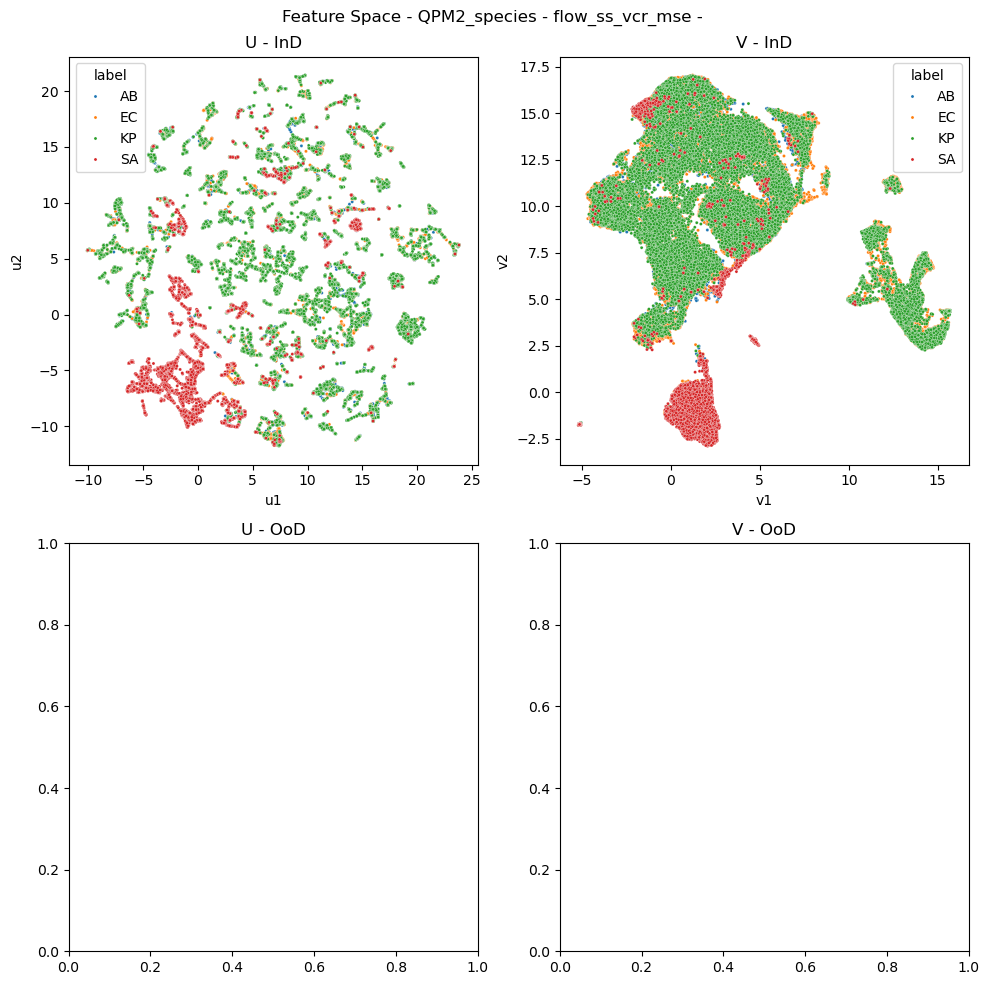

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

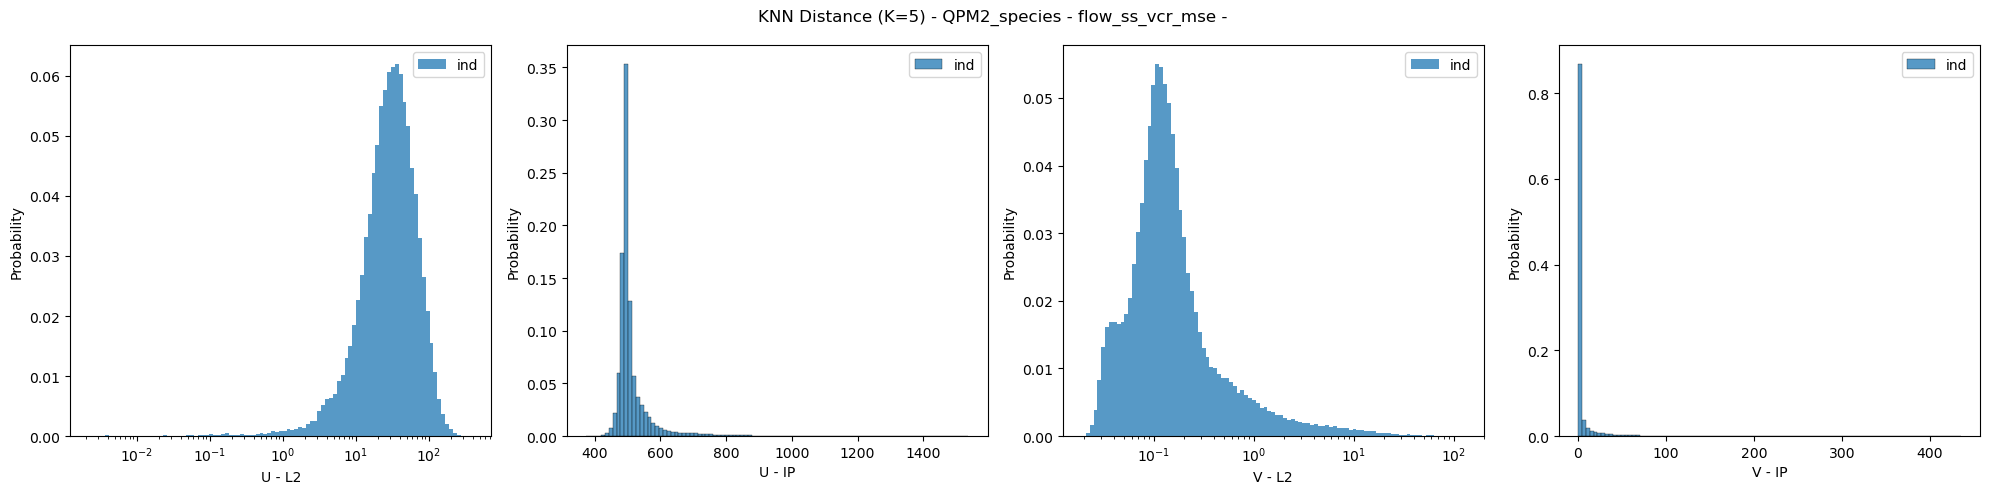

In [13]:
# plot knn distance from ind/ood to val data
def plot_knn_dists(index_fn, ax, trn_data, val_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(trn_data.shape[-1])
    index.add(trn_data)
    Dv = index.search(val_data, k)[0].mean(-1)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=Dv.tolist(), ind_data=Di.tolist(), ood_data=Do.tolist()))
        
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")
run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], trn_e_u, val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], trn_e_v, val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

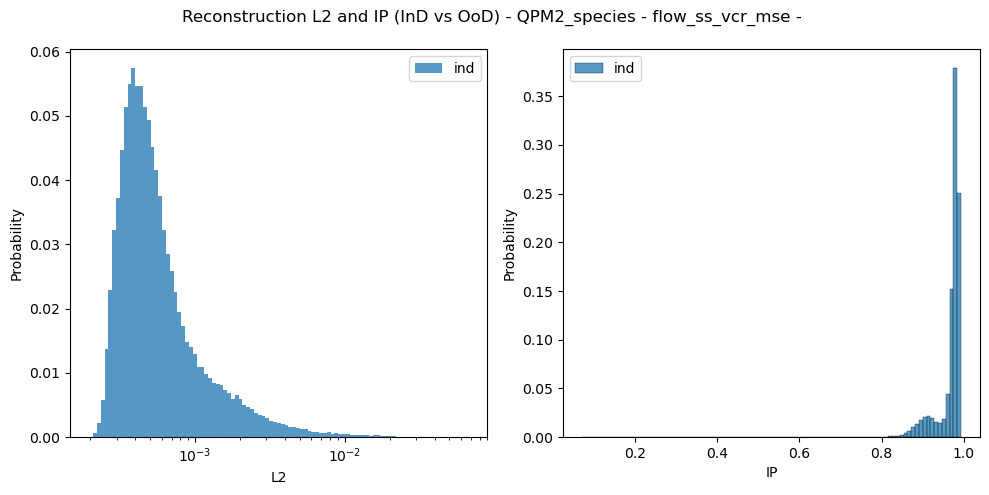

In [14]:
# plot reconstruction-based ood metrics
def plot_rcn(val_rcn, ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc, val_data=val_rcn.tolist(), ind_data=ind_rcn.tolist(), ood_data=ood_rcn.tolist()))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)


# training data
_val_inp, _val_rcn = flatten(val_inp), flatten(val_rcn)
_val_inp_unit, _val_rcn_unit = unit(_val_inp), unit(_val_rcn)
# metrics
val_rcn_l2 = ((_val_inp - _val_rcn) ** 2).mean(-1)
val_rcn_ip = (_val_inp_unit * _val_rcn_unit).sum(-1)

# ind test data
_ind_inp, _ind_rcn = flatten(ind_inp), flatten(ind_rcn)
_ind_inp_unit, _ind_rcn_unit = unit(_ind_inp), unit(_ind_rcn)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # ood test data
    _ood_inp, _ood_rcn = flatten(ood_inp), flatten(ood_rcn)
    _ood_inp_unit, _ood_rcn_unit = unit(_ood_inp), unit(_ood_rcn)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
run_stats["rcn_l2"] = plot_rcn(val_rcn_l2, ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(val_rcn_ip, ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)

if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)

run_stats["norm_u"] = dict(val_data=val_n_u.tolist(), ind_data=ind_n_u.tolist(), ood_data=ood_n_u.tolist() if ood_str else None)
run_stats["norm_v"] = dict(val_data=val_n_v.tolist(), ind_data=ind_n_v.tolist(), ood_data=ood_n_v.tolist() if ood_str else None)

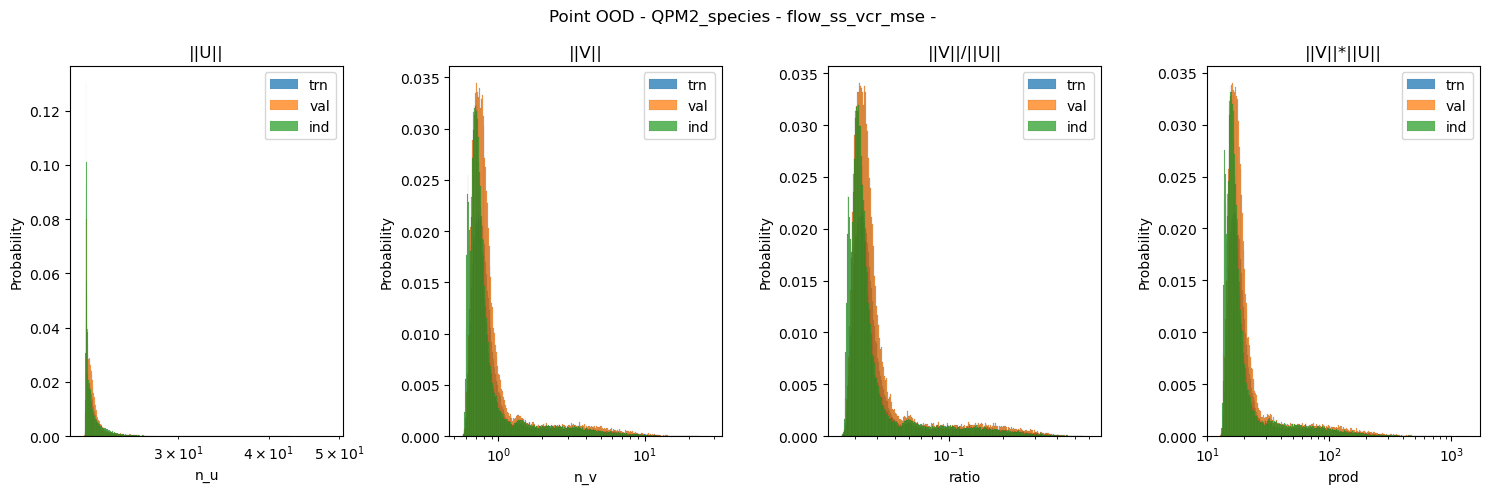

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


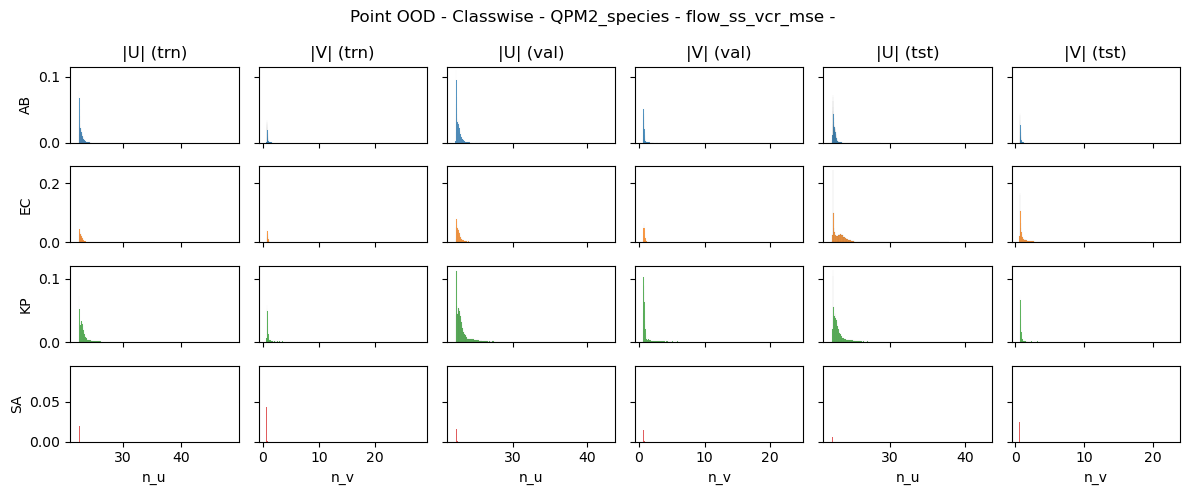

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

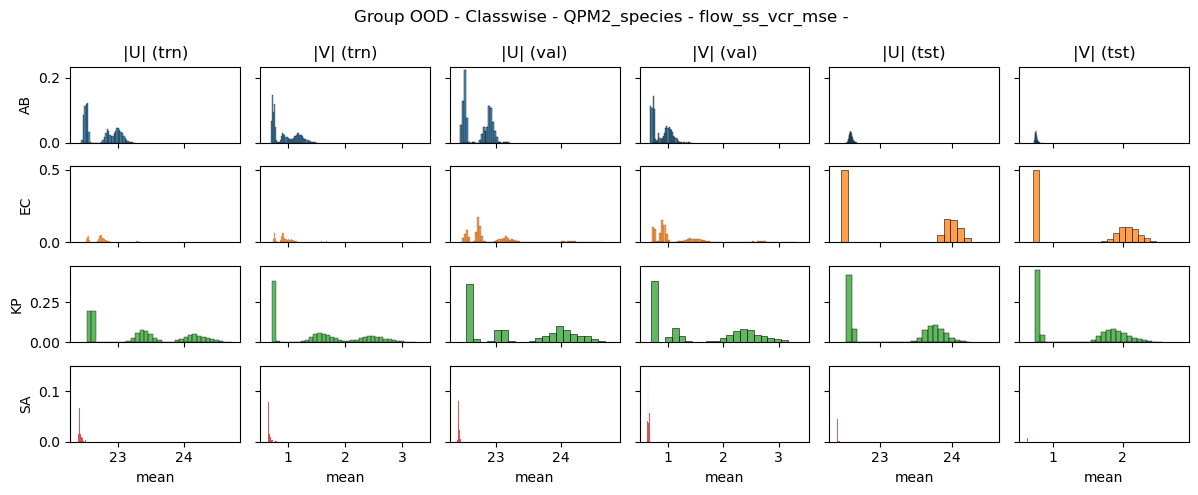

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))
import gzip
import pickle
with gzip.open(f"{save_name}_stats.gz", "wb") as f:
    pickle.dump(run_stats, f)